# Clustering Zillow Project
## Which feature is the biggest driver of error in the zestimate?

In this project, we will use the Zillow dataset for single-unit/single-family properties with a transaction date in 2017 in Orange, Los Angeles, and Ventura Counties. 

# Import Libraries

We will start by importing the necessary libraries. 

In [2]:
#Disable warnings
import warnings
warnings.filterwarnings("ignore")

#Libraries for processing data
import pandas as pd
import numpy as np

#Import libraries for graphing
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

#Libraries for obtaining data from SQL databse
import env
import os

#Library for statistical testing
from scipy import stats

#Import libaries to acquire and prepare the data
from acquire import zillow_data
from prepare import prepare_data
from prepare import data_no_outliers
from prepare import split_data

# supress scientific notation
np.set_printoptions(suppress=True)

#Import for Clustering
from sklearn.cluster import KMeans

#Import for Scaling
import sklearn.preprocessing 

#Imports for modeling
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error

# Acquire

In this section, we will acquire the data from Zillow dataset for properties that are:
 - single unit,
 - in Los Angeles, Orange, or Ventura County, and
 - and have a transaction date in 2017. 

We use the function `zillow_data` function from our acquire dataset. For more information on this function, please see the `acquire.py` file in this repository.

## Get DataFrame

In [3]:
df = zillow_data()

In [578]:
df.head()

,index,typeconstructiontypeid,storytypeid,propertylandusetypeid,id,heatingorsystemtypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,basementsqft,...,censustractandblock,airconditioningdesc,architecturalstyledesc,heatingorsystemdesc,logerror,transactiondate,last_trans_date,propertylandusedesc,storydesc,typeconstructiondesc
0,0,NaN,NaN,269.0,0,NaN,NaN,NaN,10754147,NaN,...,NaN,None,None,None,0.025595,2017-01-01,2017-01-01,Planned Unit Development,None,None
1,1,NaN,NaN,261.0,1,NaN,NaN,NaN,10759547,NaN,...,NaN,None,None,None,0.055619,2017-01-01,2017-01-01,Single Family Residential,None,None
2,8,NaN,NaN,269.0,8,NaN,NaN,NaN,10954547,NaN,...,NaN,None,None,None,-0.040966,2017-01-02,2017-01-02,Planned Unit Development,None,None
3,10,NaN,NaN,269.0,10,2.0,NaN,1.0,11070347,NaN,...,NaN,Central,None,Central,0.005963,2017-01-02,2017-01-02,Planned Unit Development,None,None
4,12,NaN,NaN,269.0,12,NaN,NaN,NaN,11114347,NaN,...,NaN,None,None,None,-0.028835,2017-01-02,2017-01-02,Planned Unit Development,None,None


Now we will explore and describe our new dataset.

### DataFrame Information

In [579]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71905 entries, 0 to 71904
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   index                         71905 non-null  int64  
 1   typeconstructiontypeid        166 non-null    float64
 2   storytypeid                   44 non-null     float64
 3   propertylandusetypeid         71905 non-null  float64
 4   id                            71905 non-null  int64  
 5   heatingorsystemtypeid         46872 non-null  float64
 6   architecturalstyletypeid      151 non-null    float64
 7   airconditioningtypeid         21038 non-null  float64
 8   parcelid                      71905 non-null  int64  
 9   basementsqft                  44 non-null     float64
 10  bathroomcnt                   71905 non-null  float64
 11  bedroomcnt                    71905 non-null  float64
 12  buildingqualitytypeid         45974 non-null  float64
 13  c

## DataFrame Description

In [580]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
index,71905.0,3.896464e+04,2.241883e+04,0.000000e+00,1.938700e+04,3.913000e+04,5.829700e+04,7.761300e+04
typeconstructiontypeid,166.0,5.987952e+00,1.552301e-01,4.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00
storytypeid,44.0,7.000000e+00,0.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00
propertylandusetypeid,71905.0,2.621015e+02,2.179844e+00,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.750000e+02
id,71905.0,3.896464e+04,2.241883e+04,0.000000e+00,1.938700e+04,3.913000e+04,5.829700e+04,7.761300e+04
heatingorsystemtypeid,46872.0,3.969150e+00,3.242331e+00,1.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,2.400000e+01
architecturalstyletypeid,151.0,7.430464e+00,2.629347e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
airconditioningtypeid,21038.0,1.896806e+00,3.094992e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
parcelid,71905.0,1.339018e+07,8.187726e+06,1.071174e+07,1.155702e+07,1.260406e+07,1.415278e+07,1.696019e+08
basementsqft,44.0,5.918182e+02,4.661602e+02,6.300000e+01,2.190000e+02,5.280000e+02,7.445000e+02,2.443000e+03


# Visualizing the Distributions

Before we visualize, our distributions, we set our color palette to "bright" so that we can more easily see our graphs.

In [581]:
sns.set_palette("bright")

I would like to use `countplot` for the features with a smaller number of unique vales and `histplot` for the features with a larger number of unique values. Thus, I will create a series of functions to graph different features in our DataFrame. 

For some of the features, I will graph individually because the x-axes labels need particular formatting.

## Functions for Visualizing our Features

### Countplot for Numeric Features with a Low Value Count

In [582]:
def numeric_values_low_value_count(df):
    for col in df.columns:
        if df[col].dtype == float and len(df[col].unique()) < 10:
            #Set figure size
            plt.figure(figsize=(22, 12))
            #Create graph
            a = sns.countplot(data = df, x=df[col])
            # Set labels 
            labels = a.set(title = "Value Counts", ylabel = "Number of Values")
    return a

### Histogram for Numeric Features with a High Value Count

In [583]:
def numeric_values_high_value_count(df):
    for col in df.columns:
        if df[col].dtype == float and len(df[col].unique()) >= 10:
            #Set figure size
            plt.figure(figsize=(22, 12))
            #Create graph
            a = sns.histplot(x=df[col], data=df)
            #Set labels 
            labels = a.set(title = "Distribution", ylabel = "Number of Values")
    return a

### Countplot for Object Features with a Low Value Count

In [584]:
def object_values_low_value_count(df):
    for col in df.columns:
        if df[col].dtype == object and len(df[col].unique()) < 10:
            #Set figure size
            plt.figure(figsize=(22, 12))
            #Create graph
            a = sns.countplot(x=df[col], data=df)
            #Set labels 
            labels = a.set(title = "Value Counts", ylabel = "Number of Values")
            a.tick_params(axis='x', labelrotation = 45)
    return a

## Graphing the Features

<AxesSubplot:title={'center':'Value Counts'}, xlabel='assessmentyear', ylabel='Number of Values'>

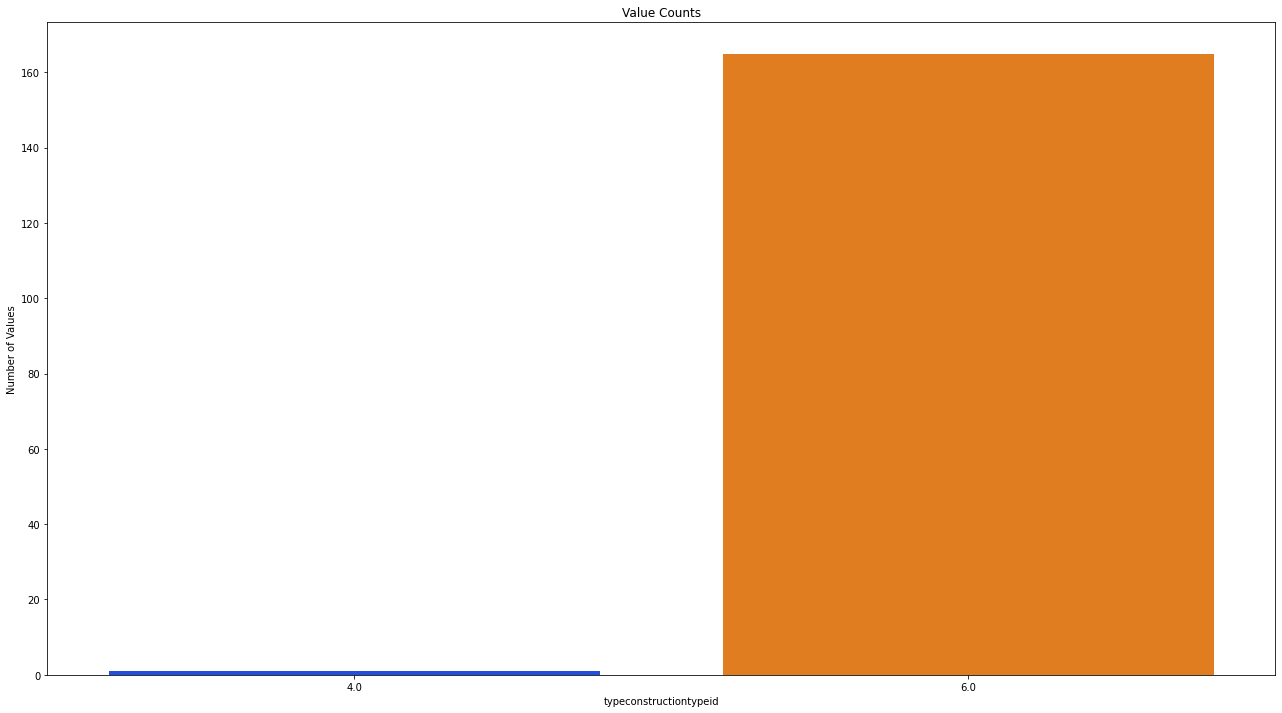

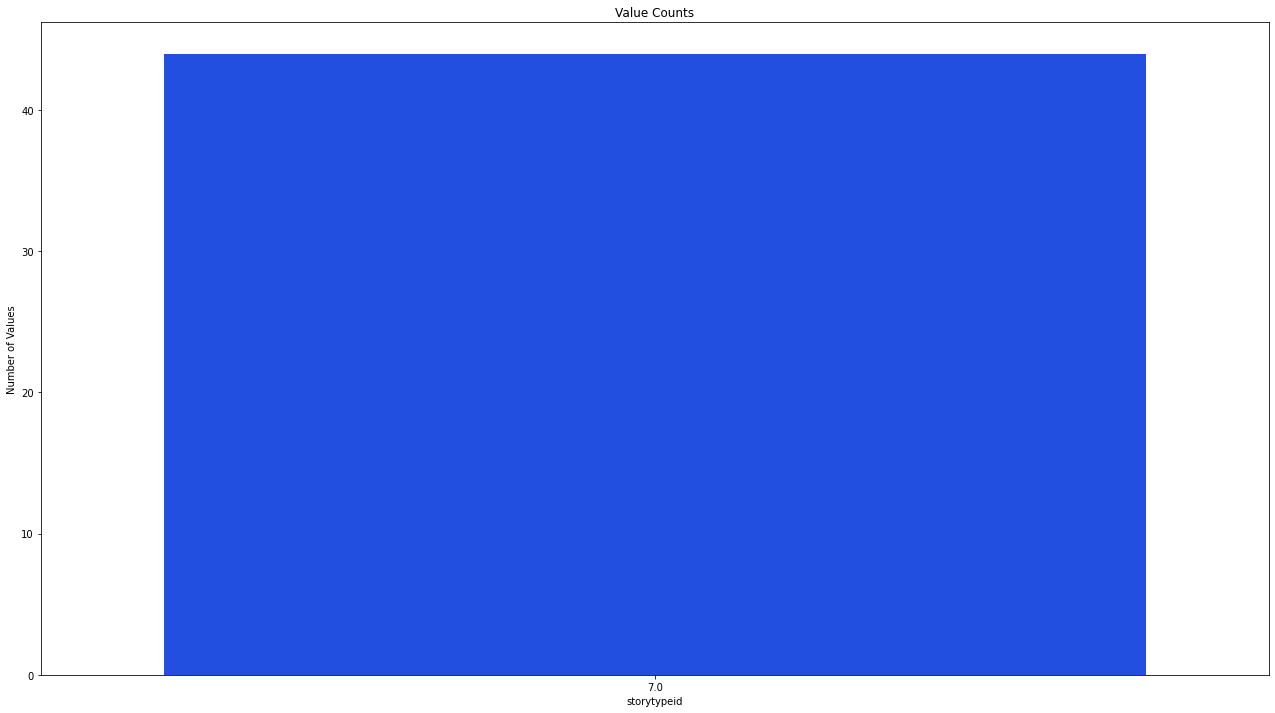

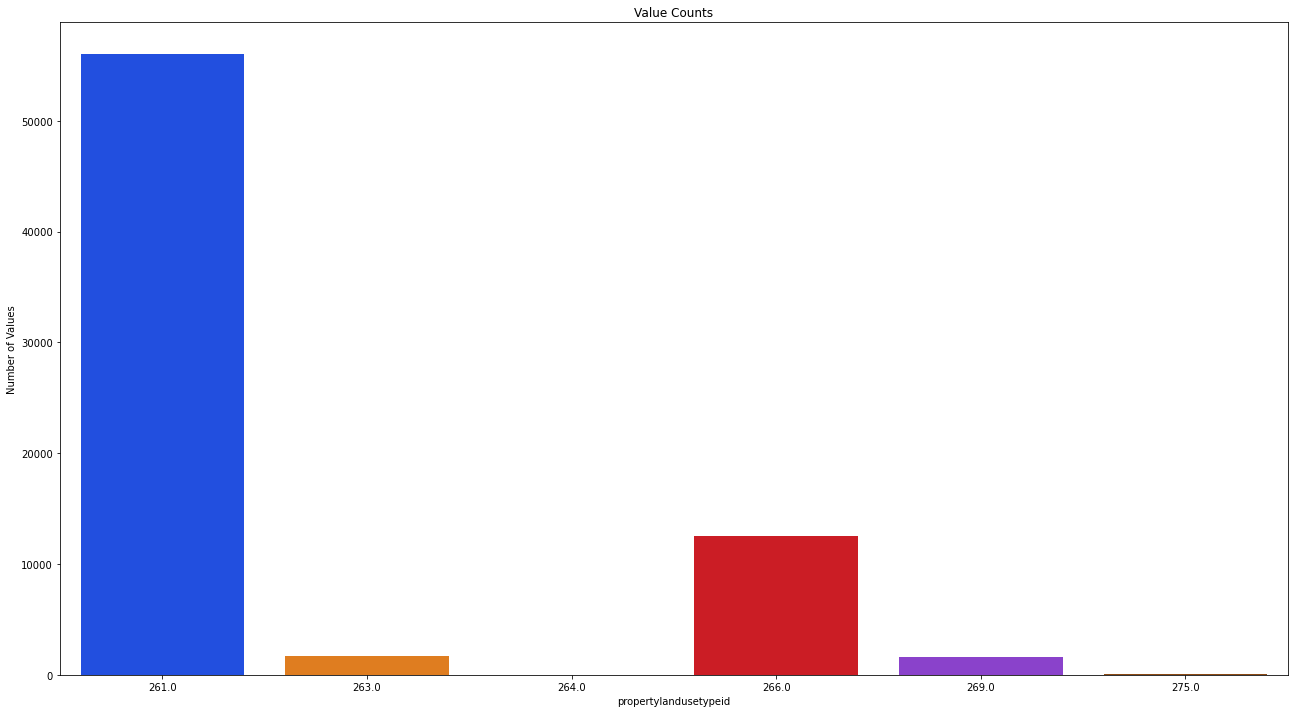

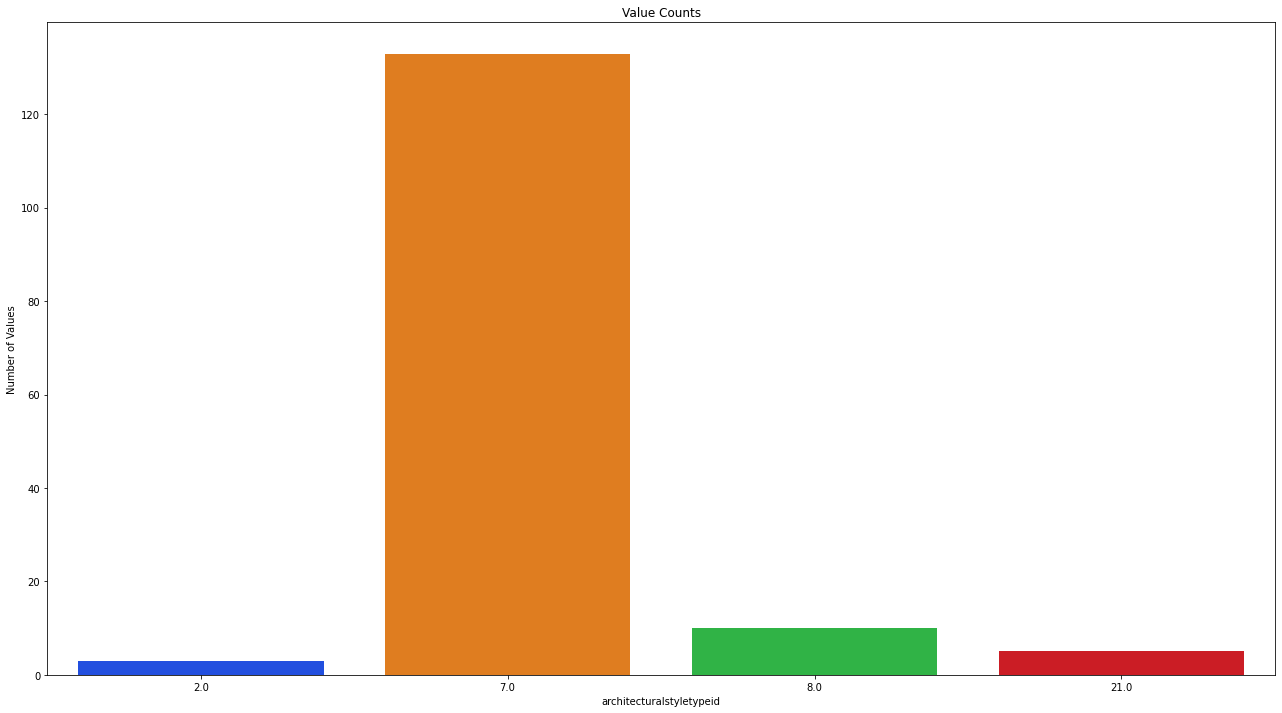

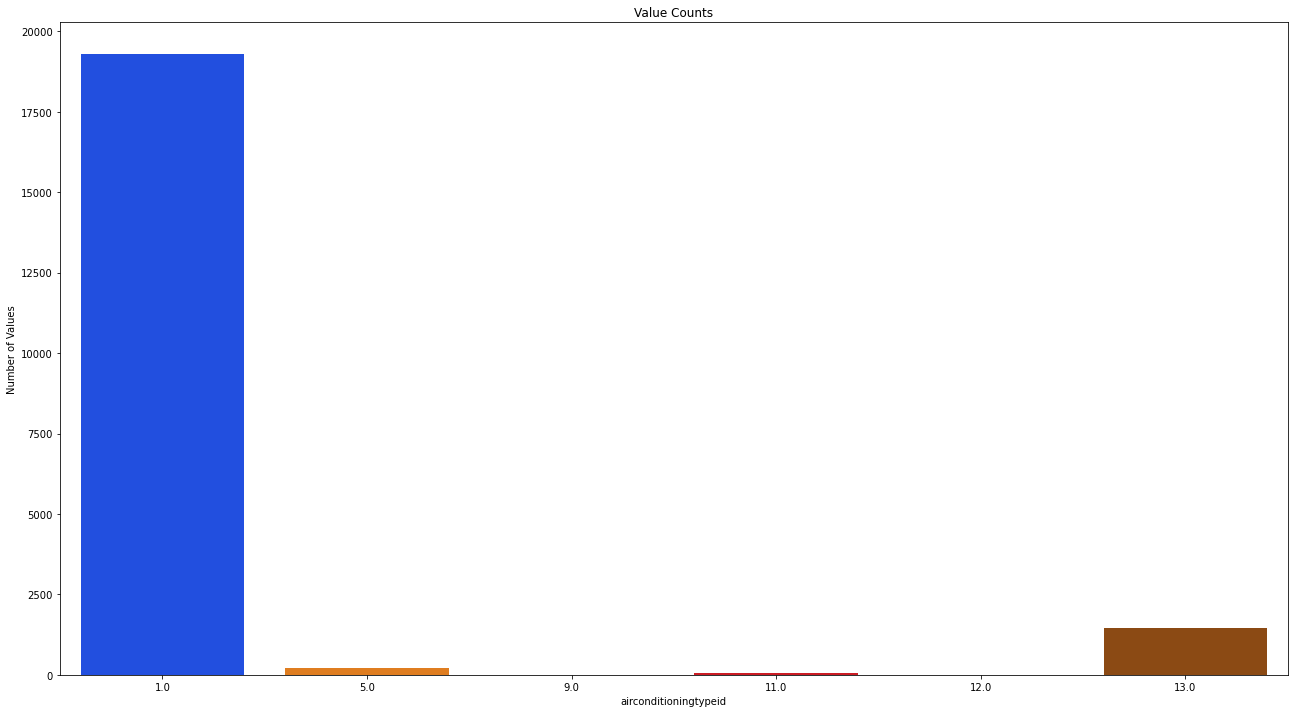

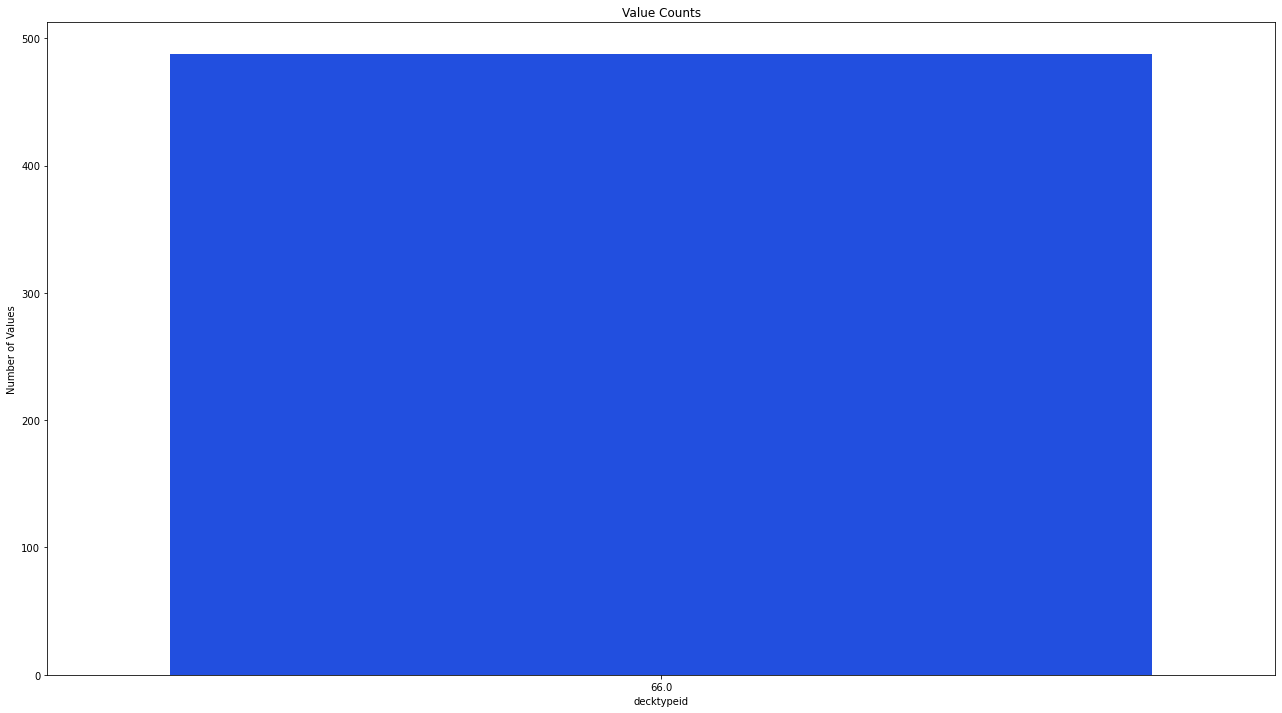

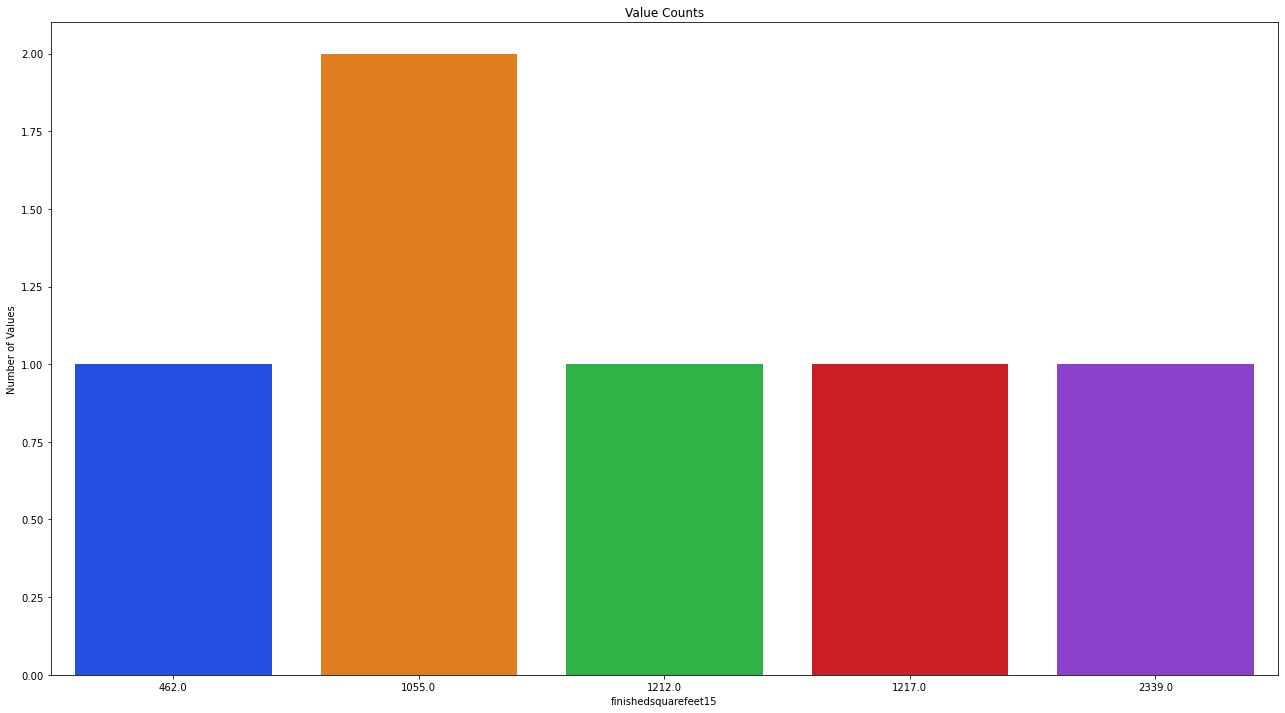

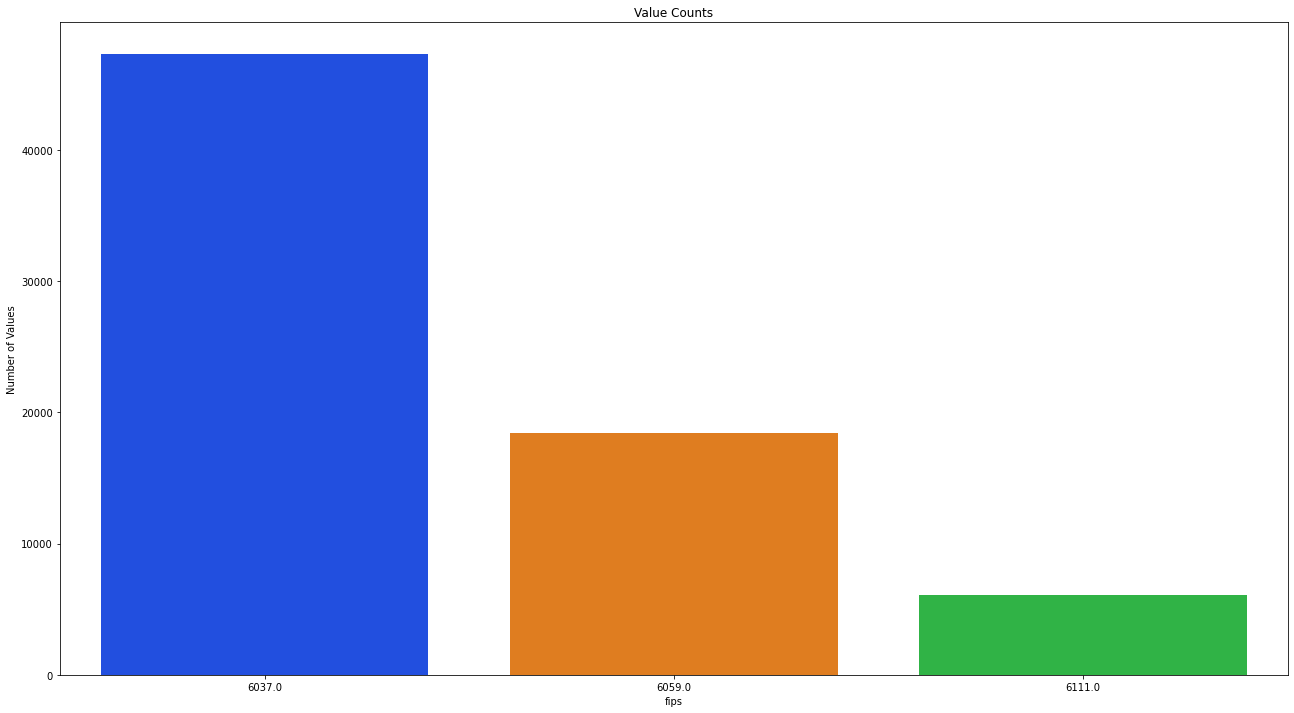

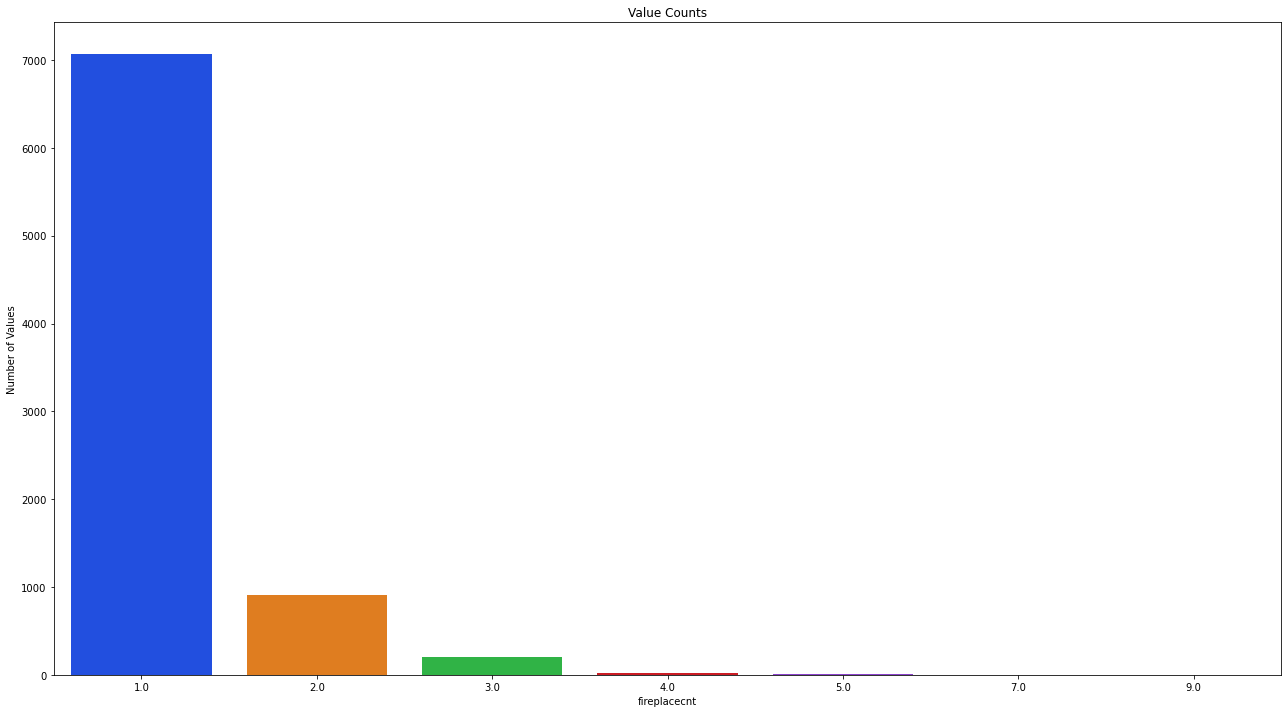

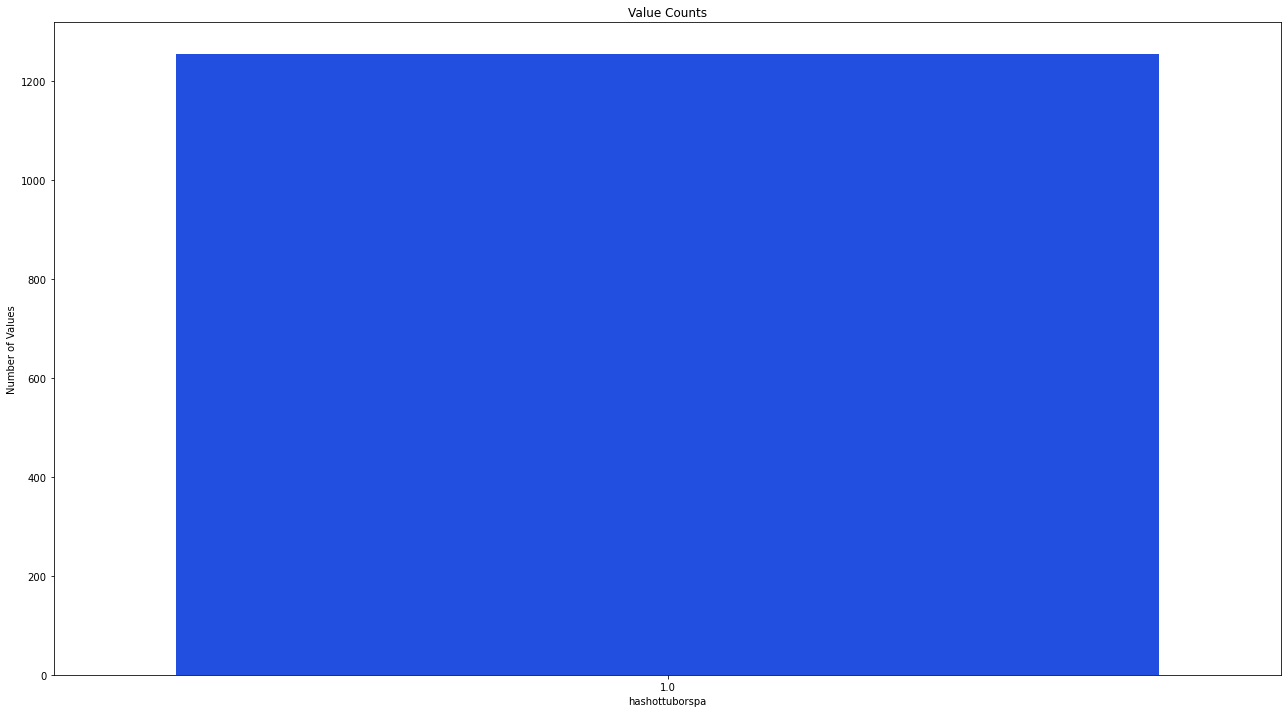

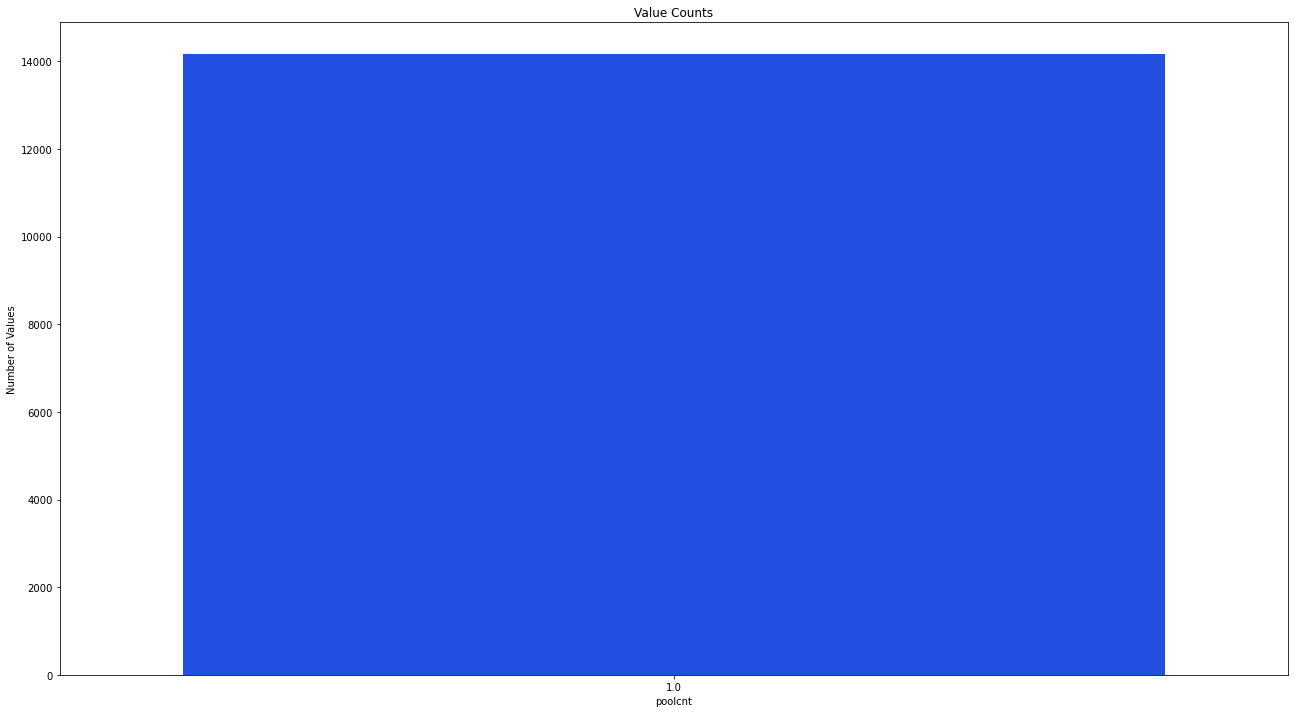

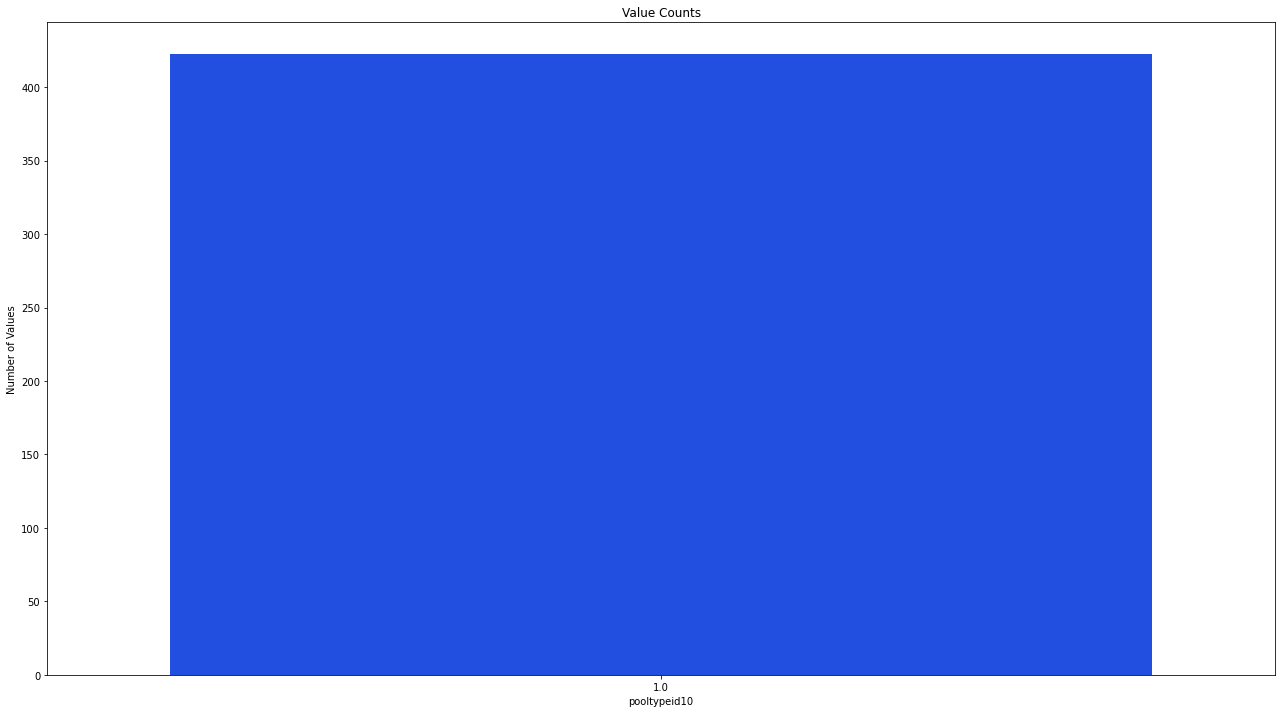

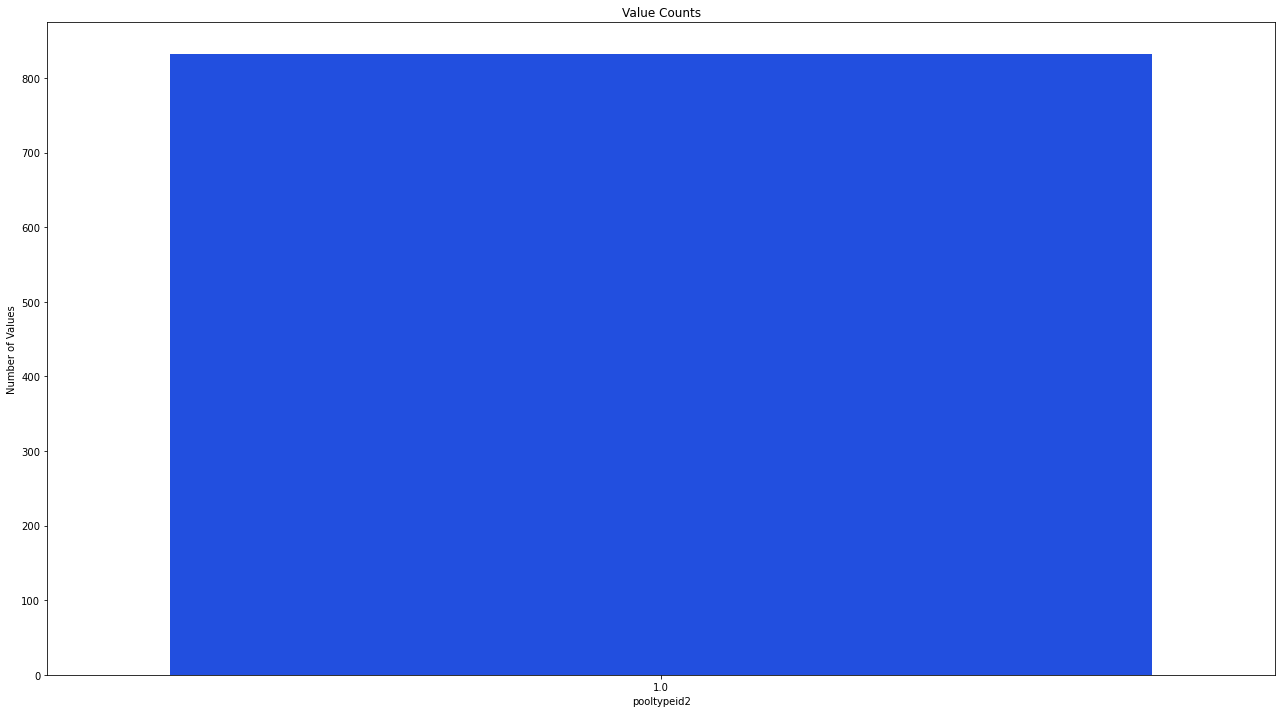

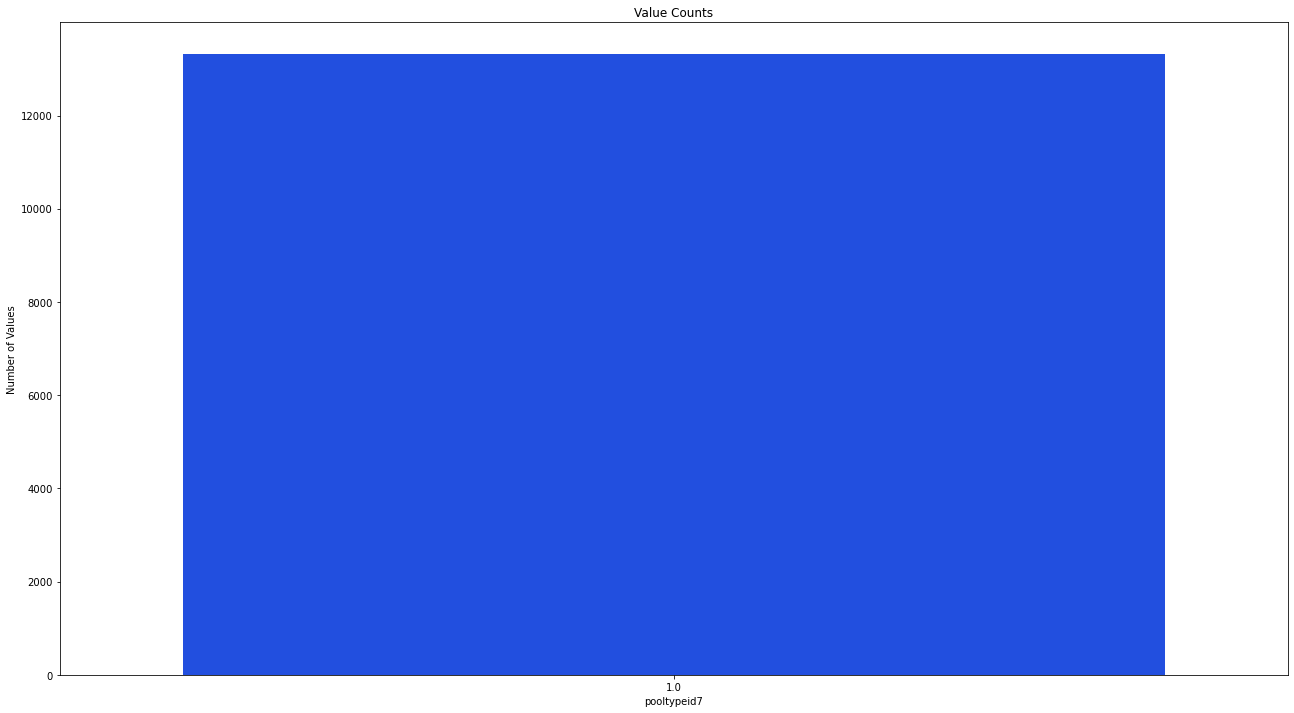

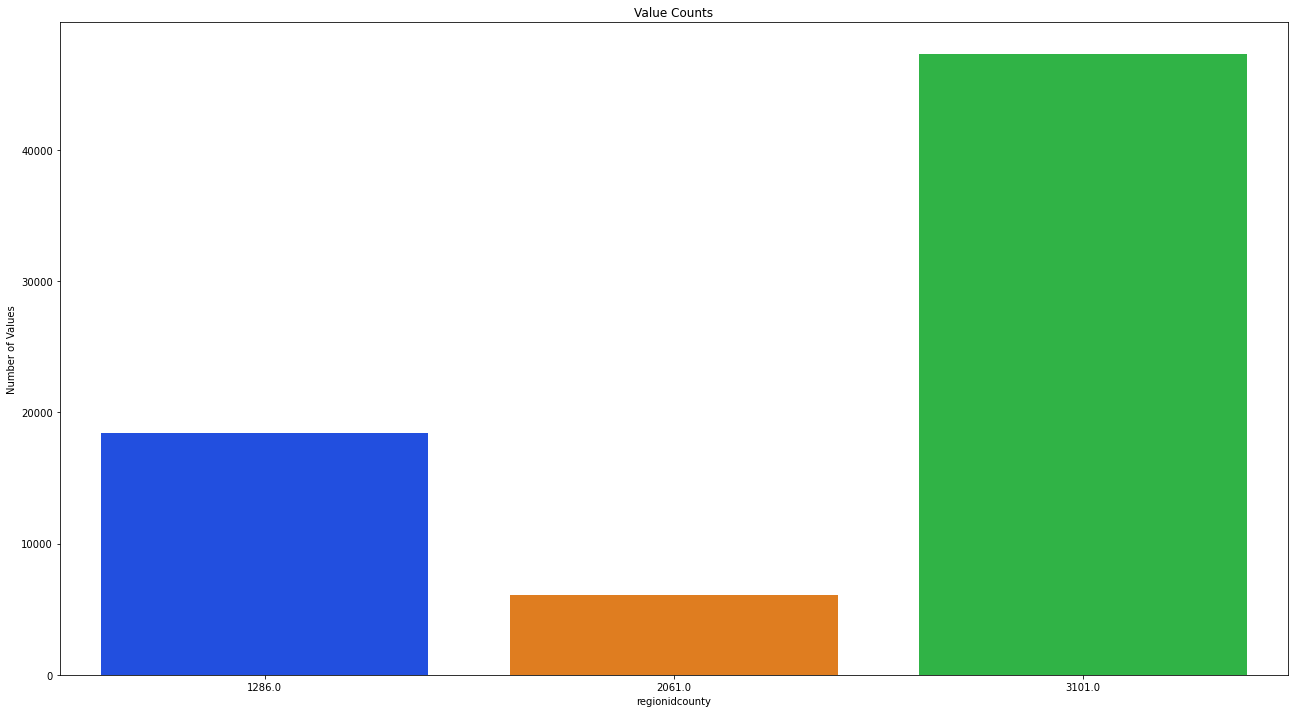

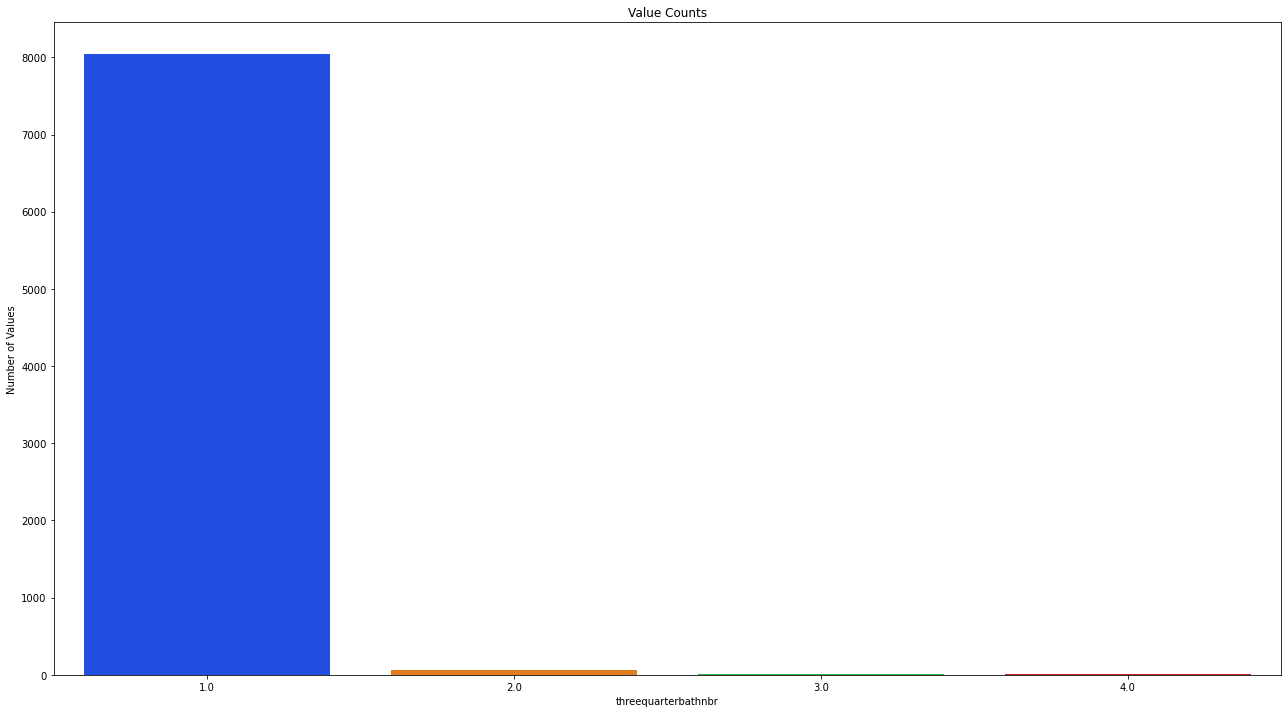

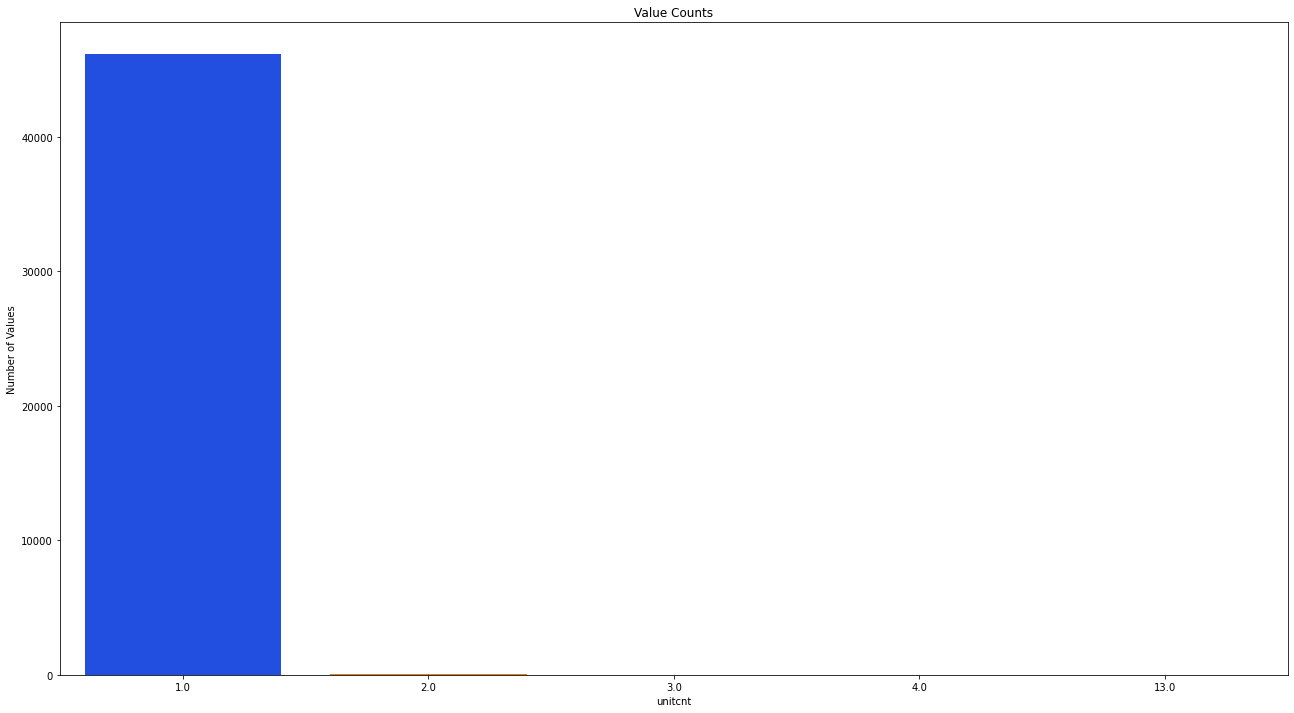

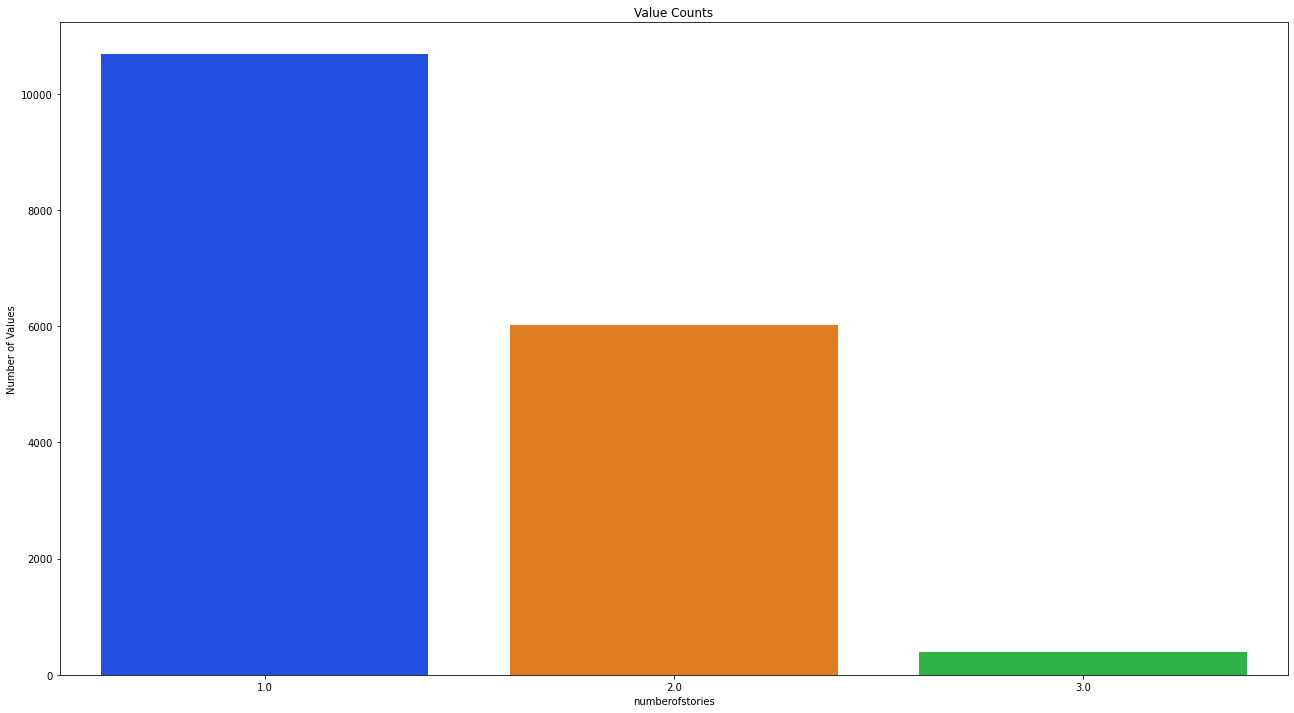

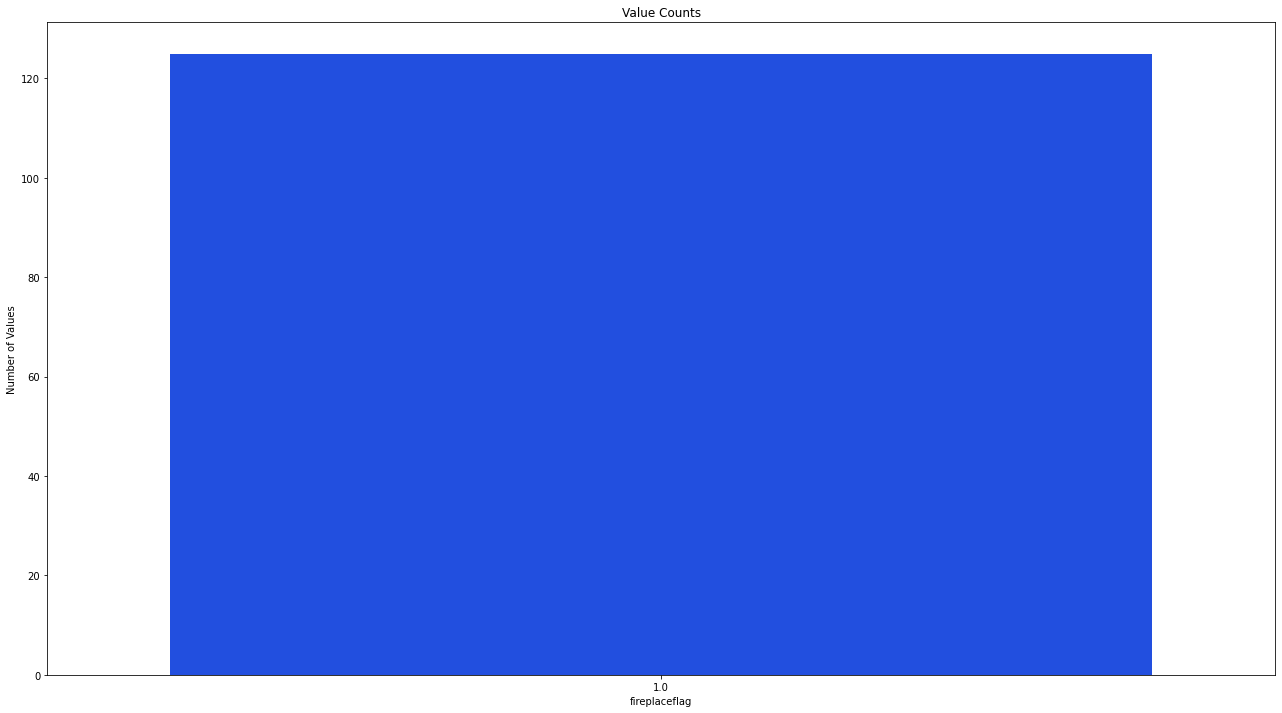

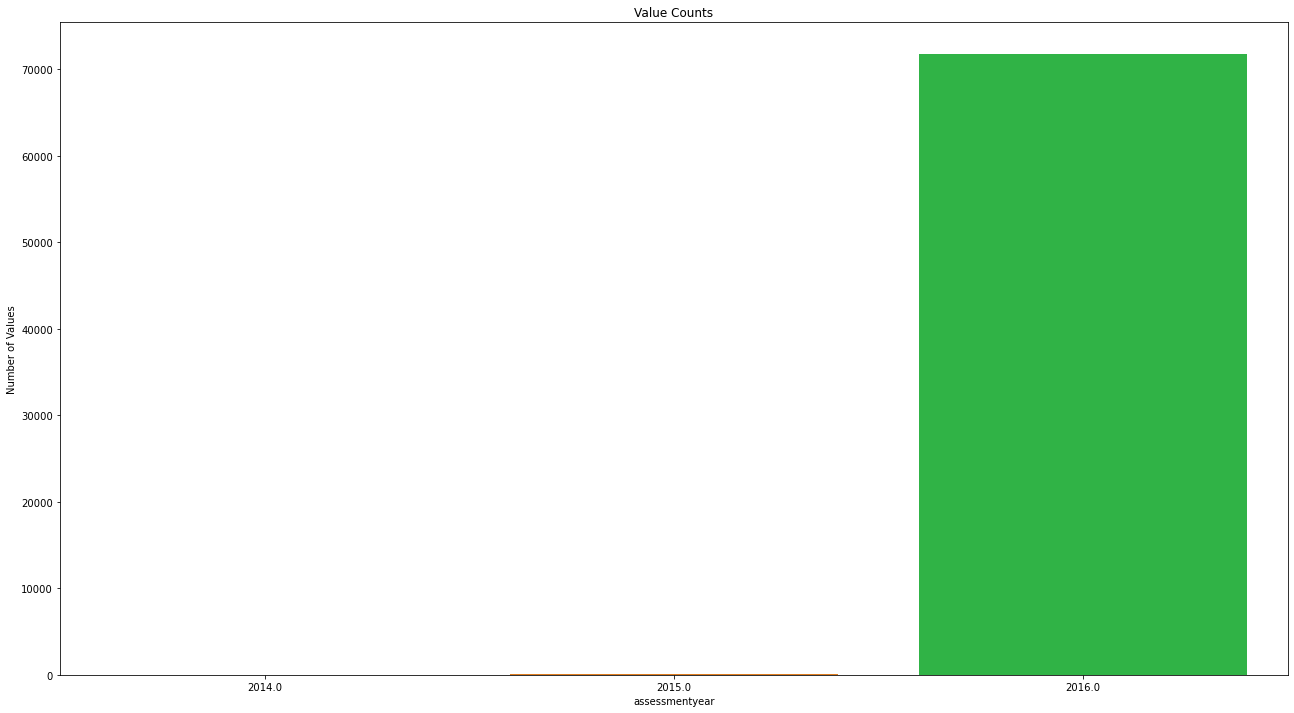

In [585]:
numeric_values_low_value_count(df)

<AxesSubplot:title={'center':'Distribution'}, xlabel='logerror', ylabel='Number of Values'>

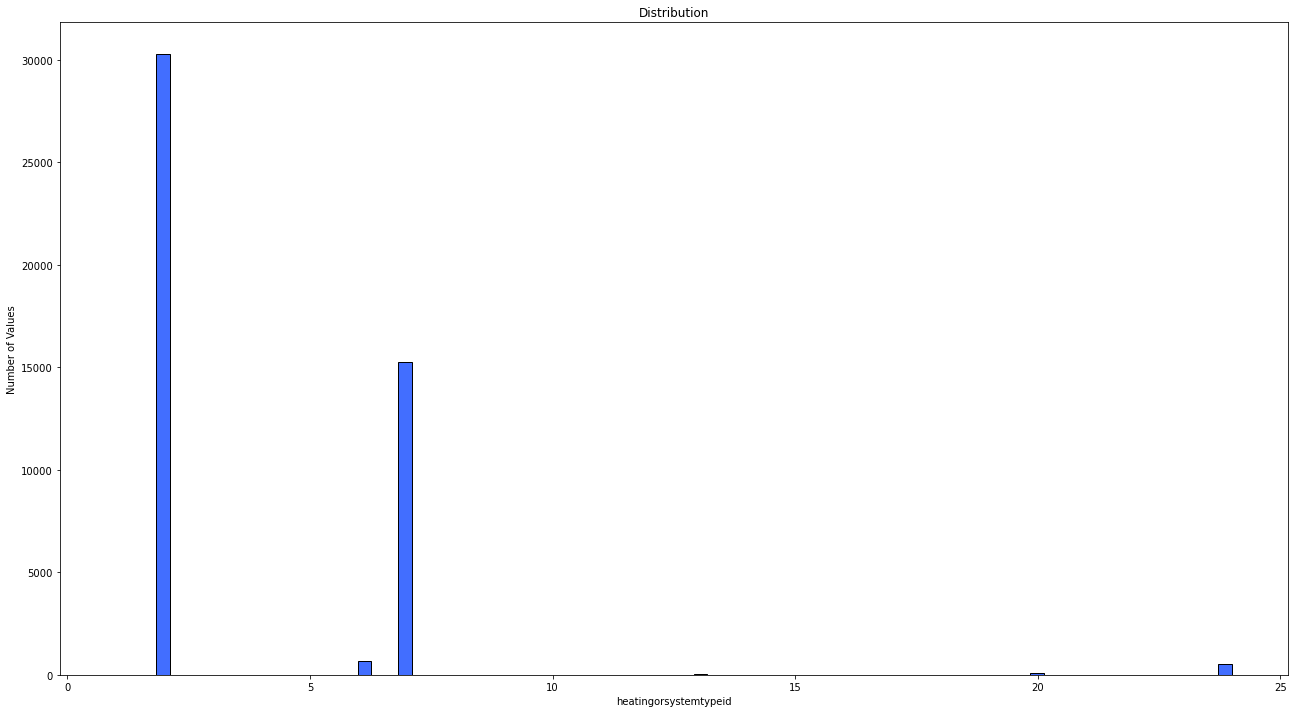

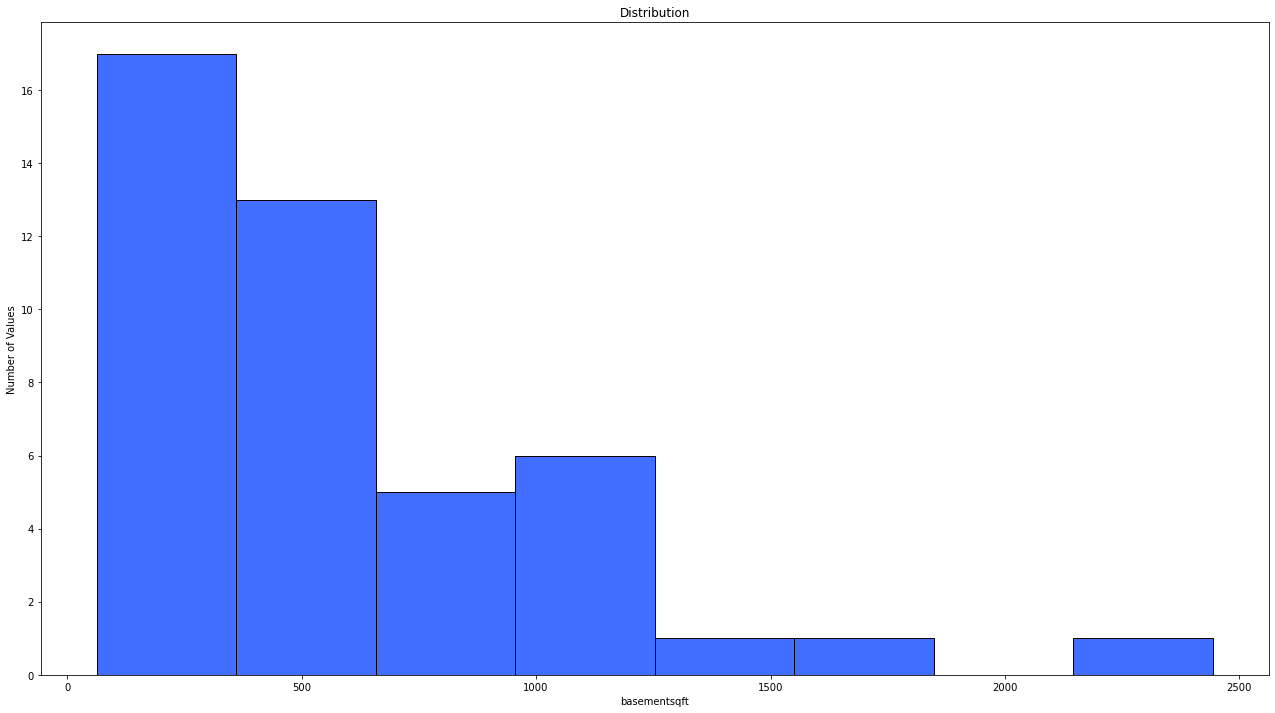

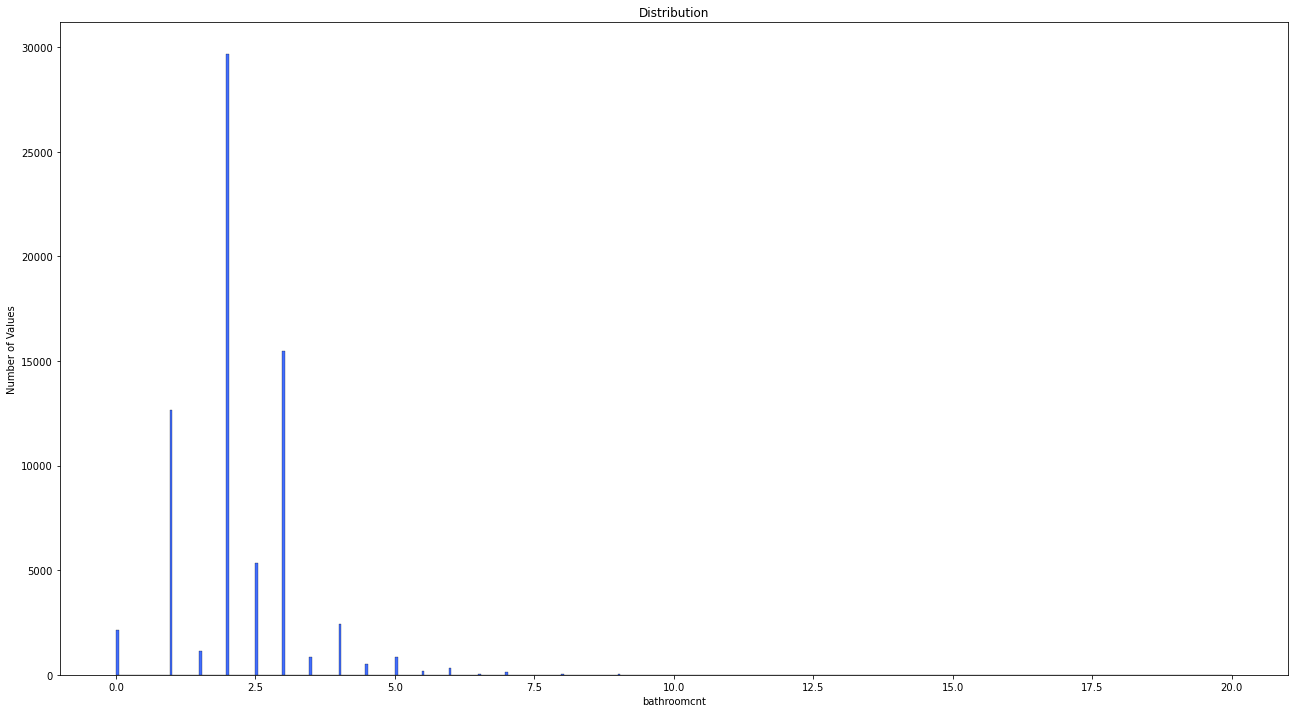

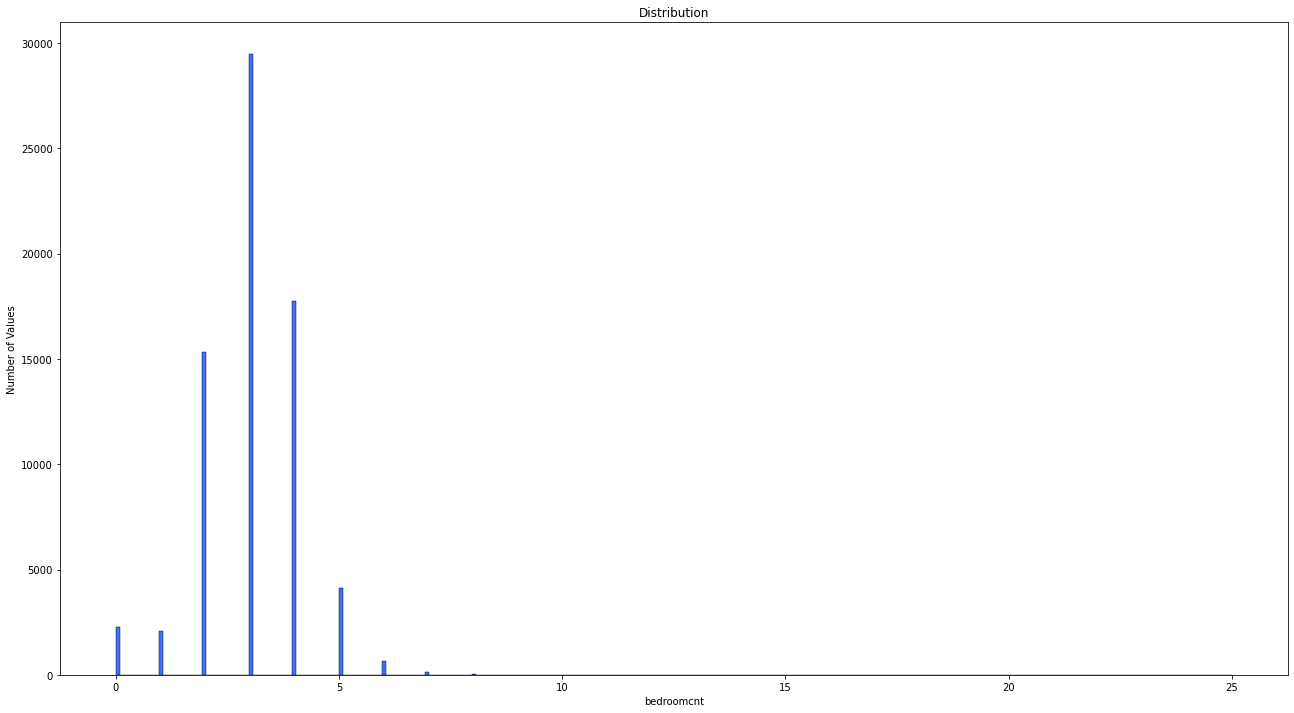

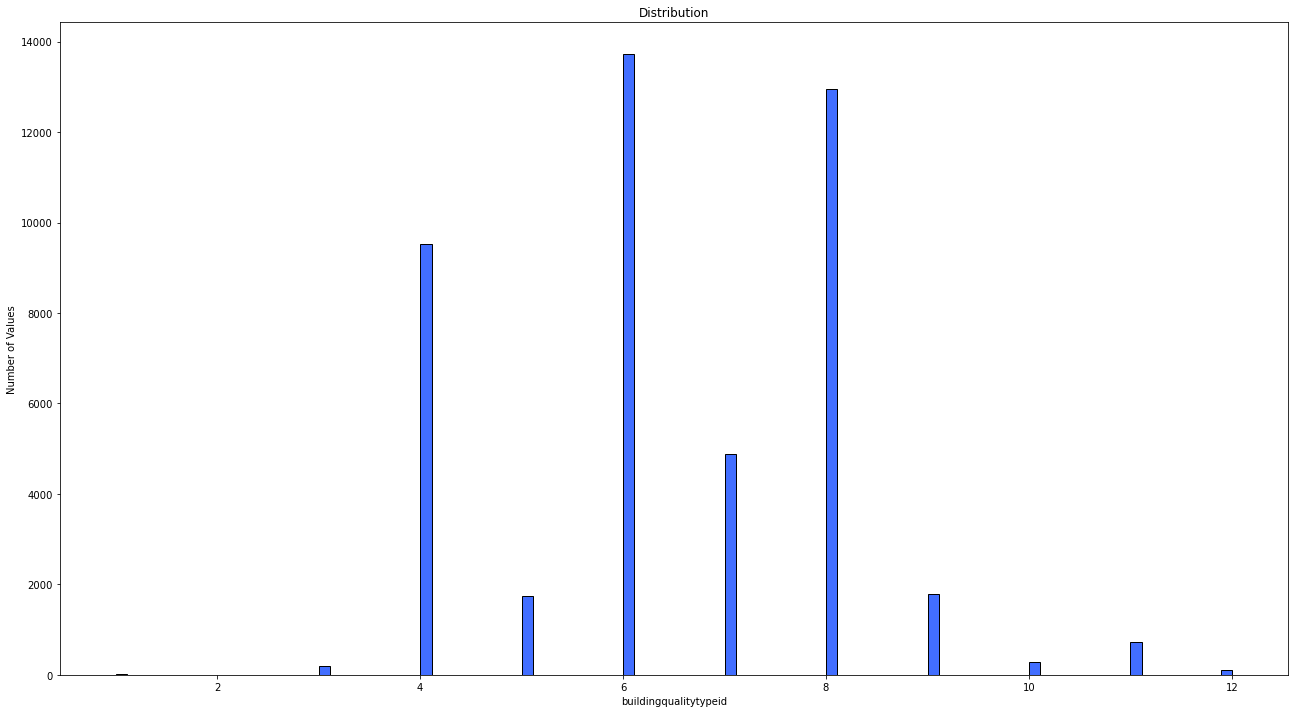

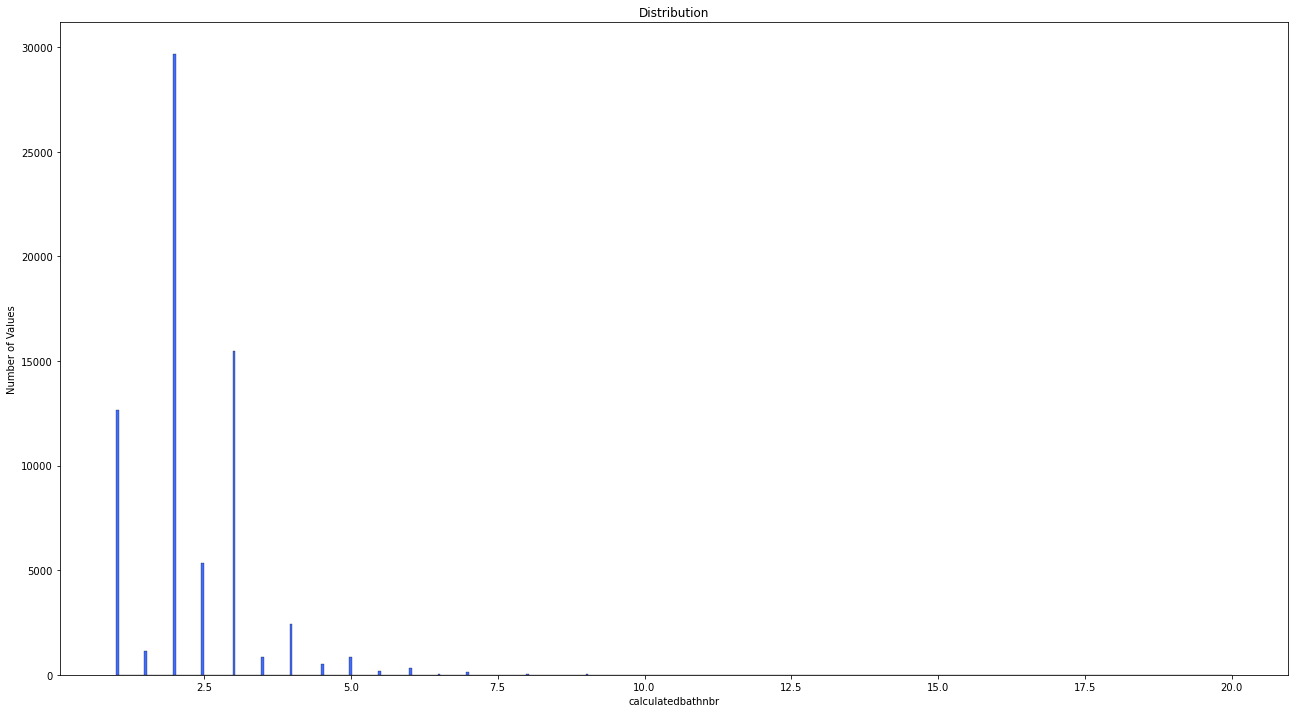

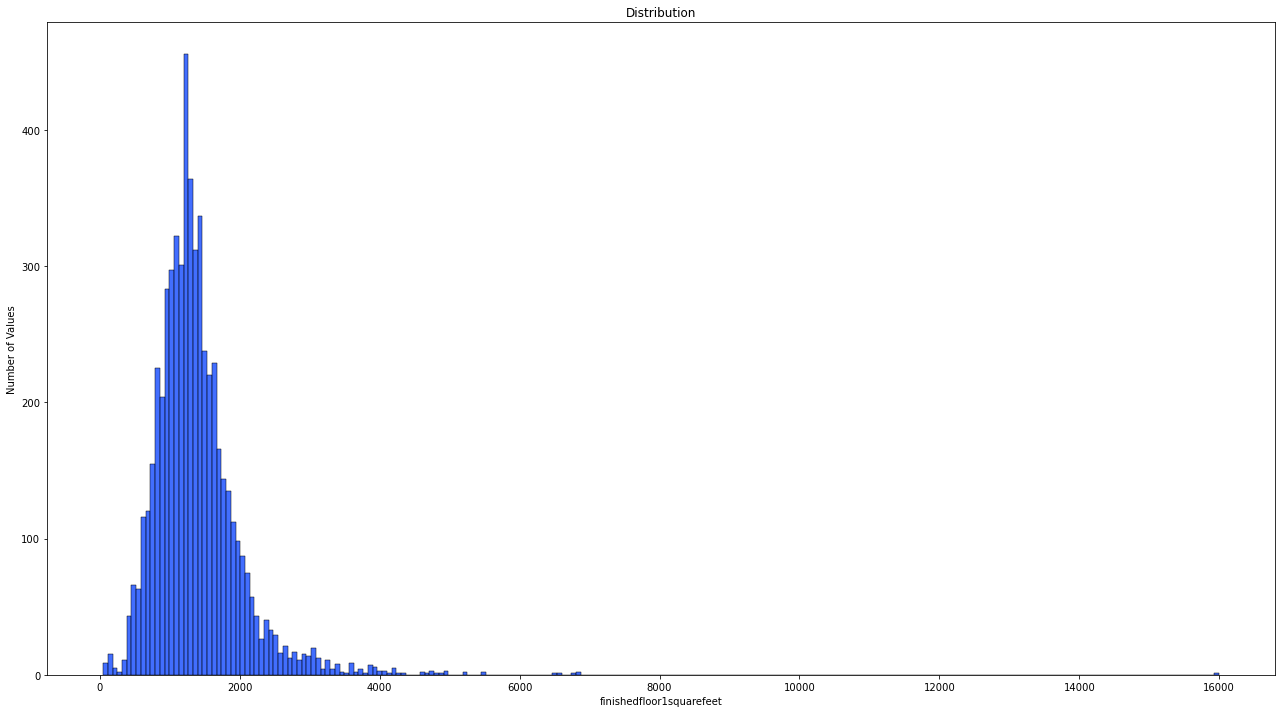

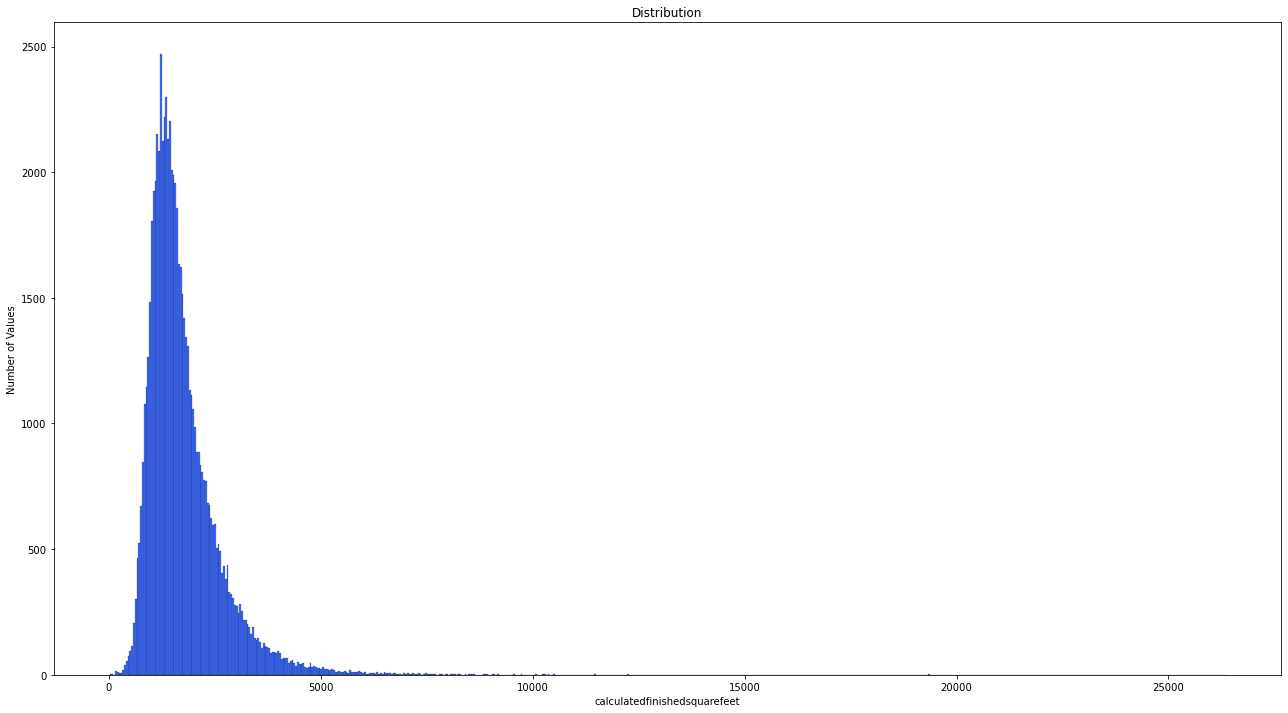

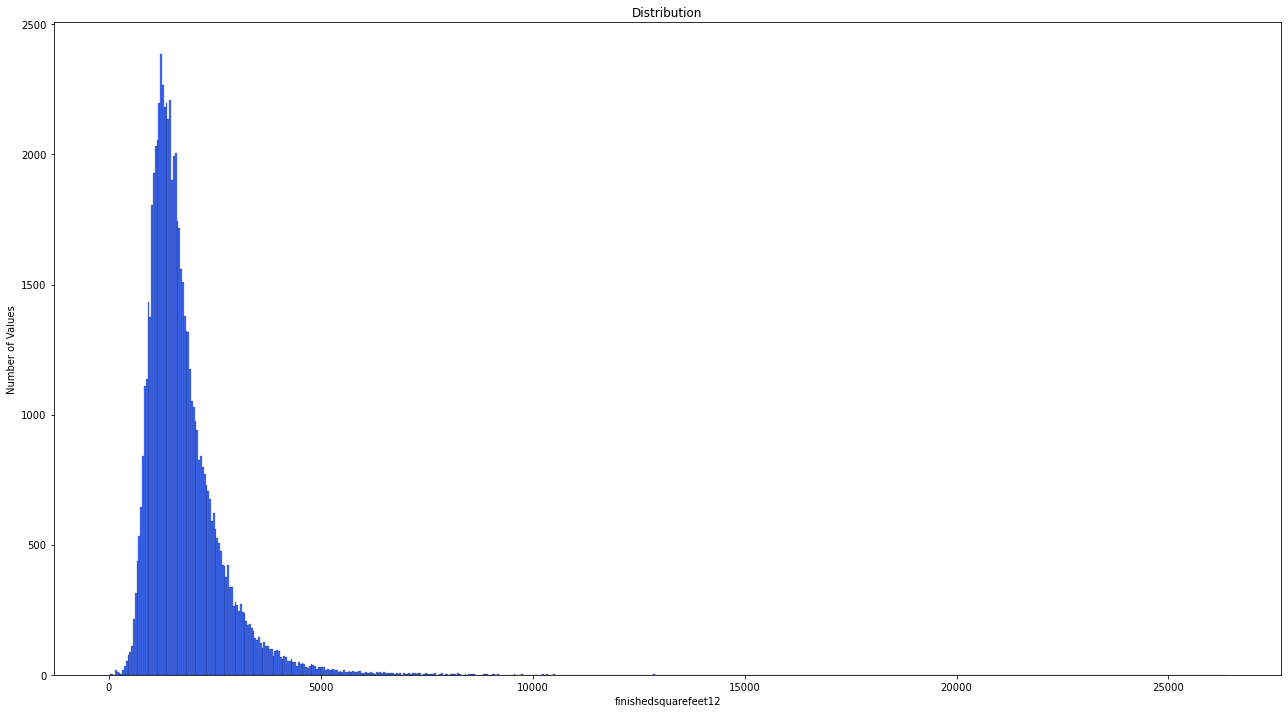

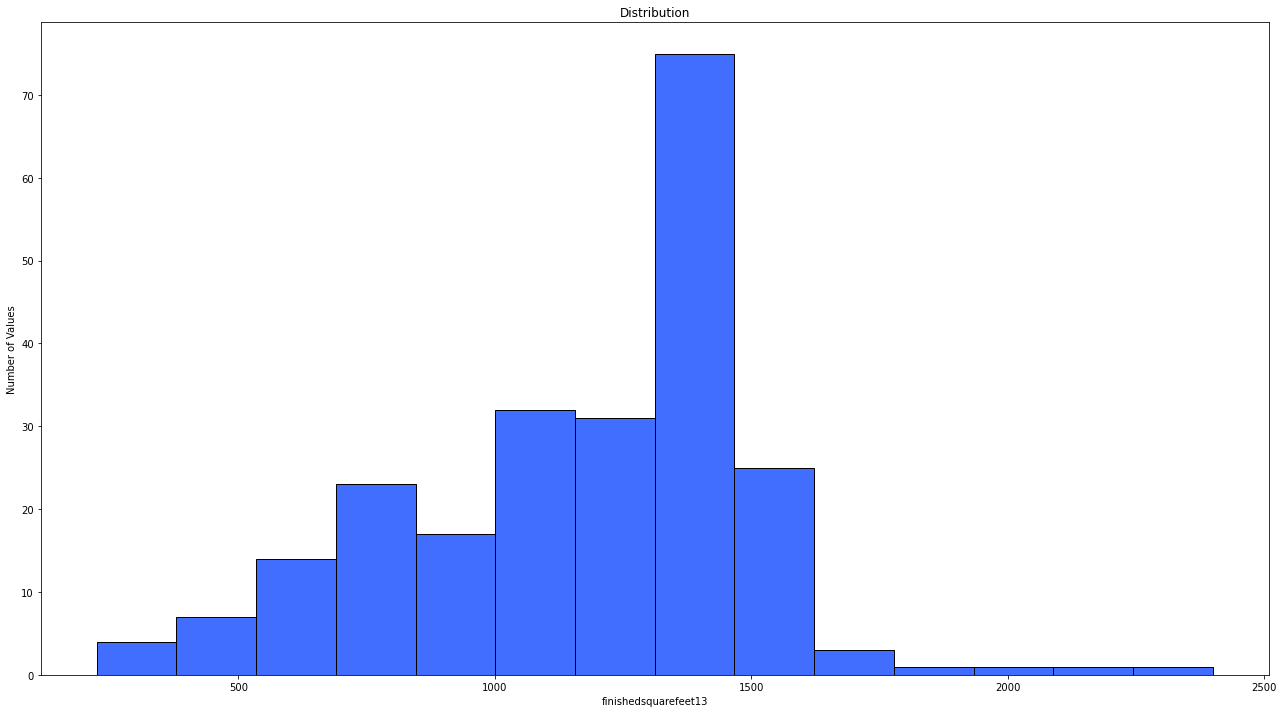

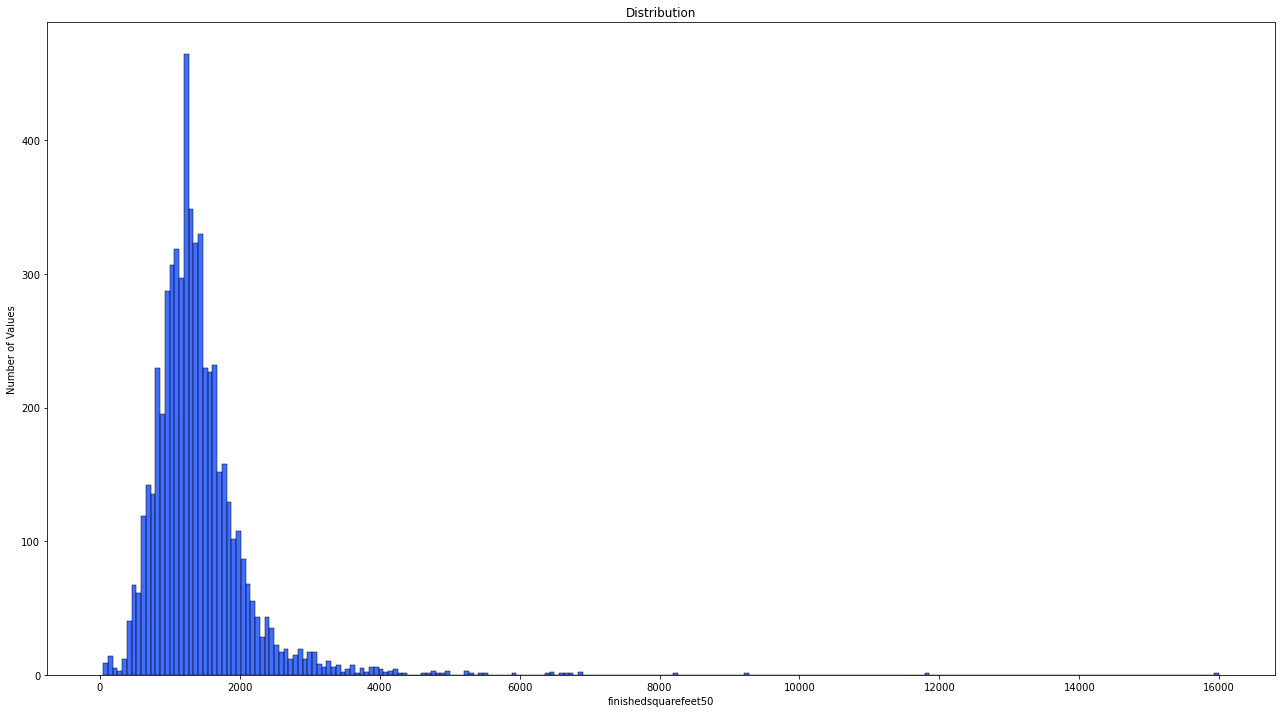

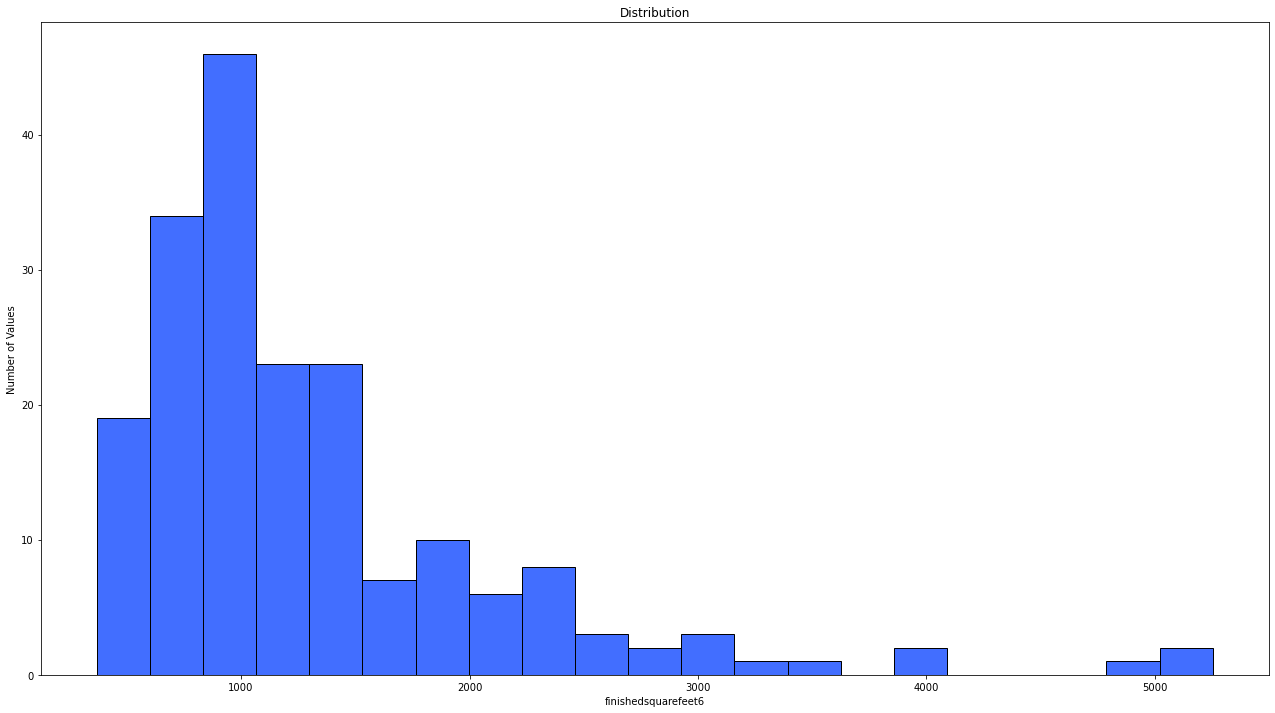

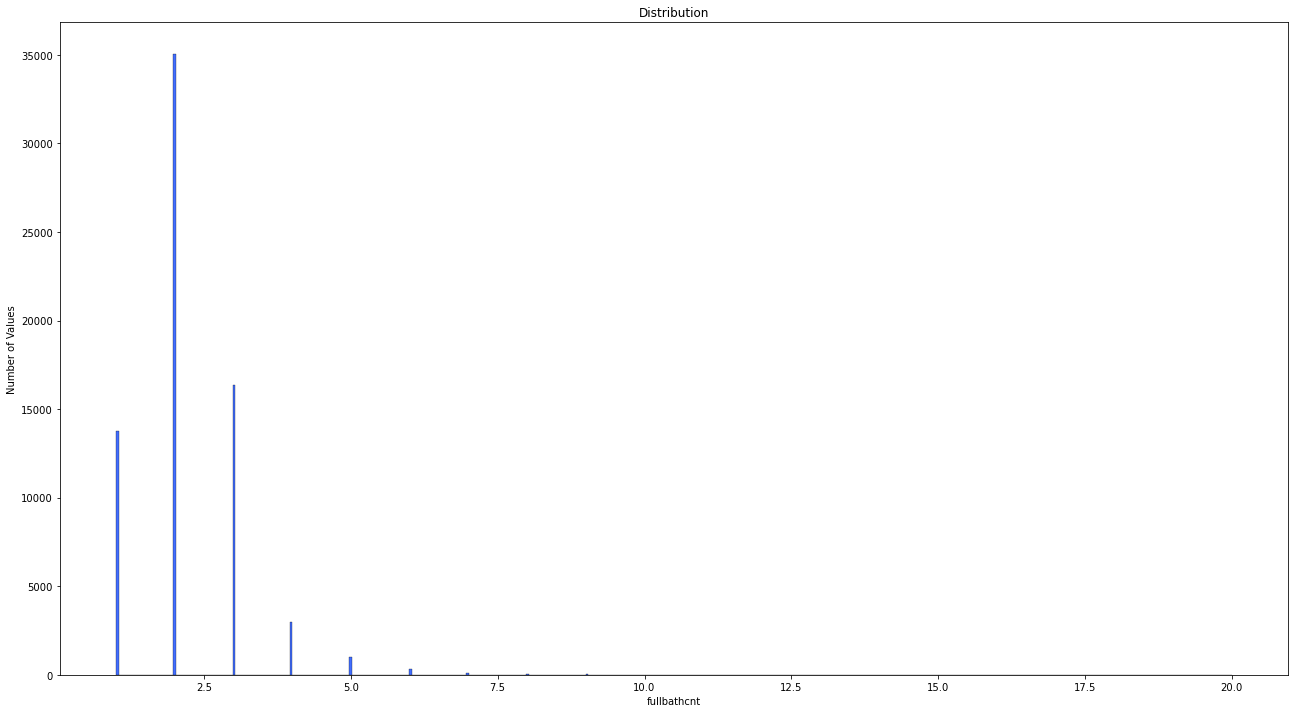

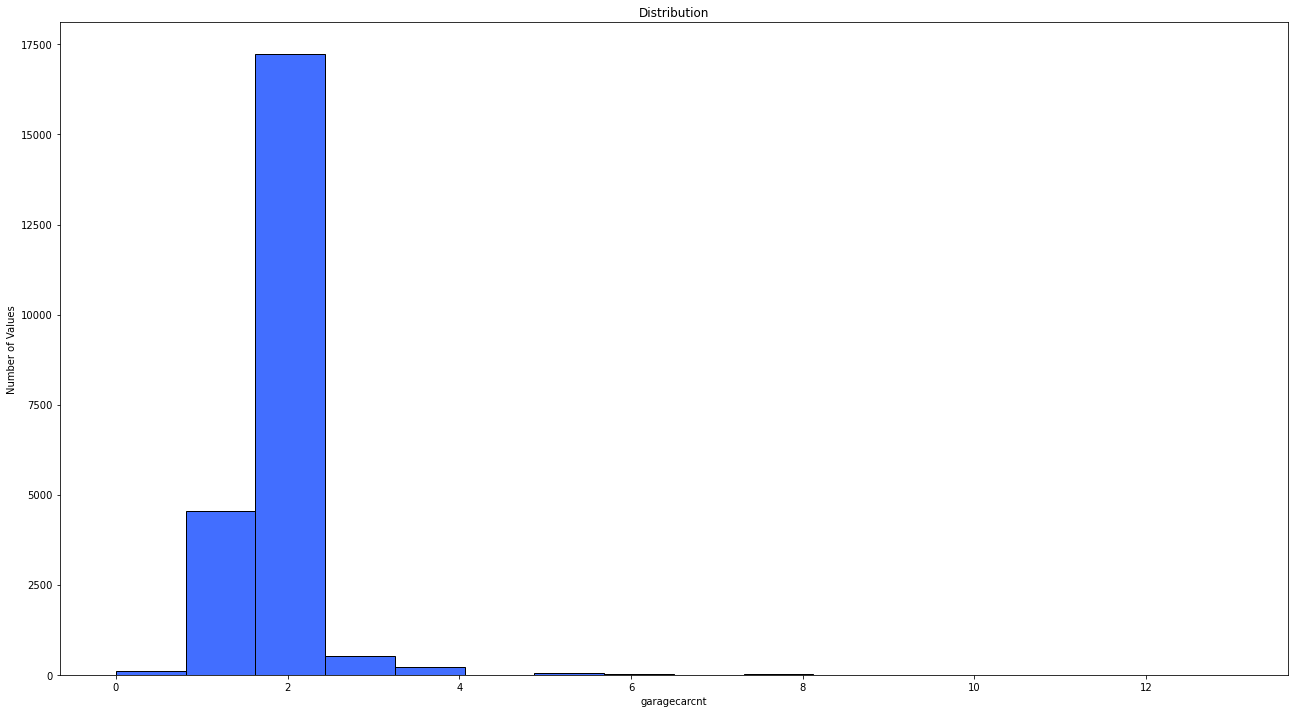

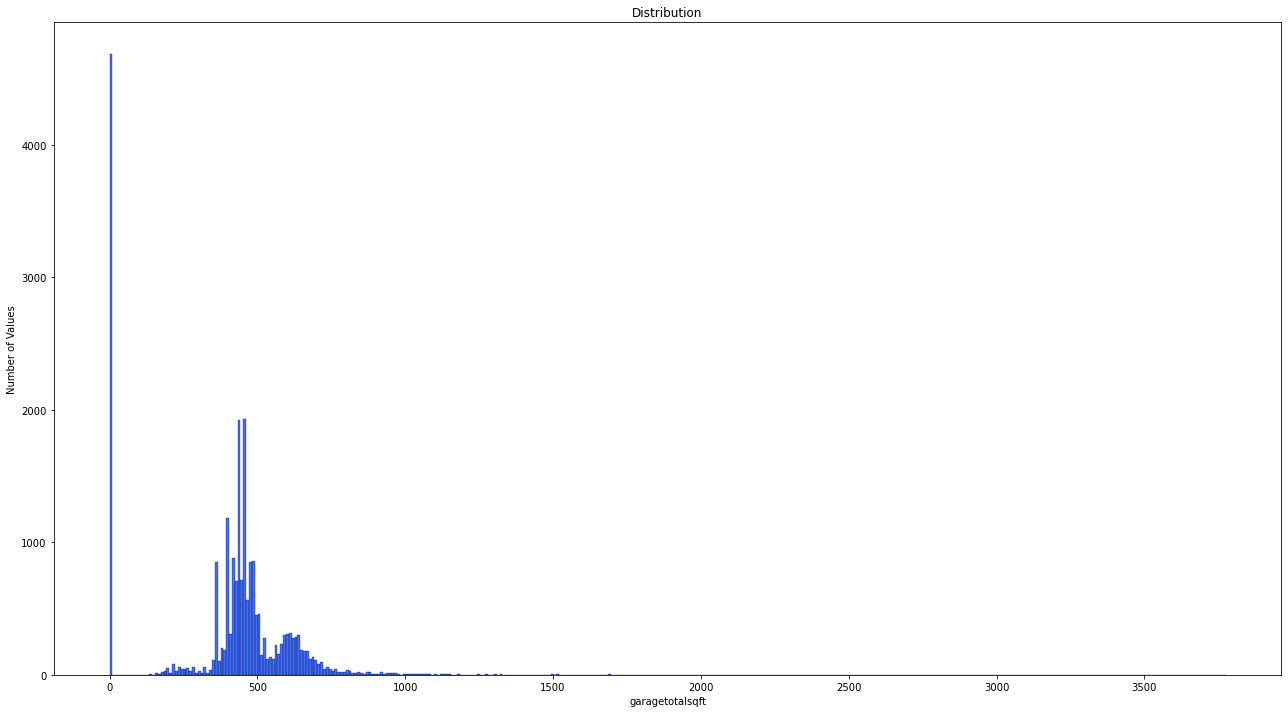

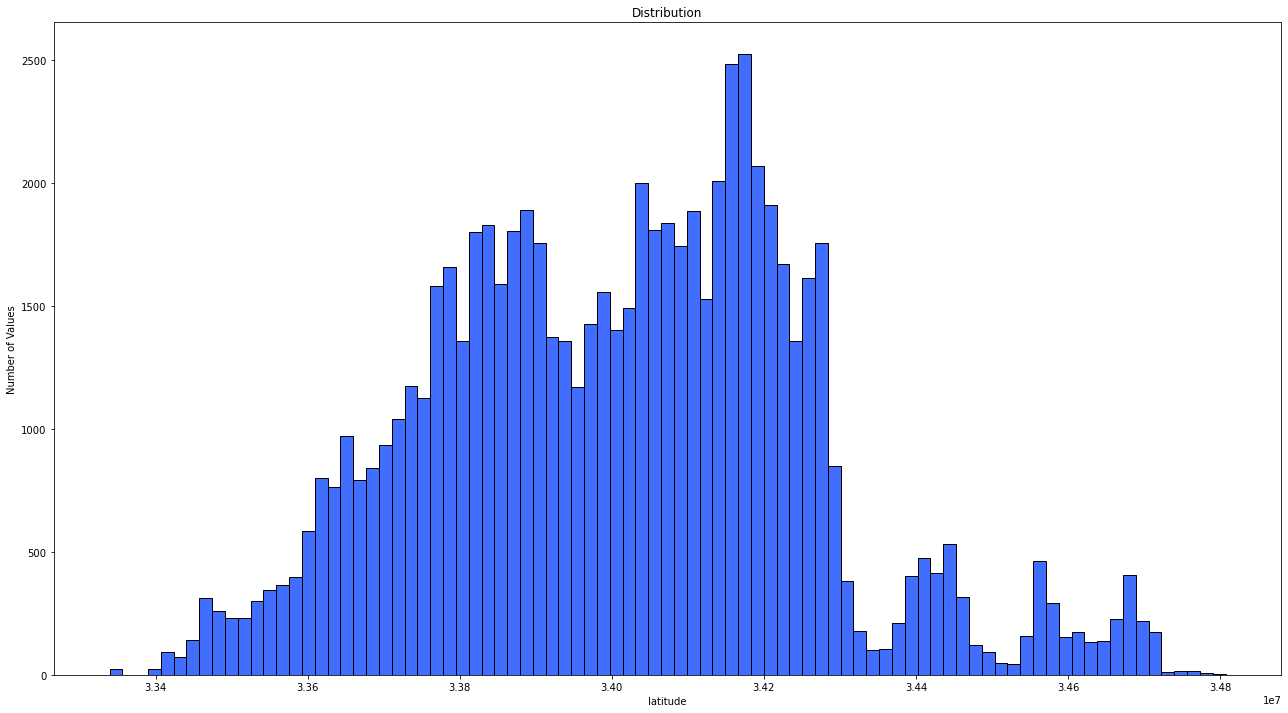

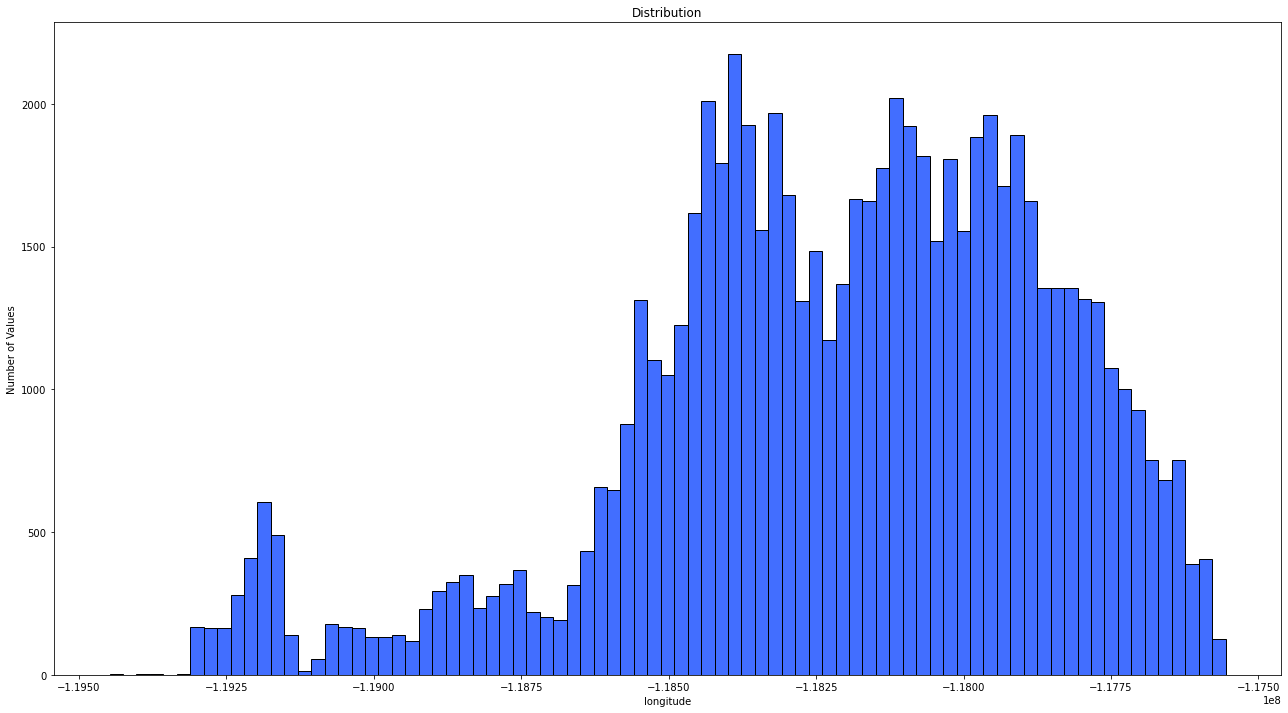

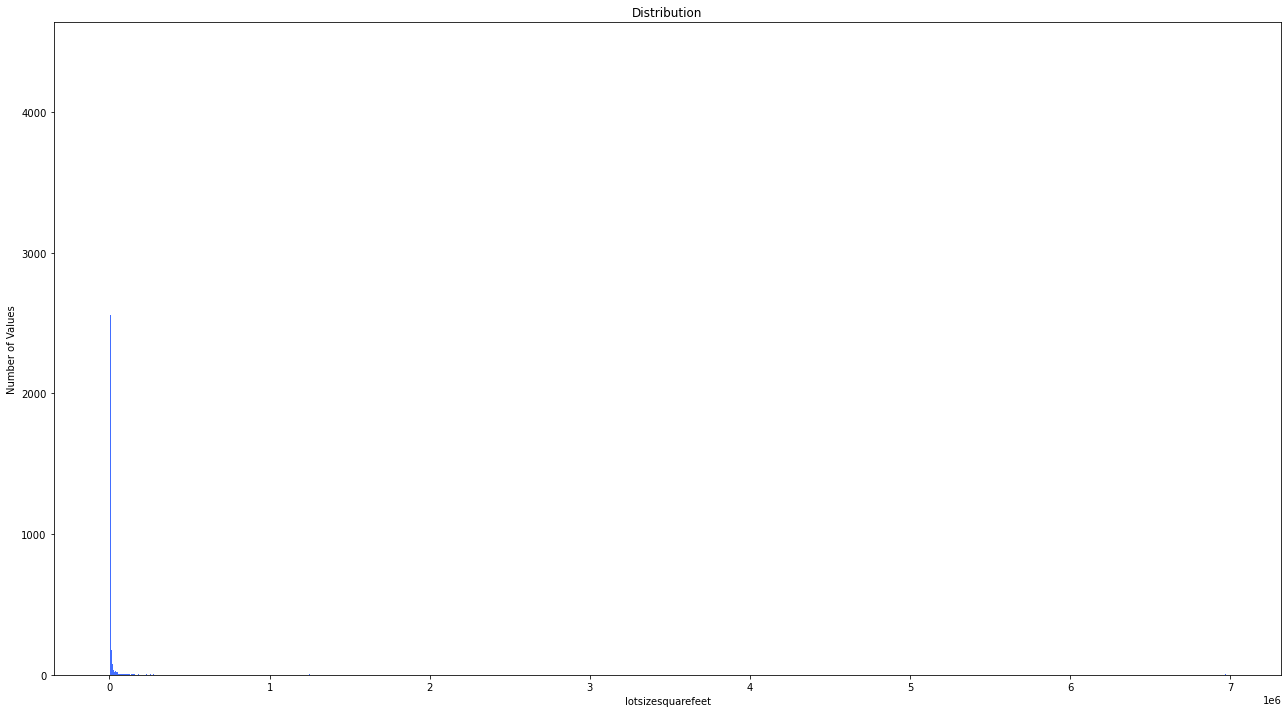

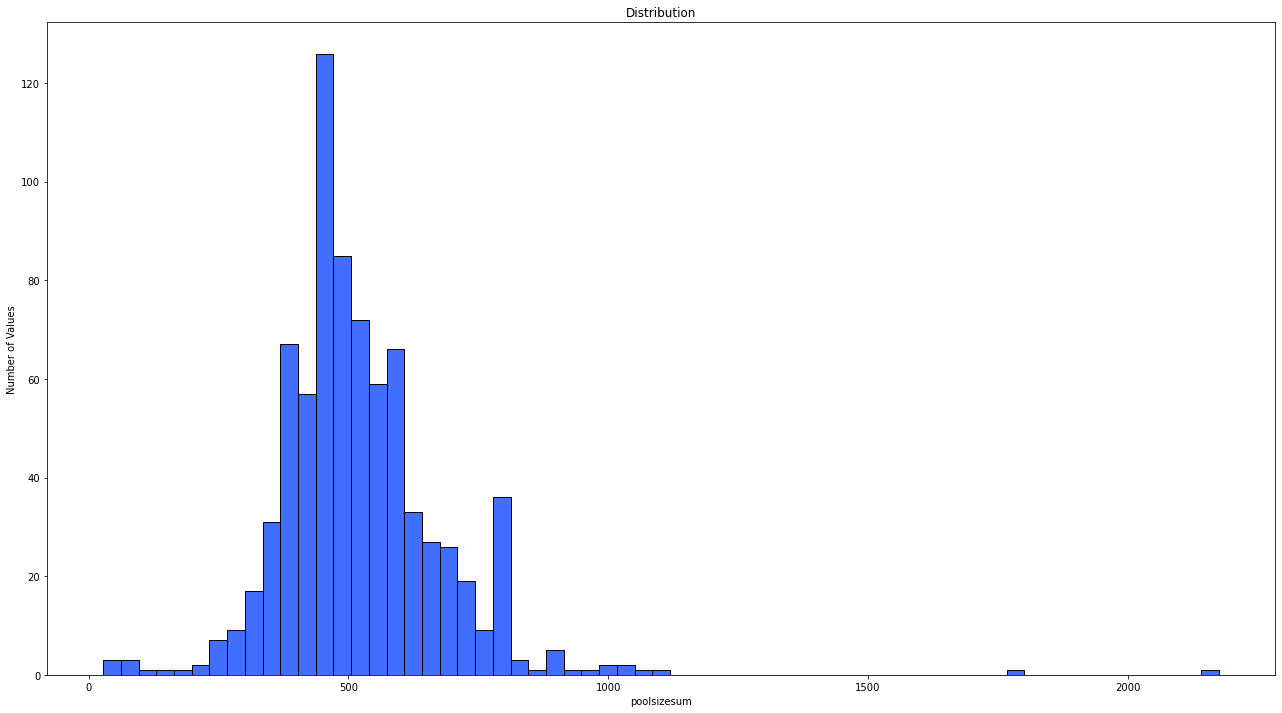

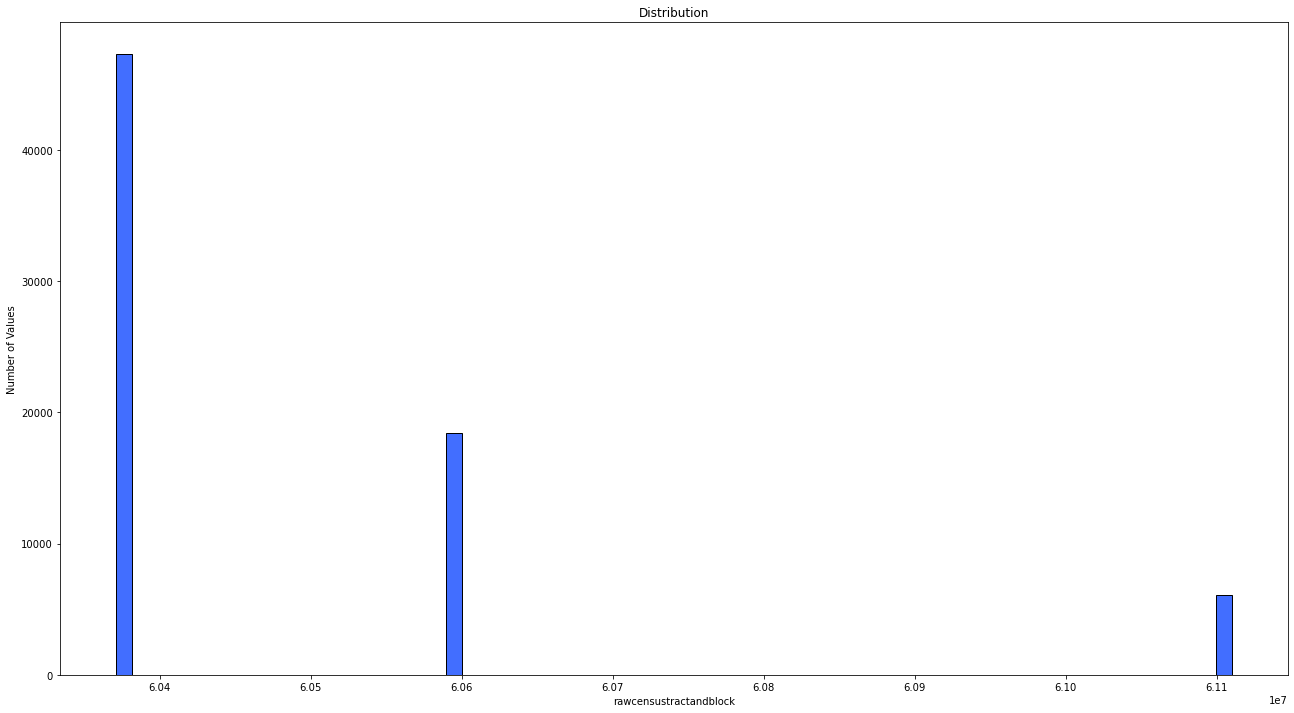

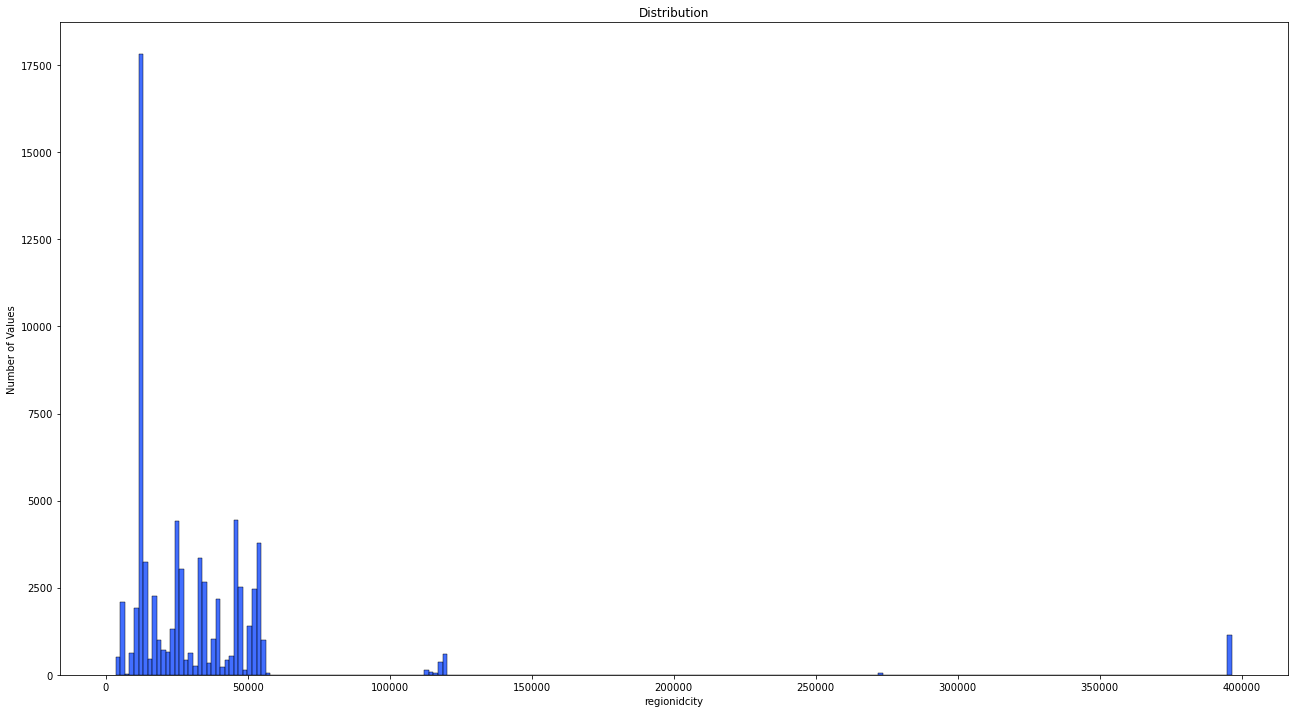

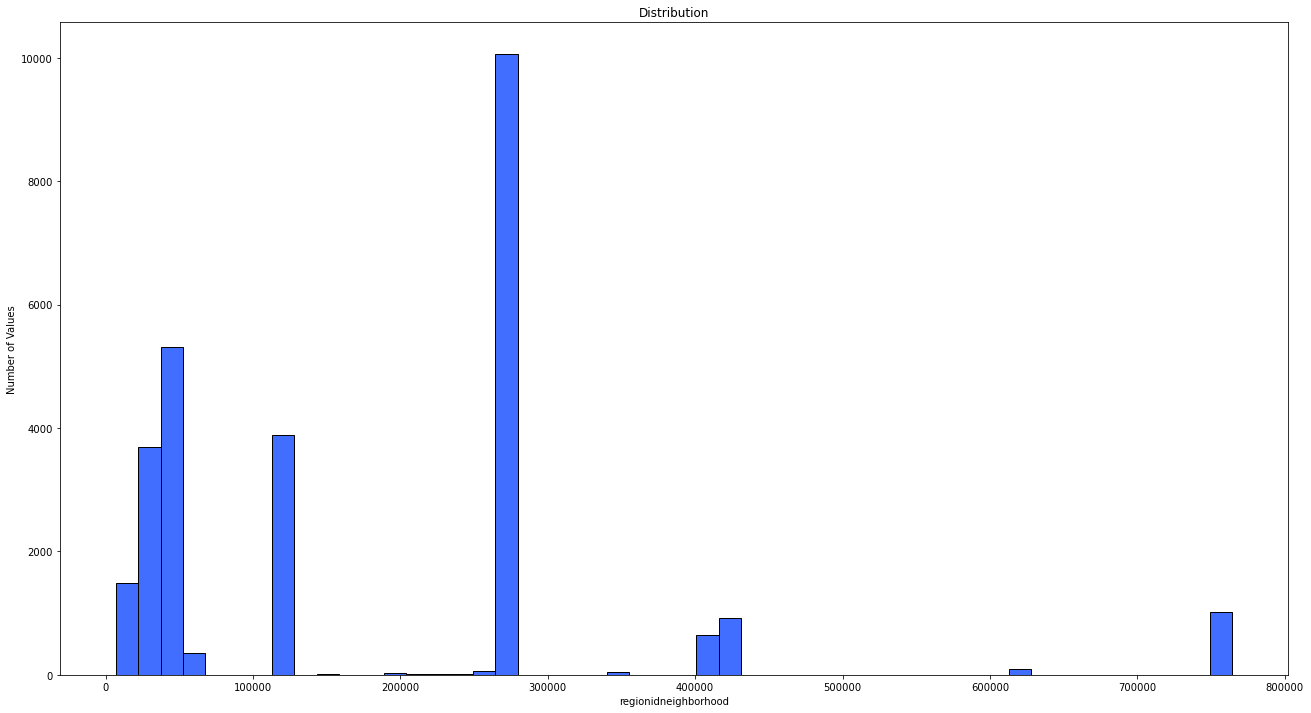

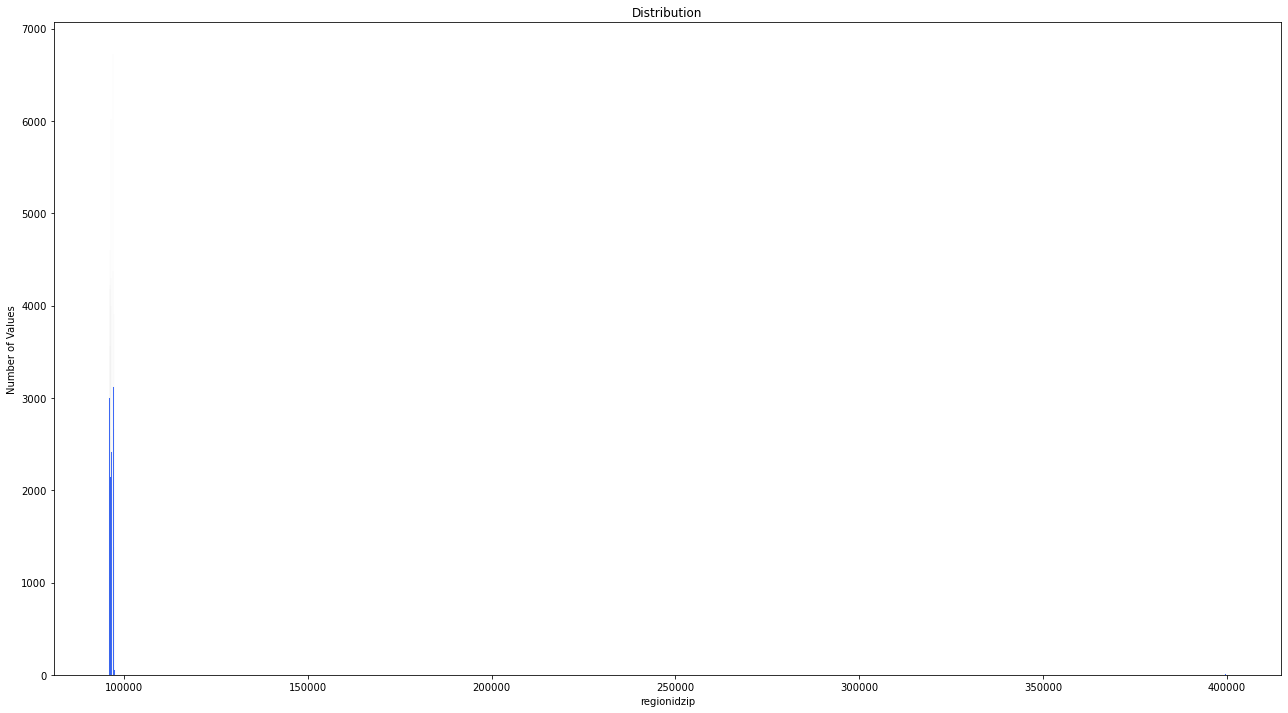

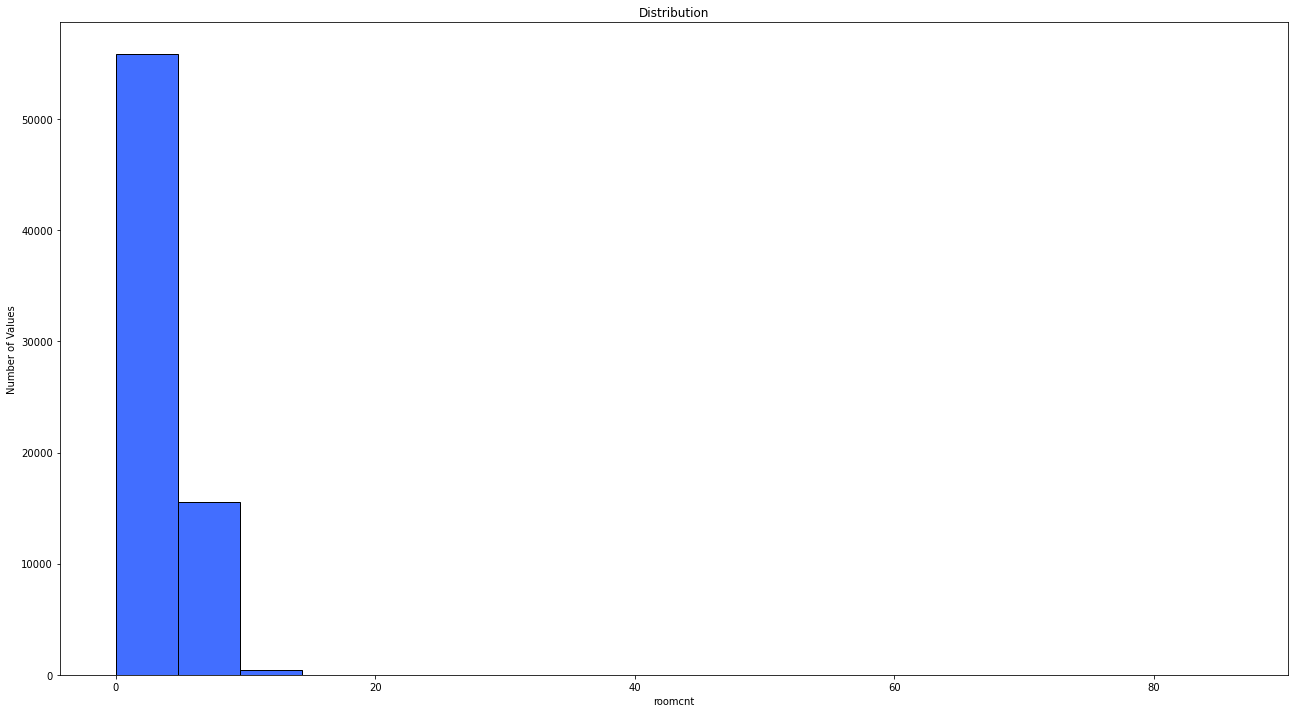

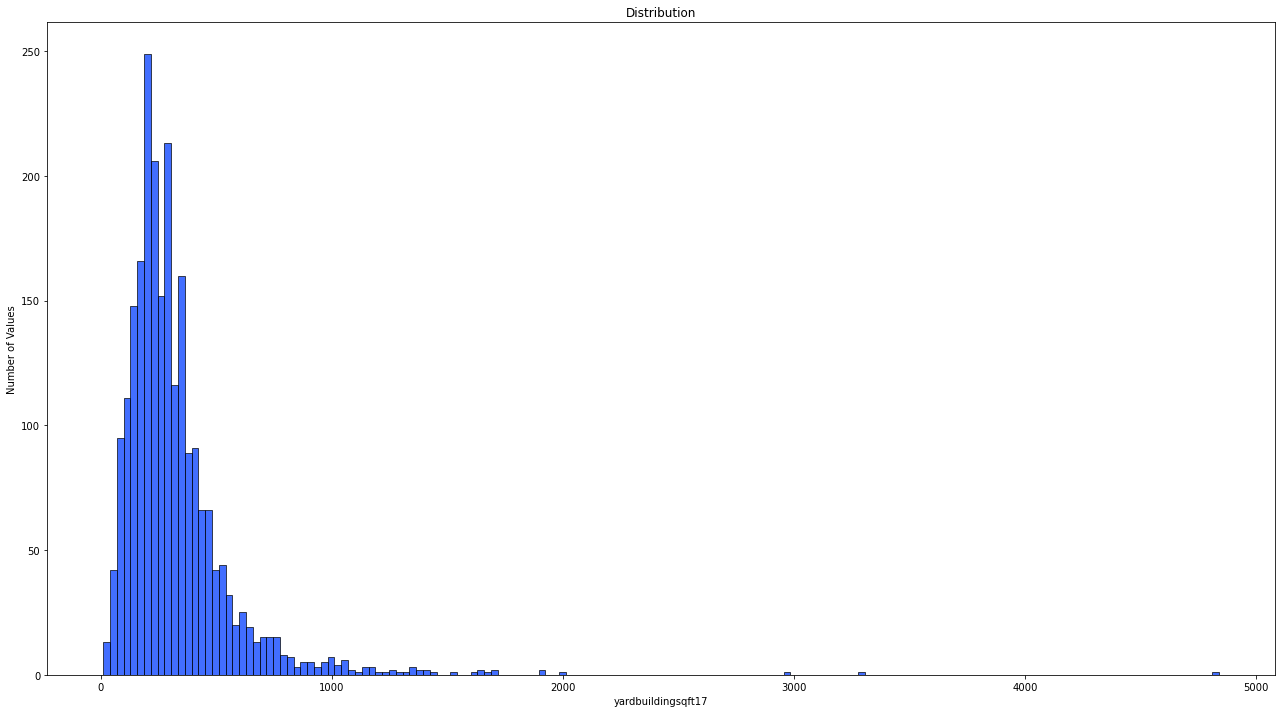

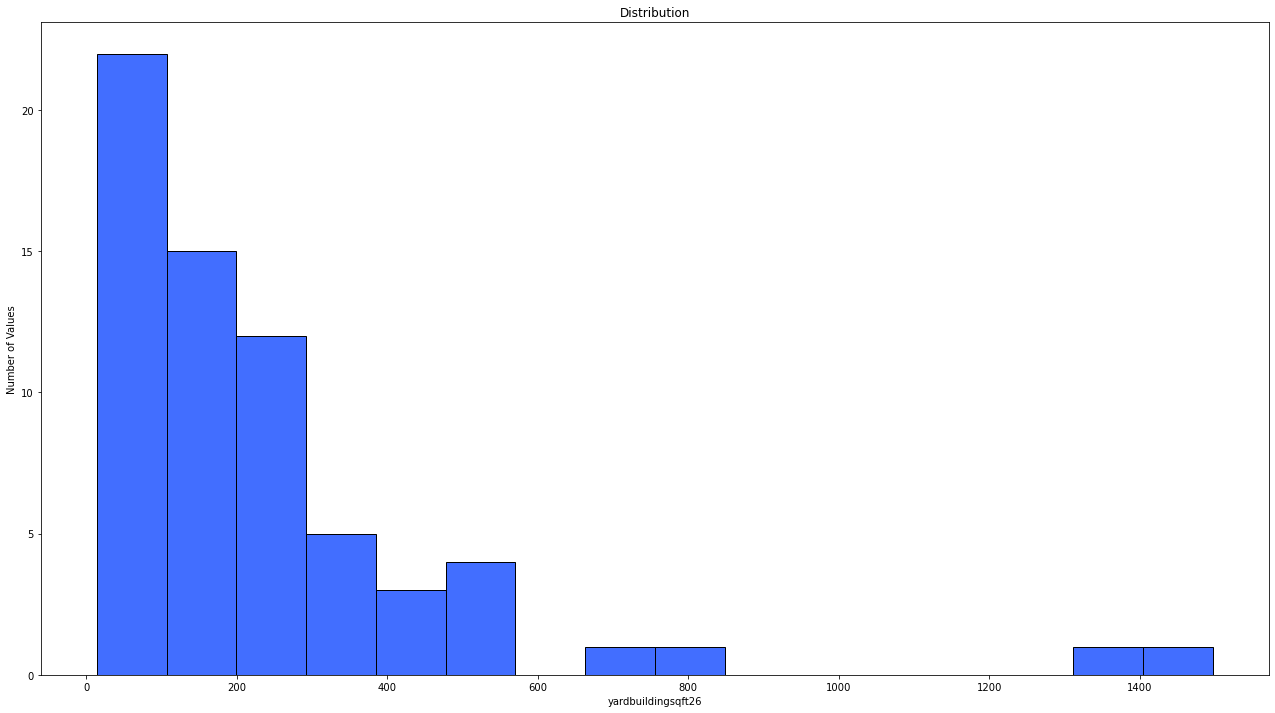

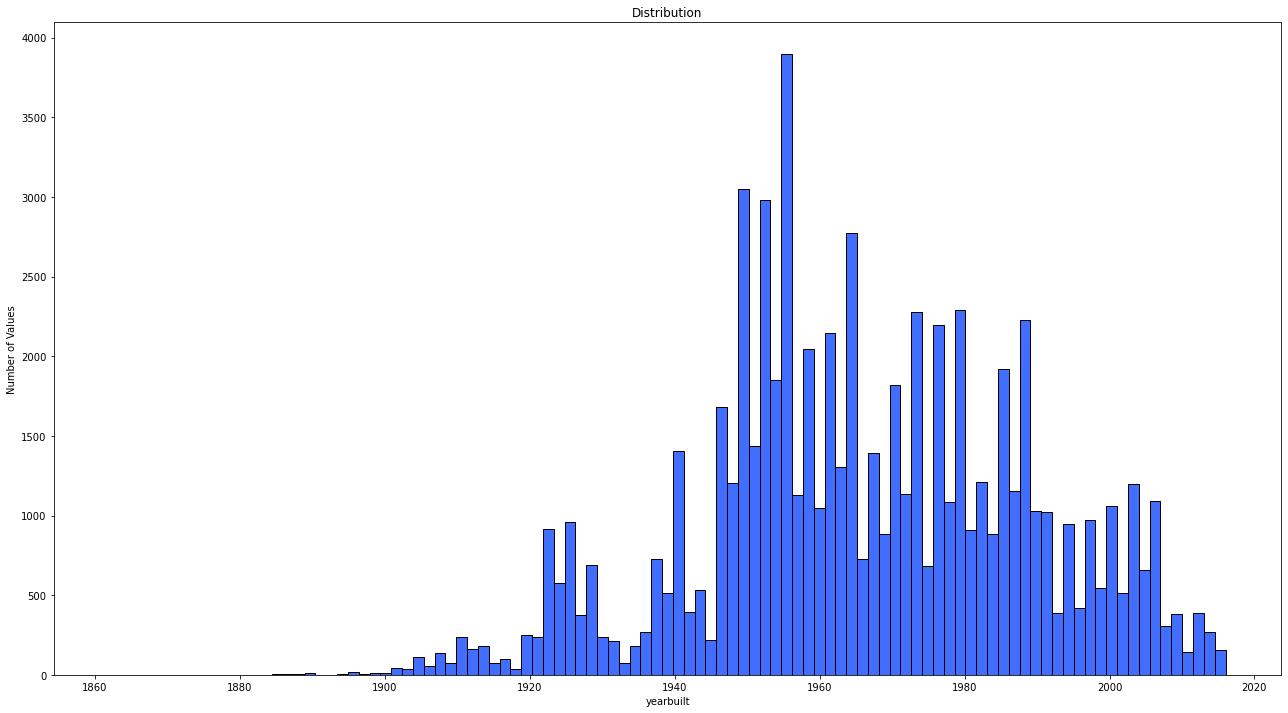

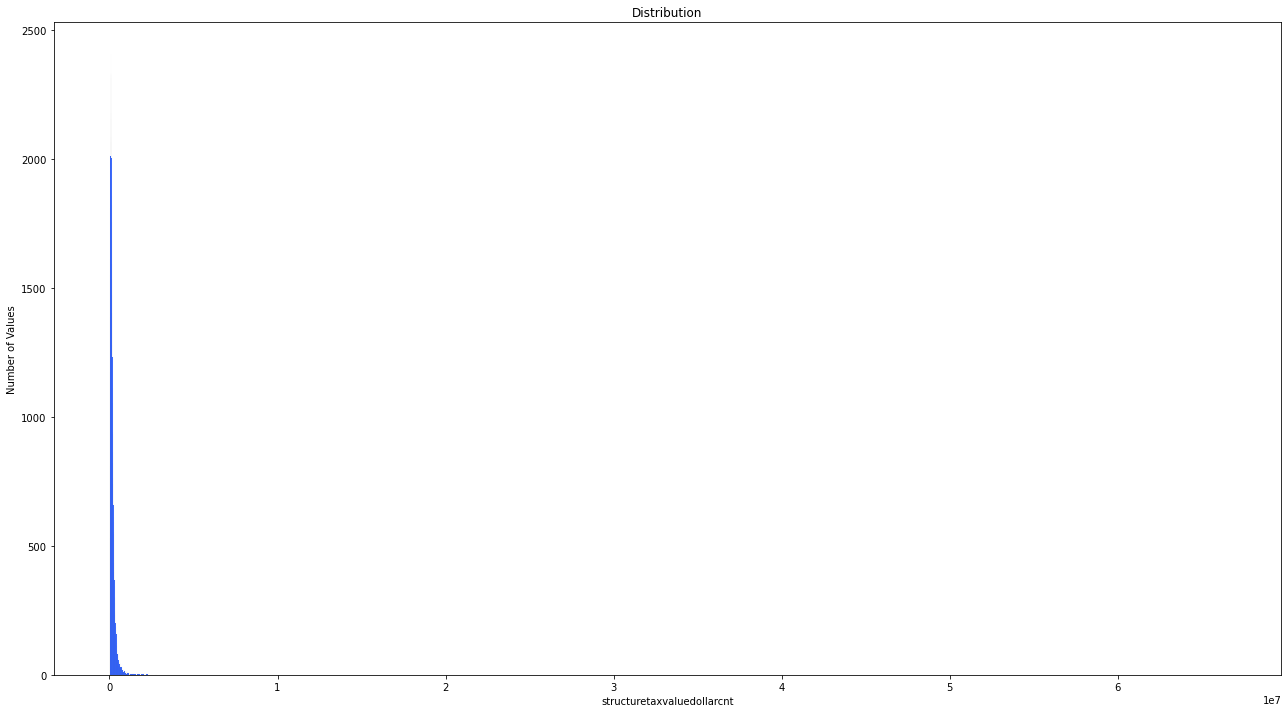

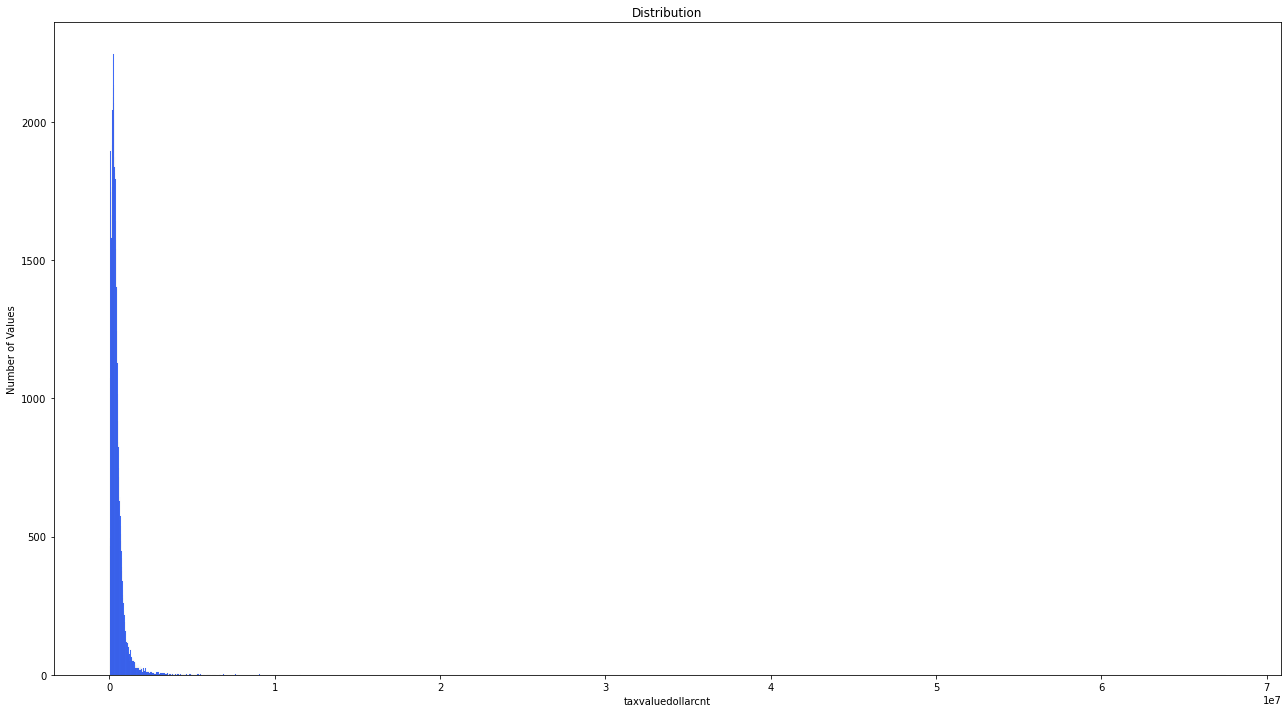

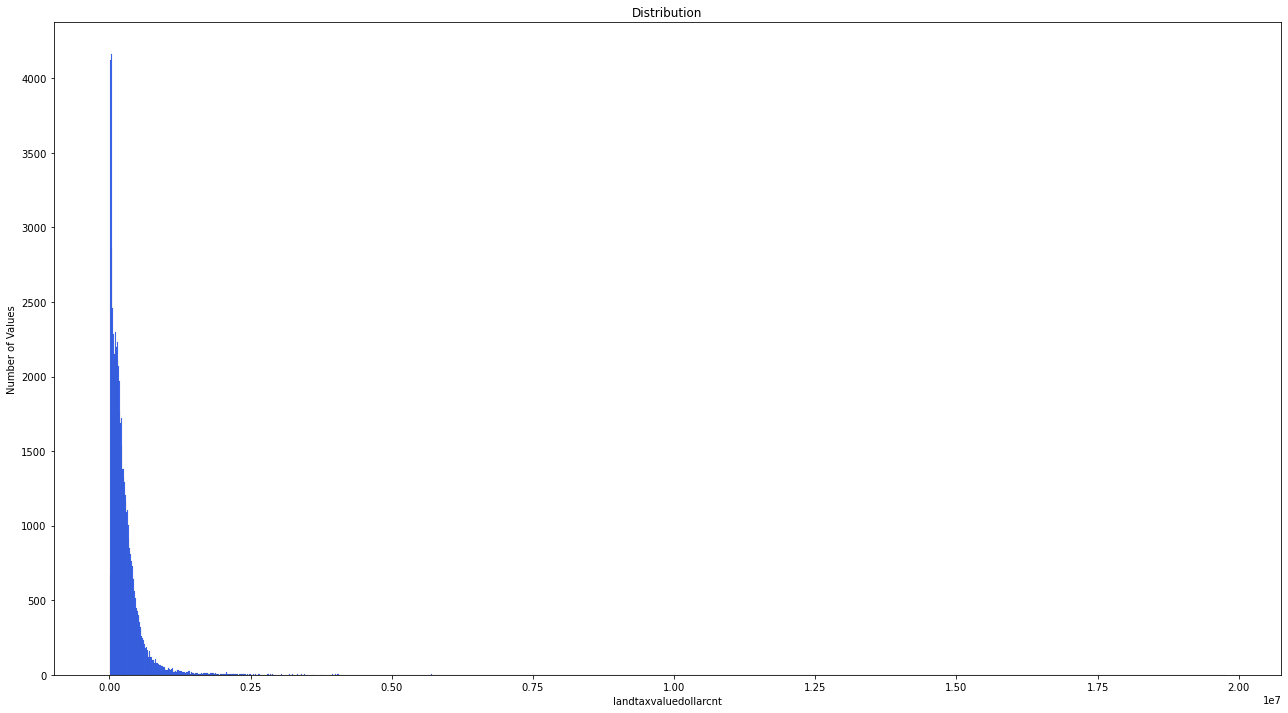

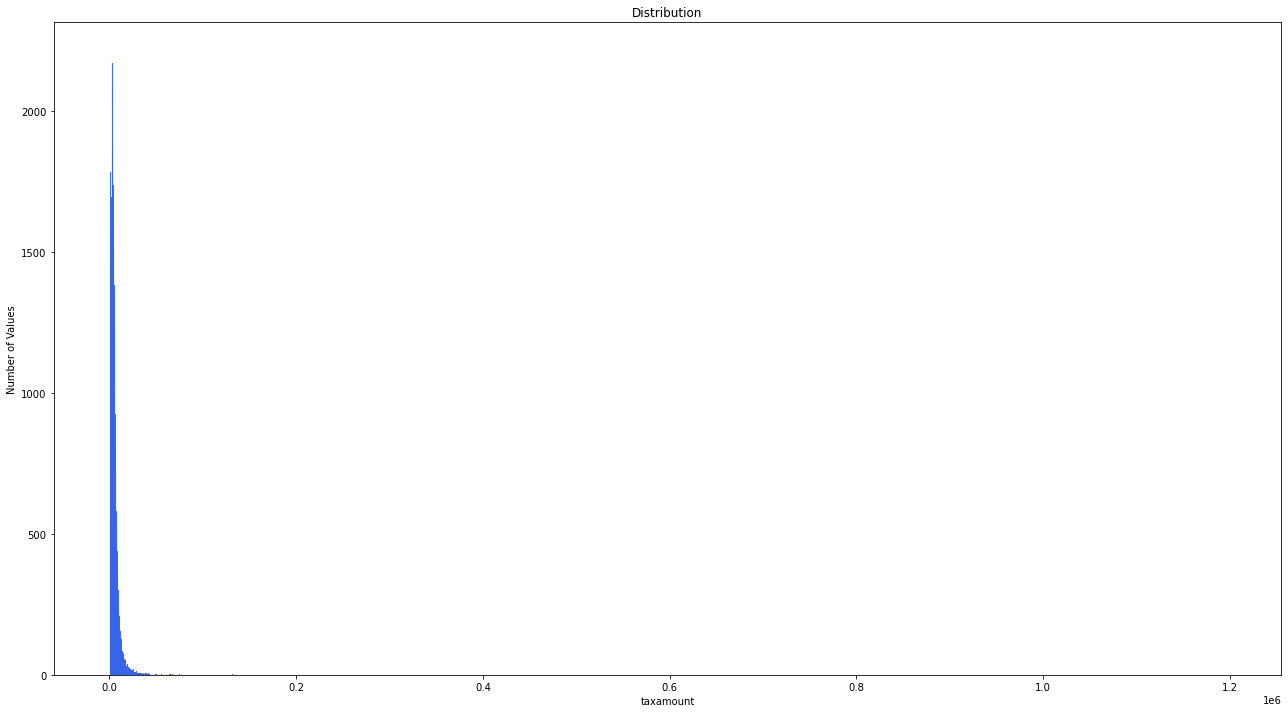

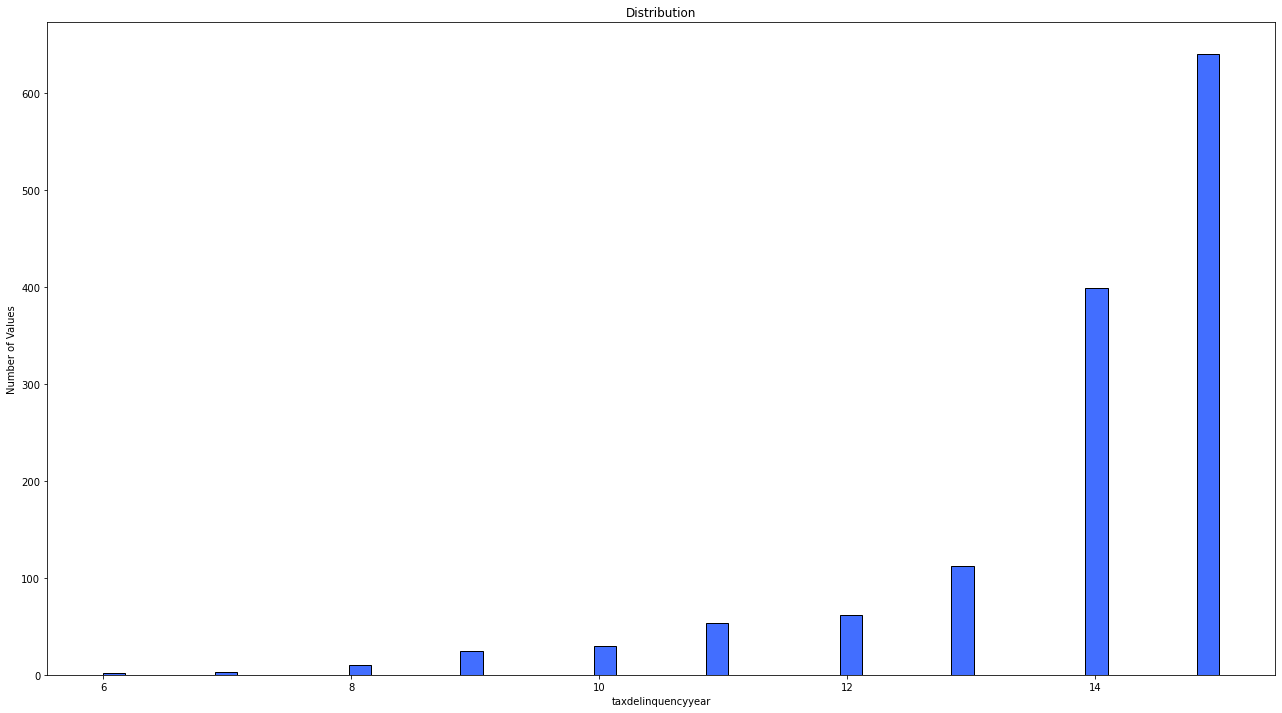

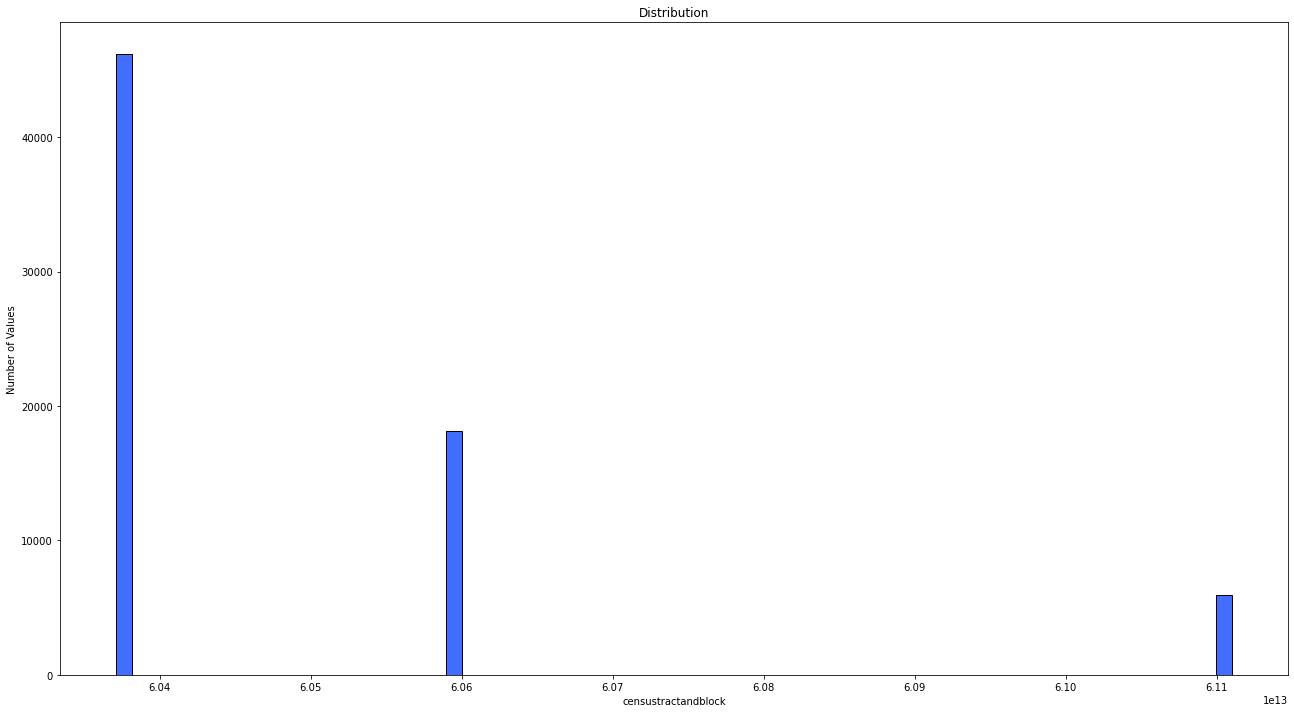

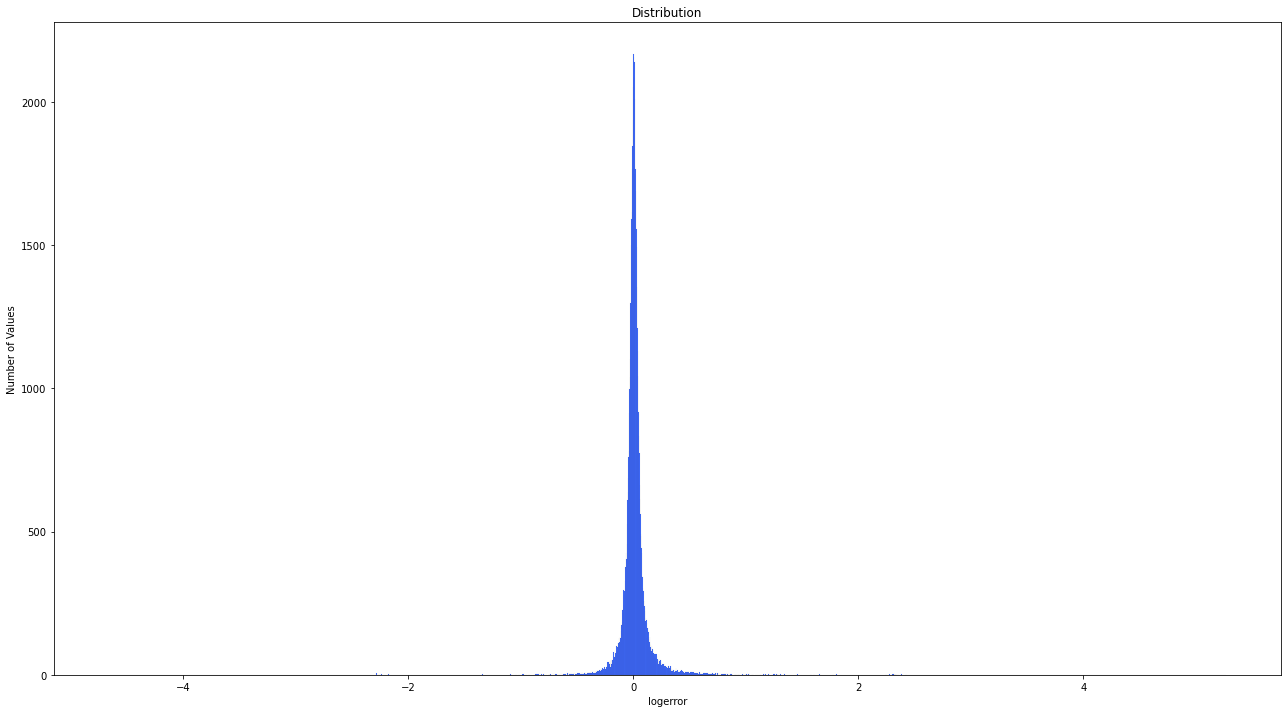

In [586]:
numeric_values_high_value_count(df)

<AxesSubplot:title={'center':'Value Counts'}, xlabel='typeconstructiondesc', ylabel='Number of Values'>

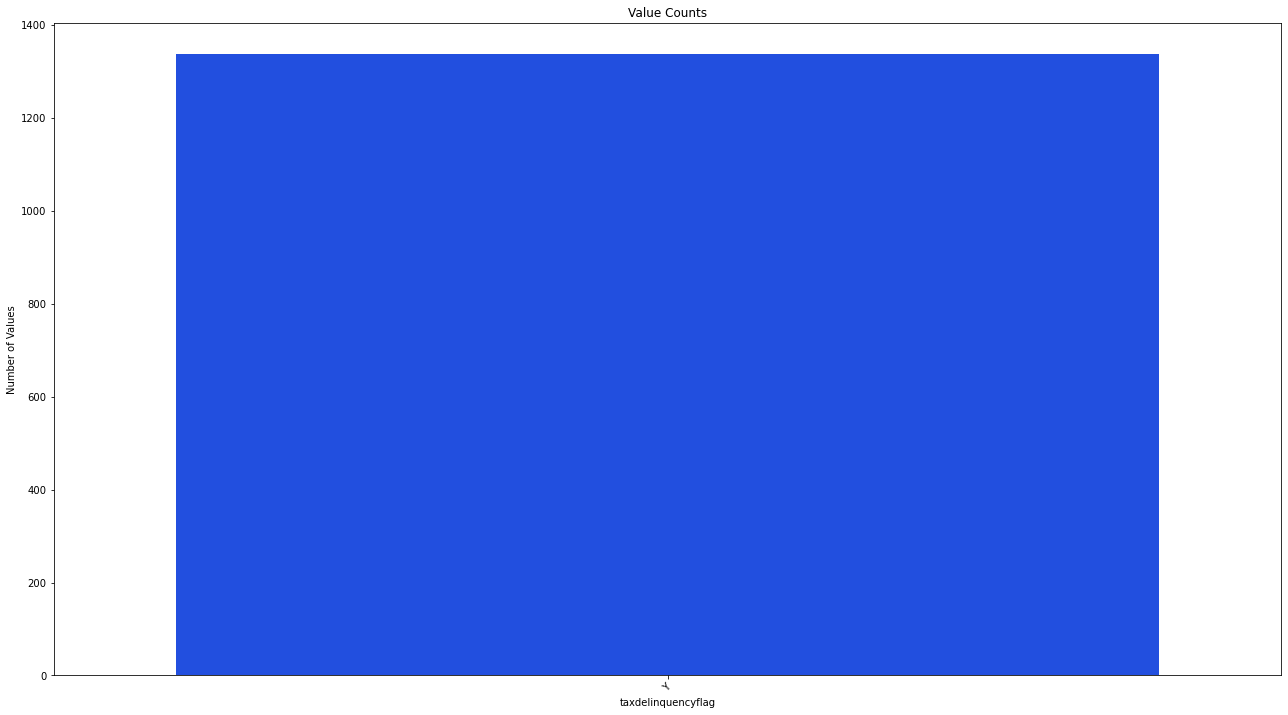

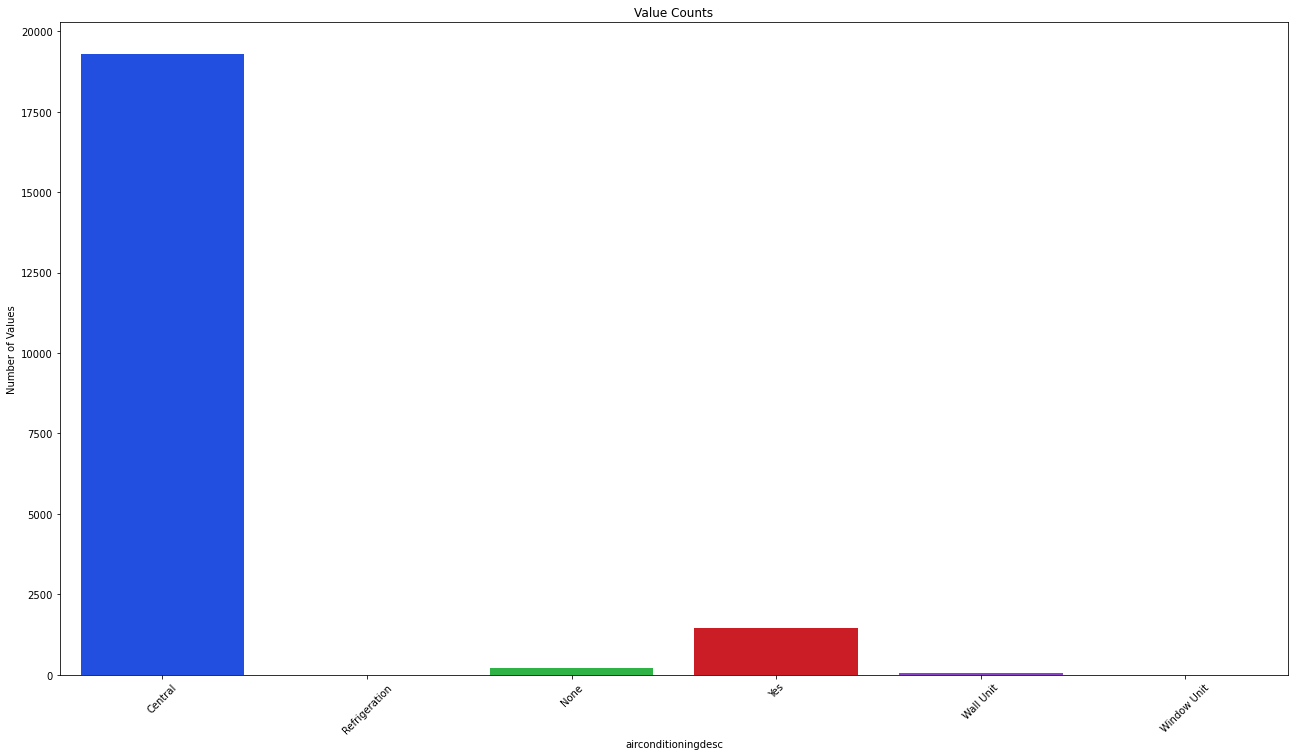

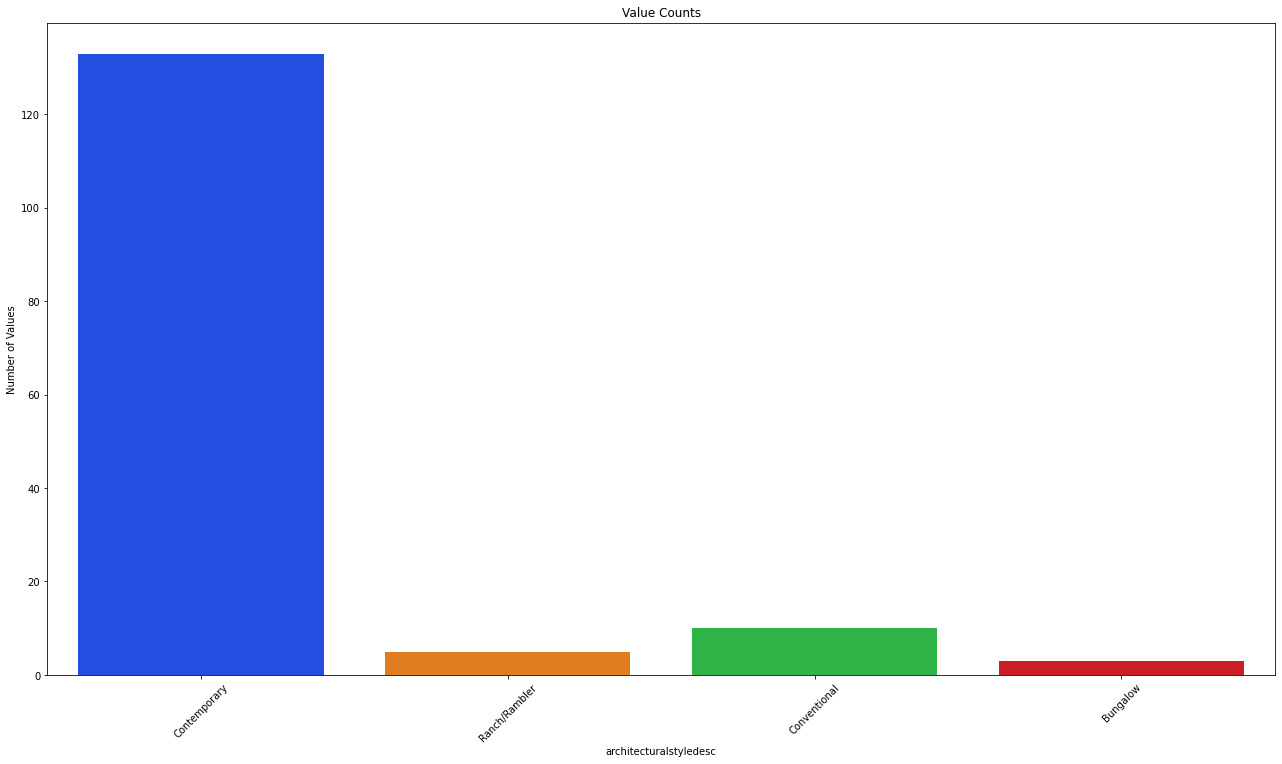

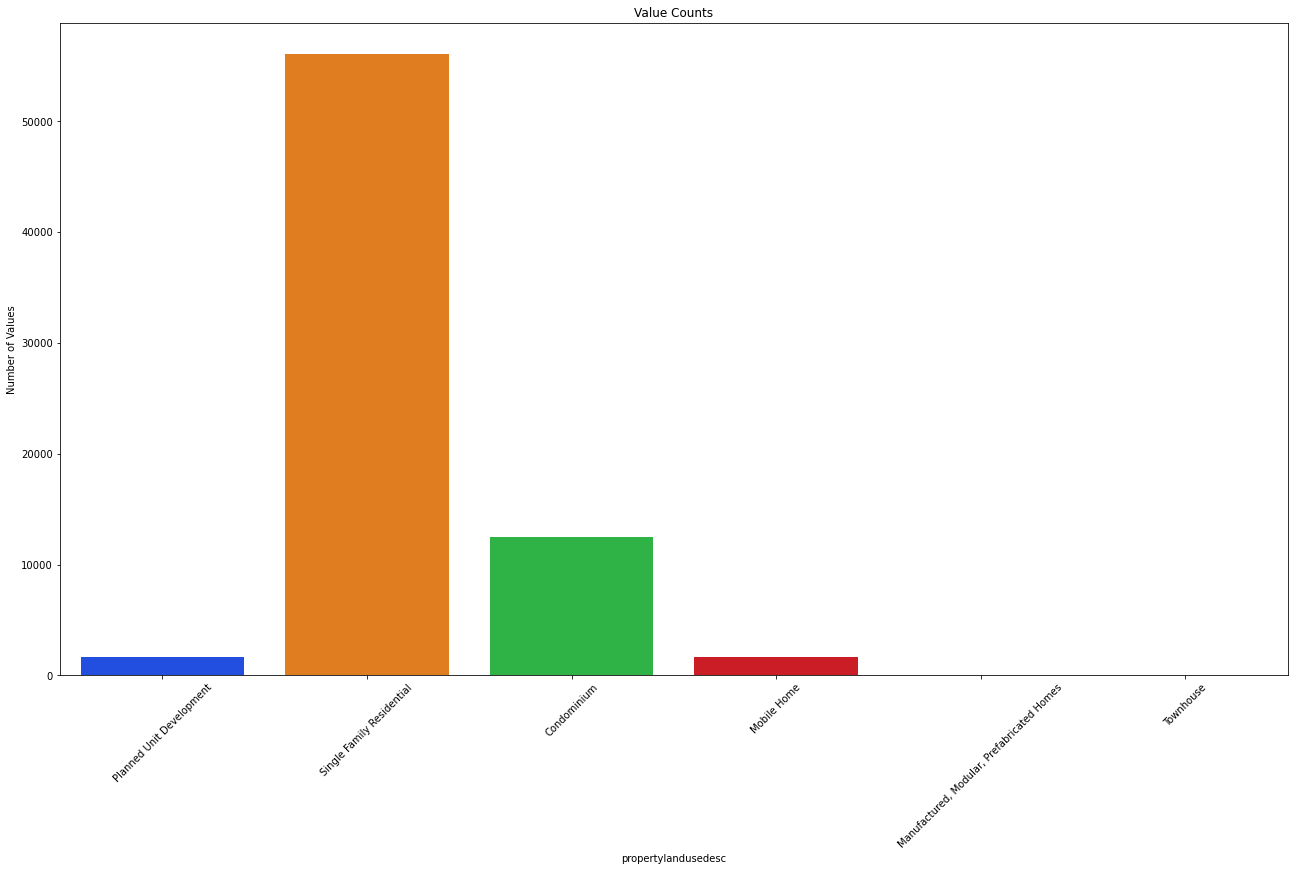

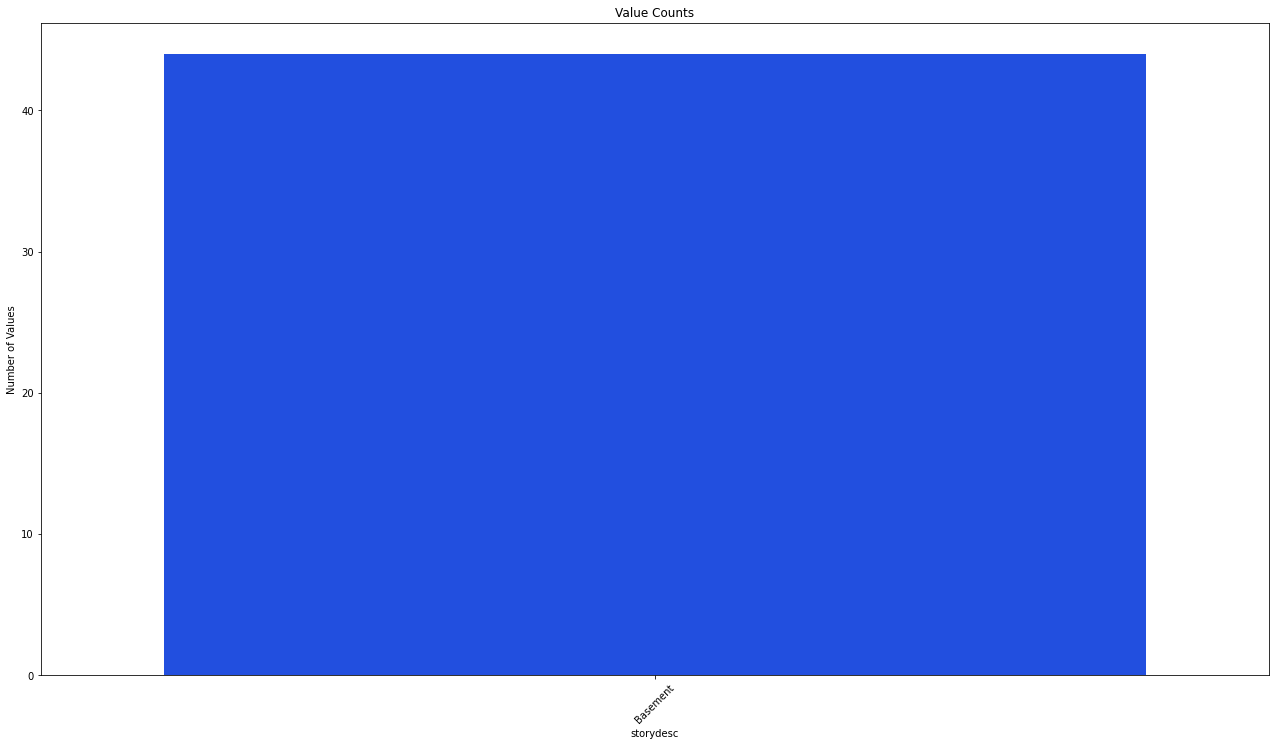

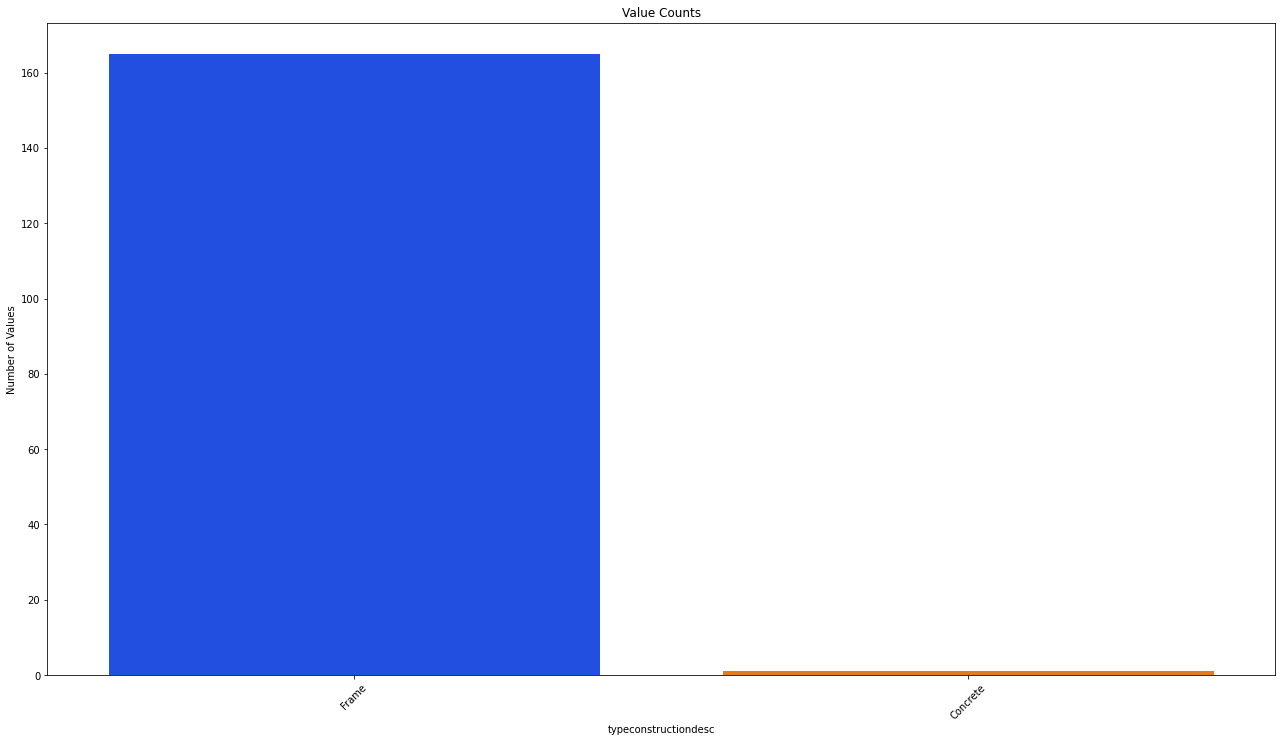

In [587]:
object_values_low_value_count(df)

We will visualize the following features individually. 

In [588]:
for col in df.columns:
    if df[col].dtype == object and len(df[col].unique()) >= 10:
        print(col)

propertycountylandusecode
propertyzoningdesc
heatingorsystemdesc
transactiondate
last_trans_date


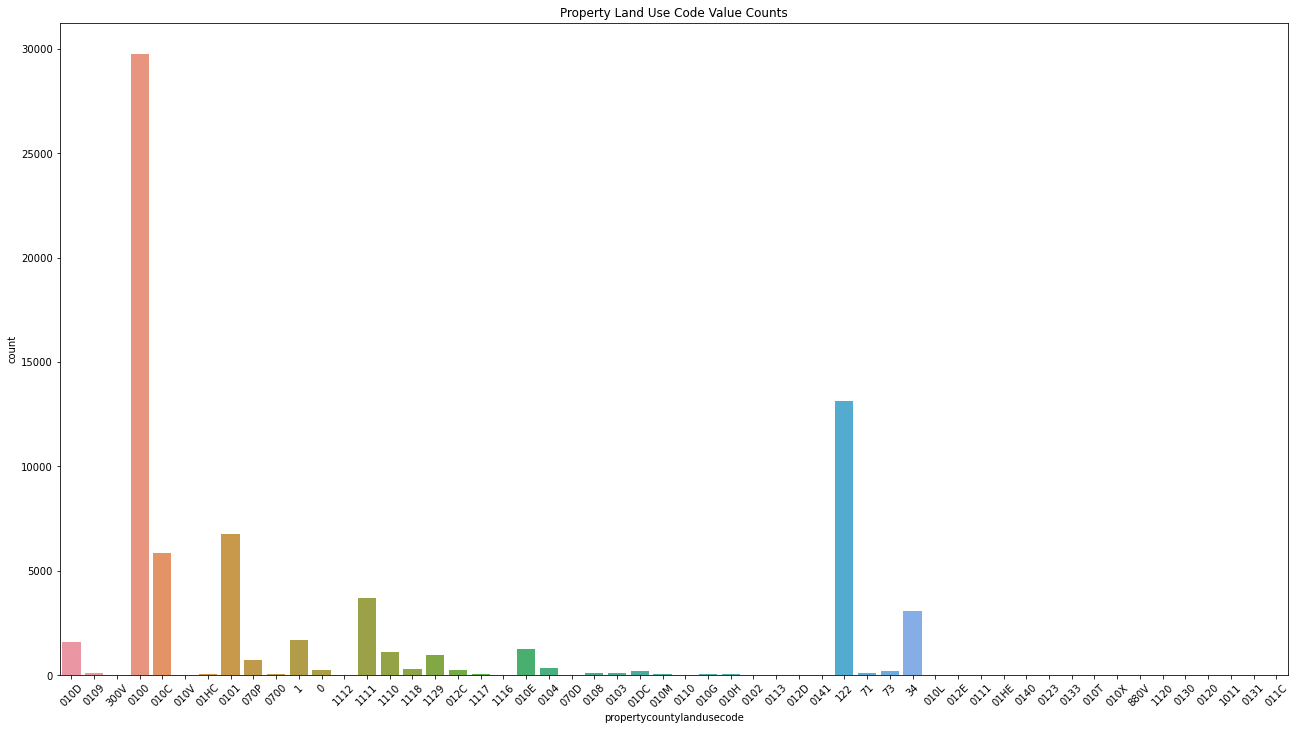

In [589]:
plt.figure(figsize=(22, 12))
landusecode = sns.countplot(x = df.propertycountylandusecode, data = df)
x_ticks = plt.xticks(rotation = 45)
title = landusecode.set(Title = "Property Land Use Code Value Counts")

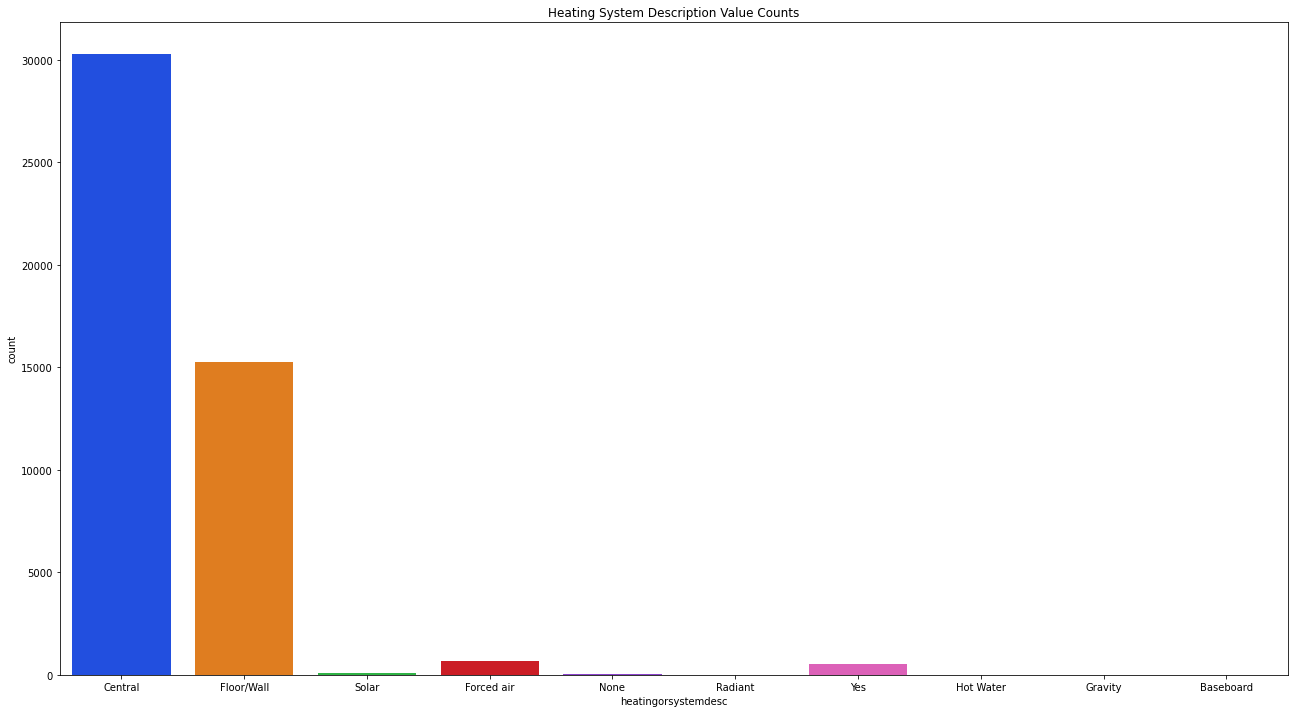

In [590]:
plt.figure(figsize=(22, 12))
heating = sns.countplot(x = df.heatingorsystemdesc, data = df)
title = heating.set(Title = "Heating System Description Value Counts")

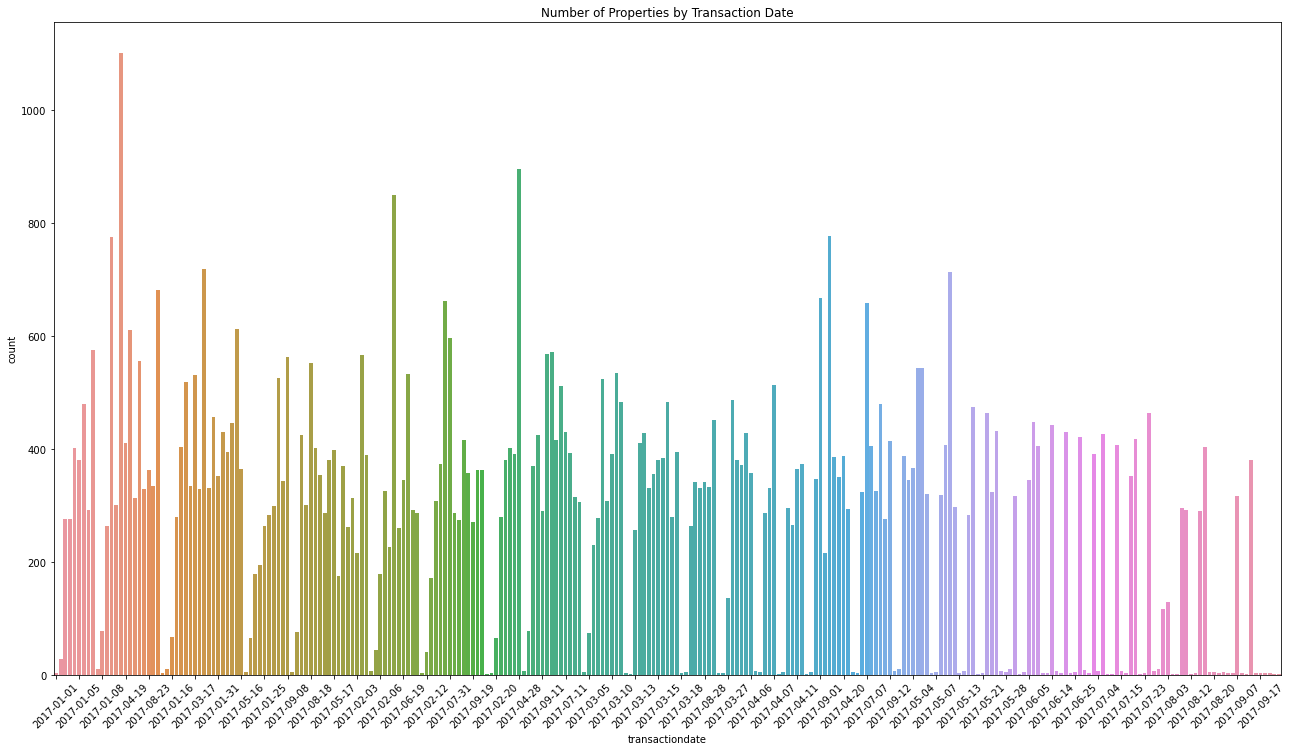

In [591]:
plt.figure(figsize=(22, 12))
transaction = sns.countplot(x = df.transactiondate, data = df.sample(1000))
x_ticks = plt.xticks(rotation = 45)
labels = transaction.set_xticks(transaction.get_xticks()[::5])
title = transaction.set(title ="Number of Properties by Transaction Date")

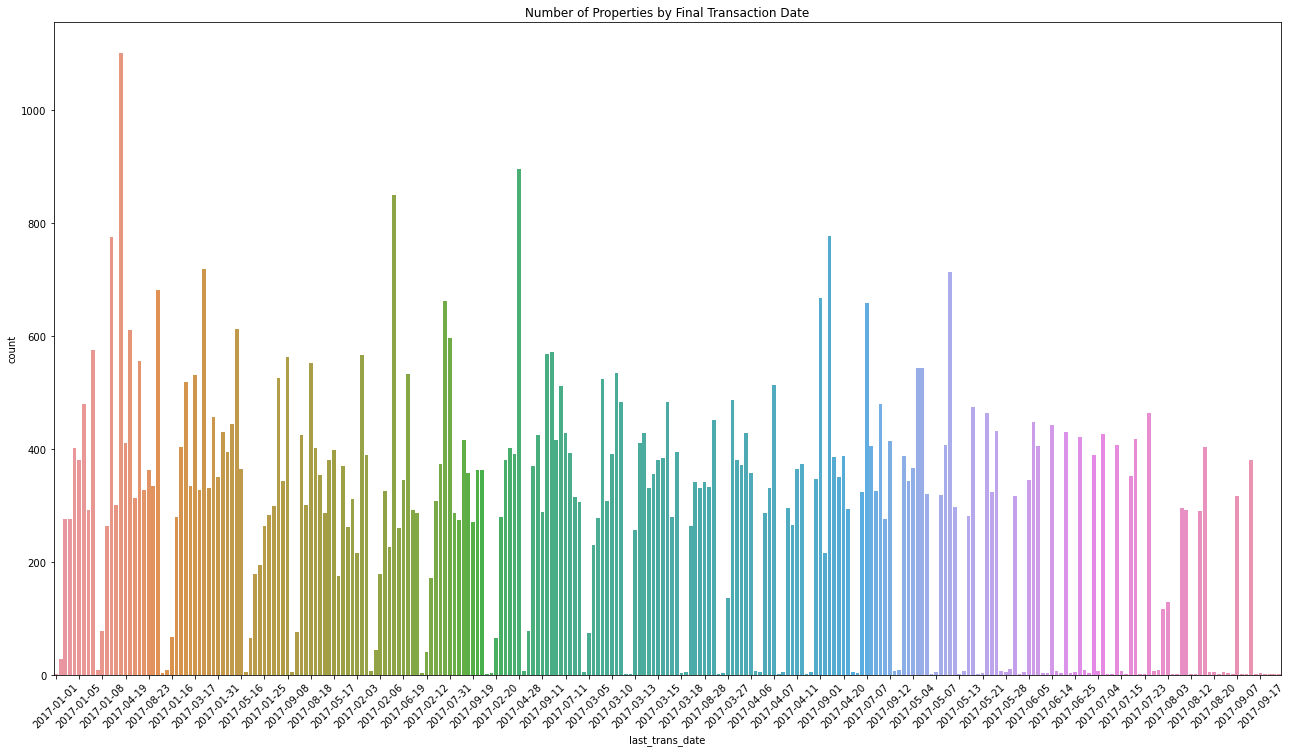

In [592]:
plt.figure(figsize=(22, 12))
last_transaction = sns.countplot(x = df.last_trans_date, data = df.sample(1000))
x_ticks = plt.xticks(rotation = 45)
labels = last_transaction.set_xticks(last_transaction.get_xticks()[::5])
title = last_transaction.set(title = "Number of Properties by Final Transaction Date")

# Prepare Data

Now we will clean and prepare our data. I will use the `prepare_data` function from the `prepare.py` in this repository. This function:
 - eliminates columns which have over 50% null values, 
 - eliminates rows which have over 75% null values, and 
 - replaces the remaining null values with the most frequent value for that column.

For more information about the `prepare_data` function, please see the `prepare.py` file.

**Note** 

I have chosen not to drop outliers in this prepare section. The purpose of this project is to determine which features have the greatest level of error in the property value estimate. I predict that the more elite the property (the higher the bedroom count, the higher the bathroom count, the higher the tax assessed value), the more error we will see in predicting the property value. This is because wealthy home buyers can overbid on homes that are in their market. 

In notebook titled `Scratch_Notebook` in this repository, I ran stastical testing on the data after removing outliers. The result of data with no outliers was that none of the features in our DataFrame were predictive of error in the Zestimate. I hypothesize that the error in our model for predicting Zestimate lies precisely in our inability to predict the value of outliers.

I believe that for the purposes of this project, it makes sense to include expensive, elite homes because these expensive homes are likely where we will see the greatest error in the zestimate of the property value.

## Prepare Data Function

In [4]:
df = prepare_data(df)

## Sample of the Prepared DataFrame

In [594]:
df.head()

,index,propertylandusetypeid,id,heatingorsystemtypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,heatingorsystemdesc,logerror,transactiondate,last_trans_date,propertylandusedesc
3,10,269.0,10,2.0,11070347,4.0,4.0,1.0,4.0,3095.0,...,192544.0,2016.0,53784.0,2460.72,6.037920e+13,Central,0.005963,2017-01-02,2017-01-02,Planned Unit Development
10,20,261.0,20,2.0,11324547,2.0,4.0,8.0,2.0,3633.0,...,296425.0,2016.0,74104.0,6941.39,6.037920e+13,Central,0.042463,2017-01-02,2017-01-02,Single Family Residential
12,30,266.0,30,2.0,11524947,2.0,2.0,7.0,2.0,1090.0,...,357568.0,2016.0,124671.0,6165.36,6.037920e+13,Central,0.021853,2017-01-02,2017-01-02,Condominium
13,31,261.0,31,2.0,11544747,4.0,3.0,11.0,4.0,1620.0,...,847770.0,2016.0,508238.0,10244.94,6.037920e+13,Central,-0.019546,2017-01-02,2017-01-02,Single Family Residential
14,33,261.0,33,2.0,11585547,2.0,3.0,8.0,2.0,2077.0,...,646760.0,2016.0,436568.0,7924.68,6.037920e+13,Central,-0.040807,2017-01-02,2017-01-02,Single Family Residential


## Prepared DataFrame Information

In [595]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69957 entries, 3 to 71904
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   index                         69957 non-null  int64  
 1   propertylandusetypeid         69957 non-null  float64
 2   id                            69957 non-null  int64  
 3   heatingorsystemtypeid         69957 non-null  float64
 4   parcelid                      69957 non-null  int64  
 5   bathroomcnt                   69957 non-null  float64
 6   bedroomcnt                    69957 non-null  float64
 7   buildingqualitytypeid         69957 non-null  float64
 8   calculatedbathnbr             69957 non-null  float64
 9   calculatedfinishedsquarefeet  69957 non-null  float64
 10  finishedsquarefeet12          69957 non-null  float64
 11  fips                          69957 non-null  float64
 12  fullbathcnt                   69957 non-null  float64
 13  l

## Describe Prepared Data

In [596]:
df.describe()

,index,propertylandusetypeid,id,heatingorsystemtypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror
count,69957.000000,69957.000000,69957.000000,69957.000000,6.995700e+04,69957.000000,69957.000000,69957.000000,69957.000000,69957.000000,...,69957.000000,69957.000000,69957.000000,6.995700e+04,6.995700e+04,69957.000000,6.995700e+04,69957.000000,6.995700e+04,69957.000000
mean,38970.919765,262.073960,38970.919765,3.319353,1.319741e+07,2.254621,3.117143,6.288248,2.260467,1772.817745,...,1.633103,1.000743,1965.983947,1.772201e+05,4.404596e+05,2015.998971,2.633455e+05,5372.114817,6.048869e+13,0.016913
std,22371.976276,2.191955,22371.976276,2.810856,6.590401e+06,0.960319,0.997331,1.392869,0.952073,922.951517,...,2.966145,0.053996,22.729093,2.173833e+05,5.508348e+05,0.039640,3.863801e+05,6351.562847,2.071586e+11,0.170756
min,10.000000,261.000000,10.000000,1.000000,1.071174e+07,0.000000,0.000000,1.000000,1.000000,20.000000,...,0.000000,1.000000,1862.000000,5.000000e+00,9.000000e+00,2014.000000,4.000000e+00,13.490000,6.037101e+13,-4.655420
25%,19470.000000,261.000000,19470.000000,2.000000,1.153516e+07,2.000000,2.000000,6.000000,2.000000,1203.000000,...,0.000000,1.000000,1952.000000,7.984400e+04,1.915770e+05,2016.000000,7.838900e+04,2518.600000,6.037400e+13,-0.024284
50%,39097.000000,261.000000,39097.000000,2.000000,1.255946e+07,2.000000,3.000000,6.000000,2.000000,1551.000000,...,0.000000,1.000000,1964.000000,1.289440e+05,3.248790e+05,2016.000000,1.762330e+05,4044.470000,6.037574e+13,0.006736
75%,58166.000000,261.000000,58166.000000,2.000000,1.412515e+07,3.000000,4.000000,7.000000,3.000000,2091.000000,...,0.000000,1.000000,1983.000000,2.065120e+05,5.178840e+05,2016.000000,3.268410e+05,6236.870000,6.059042e+13,0.039340
max,77613.000000,275.000000,77613.000000,24.000000,1.696019e+08,20.000000,25.000000,12.000000,20.000000,26345.000000,...,86.000000,13.000000,2016.000000,1.087622e+07,3.016684e+07,2016.000000,1.976448e+07,342940.380000,6.111009e+13,5.262999


## Split Data into Train, Validate, and Test Datasets

As is good practice, before we begin exploring our newly prepared DataFrame, we must split our data into train, validate, and test datasets. To split data, we will use the `split_data` function, which we imported from our `prepare.py` file. Please see the `prepare.py` file for more information about this function.

In [5]:
train, validate, test = split_data(df)

In [598]:
train.shape

(39175, 36)

In [599]:
validate.shape

(16790, 36)

In [600]:
test.shape

(13992, 36)

# Feature Engineering

Before we begin exploring our data, I will use feature engineering to determine which features are most predictive of `logerror`. We have 35 features in our dataset. Running statistical tests on all of these features would take a considerable amount of time! Feature engineering saves us time by telling us what features to explore.

To run feature engineering, we need to only use the numeric columns in our dataset. We can determine what the numeric columns are by using a simple for loop, shown below.

In [601]:
numeric = []
for col in train.columns:
    if df[col].dtype == float:
        numeric.append(col)

Now we have a list containing all of our numeric features.

In [602]:
numeric

['propertylandusetypeid',
 'heatingorsystemtypeid',
 'bathroomcnt',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fips',
 'fullbathcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'roomcnt',
 'unitcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'taxamount',
 'censustractandblock',
 'logerror']

We must drop `logerror` since that is our target feature.

In [603]:
numeric.remove("logerror")

We must divide our data between the predictive features (`X`) and the target feature (`y`) below.

In [604]:
X_train_numeric = train[numeric]
y_train = train['logerror']

## Select K Best Model

First we will use the Select K Best model to find the top three biggest drivers of error in the zestimate.

In [605]:
kbest_3 = SelectKBest(f_regression, k=3)
#Fit the model
kbest_3.fit(X_train_numeric, y_train)
X_train_numeric.columns[kbest_3.get_support()]

Index(['fips', 'rawcensustractandblock', 'censustractandblock'], dtype='object')

In [606]:
kbest_4 = SelectKBest(f_regression, k=4)
#Fit the model
kbest_4.fit(X_train_numeric, y_train)
X_train_numeric.columns[kbest_4.get_support()]

Index(['fips', 'rawcensustractandblock', 'roomcnt', 'censustractandblock'], dtype='object')

In [607]:
kbest_5 = SelectKBest(f_regression, k=5)
#Fit the model
kbest_5.fit(X_train_numeric, y_train)
X_train_numeric.columns[kbest_5.get_support()]

Index(['calculatedbathnbr', 'fips', 'rawcensustractandblock', 'roomcnt',
       'censustractandblock'],
      dtype='object')

In [608]:
kbest_6 = SelectKBest(f_regression, k=6)
#Fit the model
kbest_6.fit(X_train_numeric, y_train)
X_train_numeric.columns[kbest_6.get_support()]

Index(['calculatedbathnbr', 'fips', 'fullbathcnt', 'rawcensustractandblock',
       'roomcnt', 'censustractandblock'],
      dtype='object')

## Recursive Feature Elimination

In [609]:
rfe_3 = RFE(estimator=LinearRegression(), n_features_to_select=3)
rfe_3.fit(X_train_numeric, y_train)
X_train_numeric.columns[rfe_3.get_support()]

Index(['bathroomcnt', 'calculatedbathnbr', 'unitcnt'], dtype='object')

In [610]:
rfe_4 = RFE(estimator=LinearRegression(), n_features_to_select=4)
rfe_4.fit(X_train_numeric, y_train)
X_train_numeric.columns[rfe_4.get_support()]

Index(['bathroomcnt', 'calculatedbathnbr', 'unitcnt', 'assessmentyear'], dtype='object')

In [611]:
rfe_5 = RFE(estimator=LinearRegression(), n_features_to_select=5)
rfe_5.fit(X_train_numeric, y_train)
X_train_numeric.columns[rfe_5.get_support()]

Index(['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'unitcnt',
       'assessmentyear'],
      dtype='object')

In [612]:
rfe_6 = RFE(estimator=LinearRegression(), n_features_to_select=6)
rfe_6.fit(X_train_numeric, y_train)
X_train_numeric.columns[rfe_6.get_support()]

Index(['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'fullbathcnt',
       'unitcnt', 'assessmentyear'],
      dtype='object')

## Conclusion of Feature Engineering

Given the results of our feature engineering, the features I will explore further in the Explore phase as 
 - `bathroomcnt`,
 - `bedroomcnt`,
 - `fips`
 - `rawcensustractandblock`, and
 - `assessmentyear`. 
 
Several of the other features selected are merely derivatives of the more more fundamental features `bedroomcnt` and `bathroomcnt`.

# Explore

In this section we will ask a series of questions. Our questions will be about whether or not `logerror` is significantly different with different features in the dataset. Our any of our features predictive of `logerror`?

**Note** 

In this section, we will run many statistical tests. Our alpha value for all of these stastistical tests will be $0.05$. As is common practice in stastics, if our p-value is greater than $0.05$, we will not reject the null hypothesis. If our p-value is less than $0.05$, we will reject the null hypothesis.

## Does Logerror Differ Significantly by Bathroom Count?

Informed by our feature engineering, the first question we will attempt to answer if whether or not `logerror` differs significantly according to the number of bathrooms in a property. 

### Value Counts

First, we will determine how many properties contain each number of bathrooms.

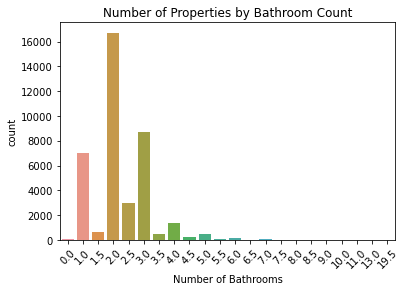

In [613]:
number_of_bathrooms = sns.countplot(data = train, x = train.bathroomcnt)
rotation = plt.xticks(rotation = 45)
title = number_of_bathrooms.set(title = "Number of Properties by Bathroom Count", xlabel = "Number of Bathrooms")

### Logerror by Bathroom Count

Now we will calculate how `logerror` differs according to bathroom count.

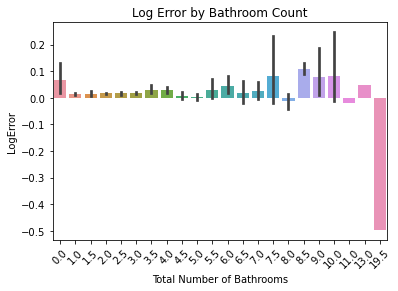

In [614]:
bathroomcnt_logerror = sns.barplot(x = train.bathroomcnt, y = train.logerror)
rotation = plt.xticks(rotation = 45)
labels = bathroomcnt_logerror.set(Title = "Log Error by Bathroom Count", xlabel = "Total Number of Bathrooms", ylabel = "LogError")

### Statistical Testing

Based on our graphs, it does appear that `logerror` differs significantly by bathroom count, but now we need to determine this connection statistically. To my eyes, it looks like variance begins to change after 3.5 bathrooms. We will test whether or not there is a difference in `logerror` for properties with less than 3.5 bathrooms and properties with more than 3.5 bathrooms. 

#### Testing for Variance 

First, we must test for a difference in variance between our two samples in the datset. 

$H_0:$ There is no difference in log error variance between properties with less than 3.5 bathrooms and properties with 3.5 bathrooms or more.

$H_a:$ There is a difference in log error variance between properties with less than 3.5 bathrooms and properties with 3.5 bathrooms or more.

In [615]:
stats.levene(
    train.query('bathroomcnt < 3.5').logerror,
    train.query('bathroomcnt >= 3.5').logerror,
)

LeveneResult(statistic=0.7191602721073682, pvalue=0.39642467482098875)

We conclude that there is no difference in `logerror` variance for properties with less than 3.5 bathrooms and properties with 3.5 bathrooms or more. As a result, in the following t-test, we set `equal_var` to `True`.

#### Testing for Difference in Mean

$H_0:$ There is no difference in log error between properties with less than 3.5 bathrooms and properties with 3.5 bathrooms or more.

$H_a:$ There is a difference in log error between properties with less than 3.5 bathrooms and properties with 3.5 bathrooms or more.

In [616]:
stats.ttest_ind(
    train[train.bathroomcnt < 3.5].logerror,
    train[train.bathroomcnt >= 3.5].logerror,
    equal_var=True
)

Ttest_indResult(statistic=-2.1467275845759373, pvalue=0.031821096233265074)

Because our pvalue is low, we reject the null hypothesis and conclude that there is a difference in log error for properties with less than 3.5 bathrooms and properties with 3.5 bathrooms or more more. 

## Does Log Error Differ Significantly by Bedroom Count?

We have determined that log error does differ for properties with a large number of bathrooms. Is this same true for properties with a large number of bedrooms? Let's find out.

### Value Counts

How many properties have each number of bedrooms? This question is addressed below.

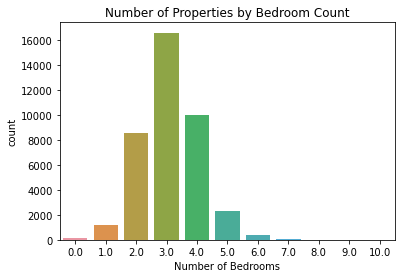

In [617]:
bedroom_value_counts = sns.countplot(data = train, x = train.bedroomcnt)
labels = bedroom_value_counts.set(title = "Number of Properties by Bedroom Count", xlabel = "Number of Bedrooms")

### Log Error by Bedroom Count

The following graph addresses how `logerror` differs by bedroom count.

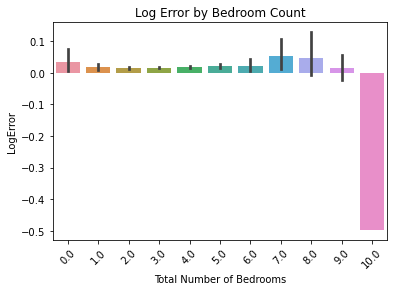

In [618]:
bedroomcnt_logerror = sns.barplot(x = train.bedroomcnt, y = train.logerror)
rotation = plt.xticks(rotation = 45)
labels = bedroomcnt_logerror.set(title = "Log Error by Bedroom Count" , xlabel = "Total Number of Bedrooms", ylabel = "LogError")

### Stastical Testing

I believe that based on the graph above, `logerror` begin to change at around four bedrooms. We will test that inference stastically below. 

#### Testing for Variance

First, we must determine if there is a difference in variance for properties which have less than 4 bedrooms and properties which have 4 or more bedrooms.

$H_0:$ There is no difference in log error variance between properties with less than 4 bedrooms and properties with 4 bedrooms or more.

$H_a:$ There is a difference in log error variance between properties with less than 4 bedrooms and properties with 4 bedrooms or more.

In [619]:
stats.levene(
    train.query('bedroomcnt < 4').logerror,
    train.query('bedroomcnt >= 4').logerror,
)

LeveneResult(statistic=0.7489259151804459, pvalue=0.38682180531220967)

Because our pvalue is high, we conclude that there is no difference in variance between the two samples. Thus, for our t-test below, we set `equal_var` equal to `True`.

#### Testing for Difference in Mean

In [620]:
stats.ttest_ind(
    train[train.bedroomcnt < 4].logerror,
    train[train.bedroomcnt >= 4].logerror,
    equal_var=True
)

Ttest_indResult(statistic=-1.9467335277685935, pvalue=0.0515738278860477)

We conclude that there is no difference in mean for our two samples, but just barely. 

## Does Log Error Differ by County?

Now we will explore the question, is our log error different between Los Angeles, Orange, and Ventura County? 

### Average Log Error by County

First, we graph the average log error by county.

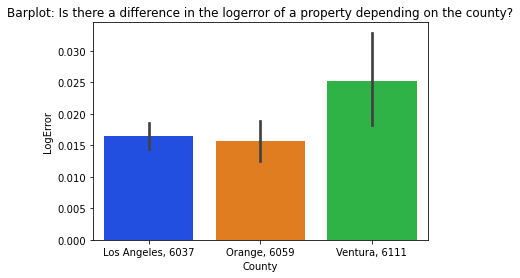

In [621]:
county_log_error = sns.barplot(data = train, y = 'logerror', x = 'fips')
title = plt.title("Barplot: Is there a difference in the logerror of a property depending on the county?")
xlabel = plt.xlabel("County")
ylabel = plt.ylabel("LogError")
xticks = county_log_error.set_xticklabels(["Los Angeles, 6037", "Orange, 6059", "Ventura, 6111"])

It seems that Ventura has a much higher average `logerror` than Los Angeles and Orange County, but we need to confirm this impression stastically.

### Stastical Testing

#### Testing for Variance

**Los Angeles vs. Orange County**

$H_0:$ There is no difference in log error variance between Los Angeles and Orange County. 

$H_a:$ There is a significant difference in log error variance between Los Angeles and Orange County.

In [622]:
stats.levene(
    train.query('fips == 6037.0').logerror,
    train.query('fips == 6059.0').logerror,
)

LeveneResult(statistic=0.2922519988069781, pvalue=0.5887843475165777)

There is no difference in variance of log error between Los Angeles and Orange County.

**Orange County vs. Ventura**

In [623]:
stats.levene(
    train.query('fips == 6059.0').logerror,
    train.query('fips == 6111.0').logerror,
)

LeveneResult(statistic=0.26029144489707706, pvalue=0.6099285743995952)

There is no difference in variance of log error between Orange County and Ventura.

**Los Angeles vs. Ventura**

$H_0:$ There is no difference in log error variance between Los Angeles and Ventura. 

$H_a:$ There is a significant difference in log error between Los Angeles and Ventura.

In [624]:
stats.levene(
    train.query('fips == 6037.0').logerror,
    train.query('fips == 6111.0').logerror,
)

LeveneResult(statistic=0.811996093595627, pvalue=0.3675381765653868)

There is no difference in variance of log error between Los Angeles and Ventura.

#### Testing difference in mean

**Los Angeles vs. Orange County**

$H_0:$ There is no difference in log error between Los Angeles and Orange County. 

$H_a:$ There is a significant difference in log error between Los Angeles and Orange County.

In [625]:
stats.ttest_ind(
    train[train.fips == 6037.0].logerror,
    train[train.fips == 6059.0].logerror,
    equal_var = True
)

Ttest_indResult(statistic=0.3744968199332362, pvalue=0.7080369314010183)

There is no difference in log error between Los Angeles and Orange County.

**Orange County vs. Ventura**

$H_0:$ There is no difference in log error between Orange County and Ventura. 

$H_a:$ There is a significant difference in log error between Orange County and Ventura.

In [626]:
stats.ttest_ind(
    train.query('fips == 6059.0').logerror,
    train.query('fips == 6111.0').logerror,
    equal_var = True
)

Ttest_indResult(statistic=-2.658837258745088, pvalue=0.007850591636554086)

There **is** a difference in log error between Orange County and Ventura.

**Los Angeles vs. Ventura**

$H_0:$ There is no difference in log error between Orange County and Ventura. 

$H_a:$ There is a significant difference in log error between Orange County and Ventura.

In [627]:
stats.ttest_ind(
    train.query('fips == 6037.0').logerror,
    train.query('fips == 6111.0').logerror,
    equal_var = True
)

Ttest_indResult(statistic=-2.7295762208762, pvalue=0.006345368610063448)

There is a significant difference in log error between Los Angeles and Ventura.

### Map 

We conclude that log error is on average higher in Ventura than in Los Angeles and Orange County. We can visualize the difference in logerror by county with the map below. Notice that the dtos in the scatterplot below are on average larger in Ventura County.

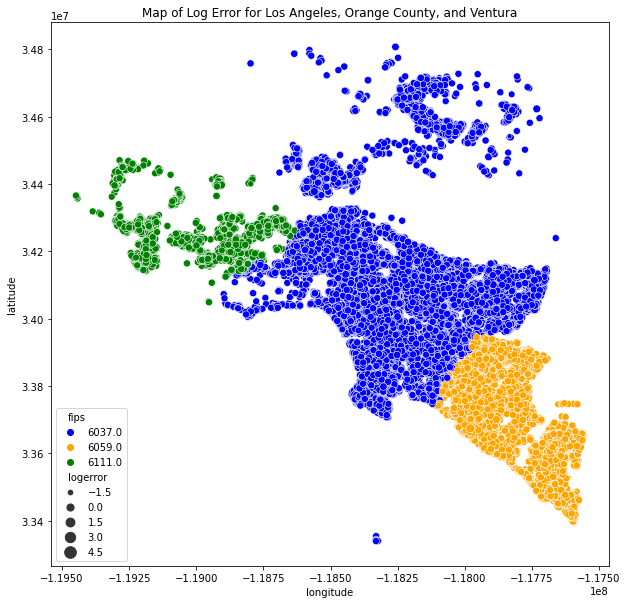

In [628]:
plt.figure(figsize=(10, 10))
county_map = sns.scatterplot(data = train, x = 'longitude', y='latitude', hue = 'fips', palette = ['blue', 'orange', 'green'], size = 'logerror', sizes=(5, 150))
tilte = county_map.set(Title = "Map of Log Error for Los Angeles, Orange County, and Ventura")

## Does log error differ according to tract and block?

Tract and block subdivisions of counties for census purposes that have approximately 4,000 residents each. 

In [629]:
len(train.rawcensustractandblock.unique())

28426

In our data, we have 28,426 census tract and blocks. Do these values correspond to our log error? Let's see if a visualization helps us to answer this question.

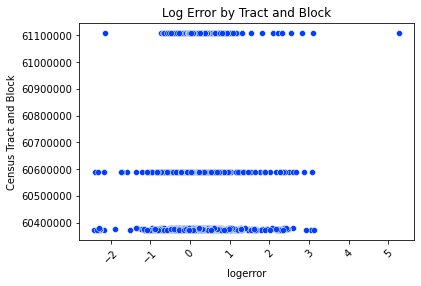

In [630]:
tract_and_block = sns.scatterplot(data = train, y = train.rawcensustractandblock, x = train.logerror)
tract_and_block.ticklabel_format(useOffset=False, style = "plain")
rotation = plt.xticks(rotation = 45)
labels = tract_and_block.set(title = "Log Error by Tract and Block", ylabel = "Census Tract and Block")

In our data, there are three groupings. However, these groupings correspond exactly to the three counties in our data set. Therefore, if census tract and block drives `logerror` this is only because the data for county is contained in the raw census tract and block. Thus, any questions we have about how this data corresponds to `logerror` is addressed by our exploration of county. 

## Does assessment year affect log error?

First, let's see how log error changes according to assessment year.

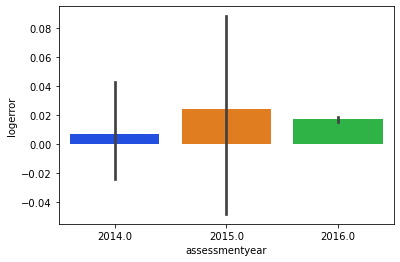

In [631]:
assessment_year = sns.barplot(data = train, x = train.assessmentyear, y = train.logerror)

It appears that properties that were assessed in 2015 have a higher log error than properties assesed in 2014 or 2016. We will test this inference stastically. 

### Stastical Testing

#### Testing for Variance

**2014 vs 2015**

In [632]:
stats.levene(
    train.query('assessmentyear == 2014.0').logerror,
    train.query('assessmentyear == 2015.0').logerror,
)

LeveneResult(statistic=1.7504545712345498, pvalue=0.19652316782320087)

**2015 vs 2016**

In [633]:
stats.levene(
    train.query('assessmentyear == 2015.0').logerror,
    train.query('assessmentyear == 2016.0').logerror,
)

LeveneResult(statistic=0.22047663007922857, pvalue=0.6386796042740412)

**2014 vs 2016**

In [634]:
stats.levene(
    train.query('assessmentyear == 2014.0').logerror,
    train.query('assessmentyear == 2016.0').logerror,
)

LeveneResult(statistic=0.4266469534684474, pvalue=0.5136426757030881)

Because all of the pvalues for the Levene test our high, we will assume for all of our t-tests below that our groups have equal variance.

#### Testing for Difference in Mean

**2014 vs 2015**

In [635]:
stats.ttest_ind(
    train.query('assessmentyear == 2014.0').logerror,
    train.query('assessmentyear == 2015.0').logerror,
    equal_var = True
)

Ttest_indResult(statistic=-0.3936492043938523, pvalue=0.6968217745931826)

**2015 vs 2016**

In [636]:
stats.ttest_ind(
    train.query('assessmentyear == 2015.0').logerror,
    train.query('assessmentyear == 2016.0').logerror,
    equal_var = True
)

Ttest_indResult(statistic=0.18302008141214013, pvalue=0.8547832095108863)

**2014 vs. 2016**

In [637]:
stats.ttest_ind(
    train.query('assessmentyear == 2014.0').logerror,
    train.query('assessmentyear == 2016.0').logerror,
    equal_var = True
)

Ttest_indResult(statistic=-0.2074466085033929, pvalue=0.8356621646775848)

Because our p-values are high, we conclude that there is no significant differencein log error based on assessment year.

## Key Takeaways from Explore

So far, it seems that the biggest drivers of log error our:
- county (FIPS code) and 
- bathroom count. 

Bedroom count also seems to be a driver of log error, though not as significantly as the other features. 

# Clustering 

Now that we have explored the data, we are ready to begin clustering the data into relevant groups. Once we have separated the data into different clusters, we can run different models on different clusters.

To create our clusters, we will create a smaller DataFrame that only contains our features most predictive of logerror. To start, we will use:
 - `bedroomcnt`, 
 - `bathroomcnt`, 
 - `fips`.

## Clustering the data with Bedroom Count, Bathroom Count, and Fips

First we create our DataFrame.

In [638]:
X = train[['bathroomcnt', 'bedroomcnt', 'fips']]

To make our data easier to process, we scale the features `bathroomcnt` and `bedroomcnt`.

In [639]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(X[['bathroomcnt', 'bedroomcnt']])
X[['bathroomcnt', 'bedroomcnt']] = scaler.transform(X[['bathroomcnt', 'bedroomcnt']])
X.head()

,bathroomcnt,bedroomcnt,fips
2269,0.102564,0.3,6037.0
68766,0.102564,0.4,6037.0
43833,0.153846,0.4,6037.0
30161,0.102564,0.3,6037.0
47670,0.051282,0.3,6037.0


### Elbow Method

We will use the elbow method to determine our optimum number of clusters. The elbow method means that we will use a line graph to visualize number of cluster vs. inertia. We will look for the "elbow" in the line graph, the part where intertia drops off significantly.

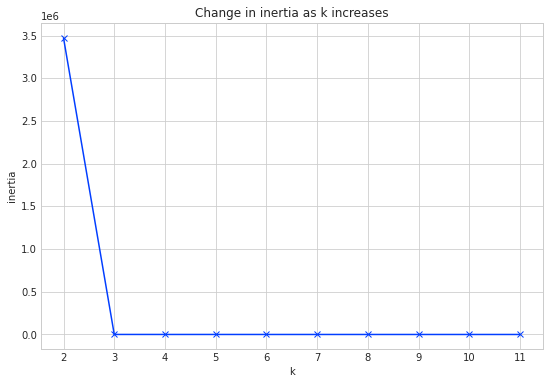

In [640]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

Inertia dramatically drops off after 3 clusters. I suspect, however, this is because the elbow method is sensing there are three different `fips` values. Clustering while including `fips` may not give us any new information. Indeed, the data may simply be clustered according to county.

### K Means

In [641]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

kmeans.predict(X)

kmeans.cluster_centers_

array([[   0.11279609,    0.30384763, 6037.        ],
       [   0.11827419,    0.33501548, 6111.        ],
       [   0.122136  ,    0.32454812, 6059.        ]])

In [642]:
X['cluster'] = kmeans.predict(X)

In [643]:
X.head()

,bathroomcnt,bedroomcnt,fips,cluster
2269,0.102564,0.3,6037.0,0
68766,0.102564,0.4,6037.0,0
43833,0.153846,0.4,6037.0,0
30161,0.102564,0.3,6037.0,0
47670,0.051282,0.3,6037.0,0


### Value Counts

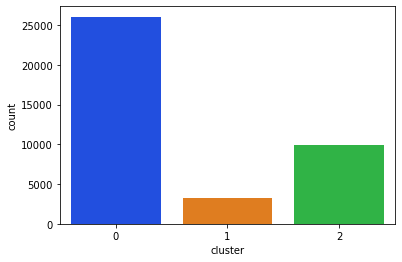

In [644]:
counts_by_cluster = sns.countplot( x = X.cluster)

### Visualizing Clusters

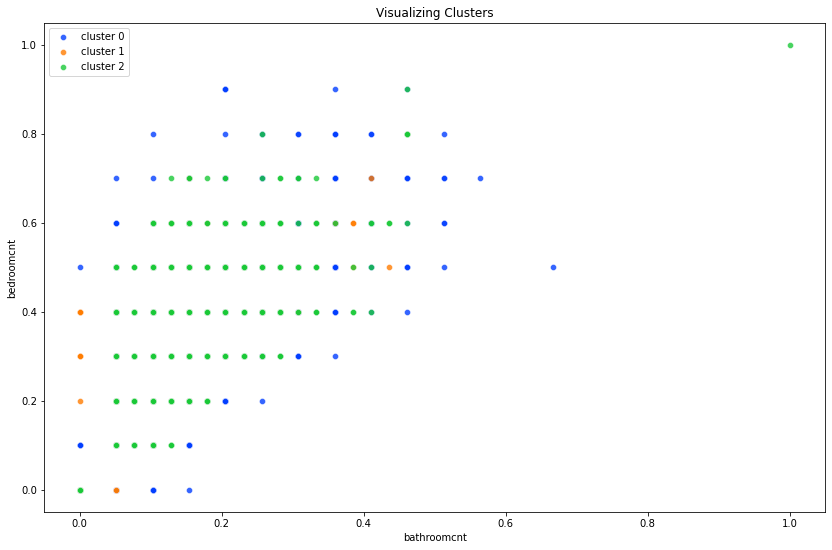

In [645]:
plt.figure(figsize=(14, 9))

for cluster, subset in X.groupby('cluster'):
    cluster_plot = sns.scatterplot(subset.bathroomcnt, subset.bedroomcnt, label='cluster ' + str(cluster), alpha=.8)


plt.legend()
labels = cluster_plot.set(title = "Visualizing Clusters", xlabel = "bathroomcnt", ylabel = "bedroomcnt")

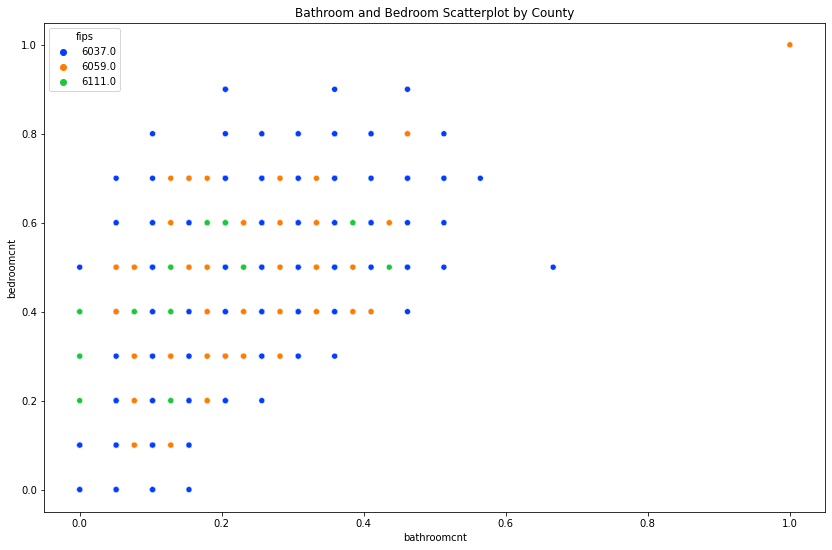

In [646]:

plt.figure(figsize=(14, 9))

bedbath_by_county = sns.scatterplot(x = X.bathroomcnt, y = X.bedroomcnt, hue = X.fips, palette = "bright")
labels = bedbath_by_county.set(title = "Bathroom and Bedroom Scatterplot by County")

Contrary to my intution, the data is not simply distributed according to county. Let's some stastical tests on the data to determine how correlated each cluster is to `logerror`.

### Stastical Testing

In [647]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(train[['bathroomcnt', 'bedroomcnt', 'fips']])

kmeans.predict(train[['bathroomcnt', 'bedroomcnt', 'fips']])

kmeans.cluster_centers_

array([[   2.30634675,    3.3501548 , 6111.        ],
       [   2.19952385,    3.03847631, 6037.        ],
       [   2.38165202,    3.24548117, 6059.        ]])

In [648]:
train['cluster'] = kmeans.predict(train[['bathroomcnt', 'bedroomcnt', 'fips']])

In [649]:
train.head()

,index,propertylandusetypeid,id,heatingorsystemtypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,heatingorsystemdesc,logerror,transactiondate,last_trans_date,propertylandusedesc,cluster
2269,2462,261.0,2462,2.0,11020724,2.0,3.0,6.0,2.0,1406.0,...,2016.0,360400.0,5727.60,6.037110e+13,Central,-0.009313,2017-01-12,2017-01-12,Single Family Residential,1
68766,74293,261.0,74293,2.0,11089877,2.0,4.0,6.0,2.0,1665.0,...,2016.0,94356.0,3163.81,6.037113e+13,Central,0.109348,2017-09-07,2017-09-07,Single Family Residential,1
43833,47347,261.0,47347,2.0,11075321,3.0,4.0,8.0,3.0,2365.0,...,2016.0,173410.0,4548.83,6.037111e+13,Central,0.006360,2017-06-16,2017-06-16,Single Family Residential,1
30161,32586,261.0,32586,2.0,11088659,2.0,3.0,6.0,2.0,1348.0,...,2016.0,134526.0,3412.71,6.037113e+13,Central,0.011047,2017-05-03,2017-05-03,Single Family Residential,1
47670,51749,261.0,51749,7.0,12342656,1.0,3.0,4.0,1.0,1062.0,...,2016.0,167237.0,2988.15,6.037554e+13,Floor/Wall,0.021502,2017-06-29,2017-06-29,Single Family Residential,1


In [650]:
stats.ttest_ind(
    train.query('cluster == 0').logerror,
    train.query('cluster == 1').logerror
)

Ttest_indResult(statistic=2.7295762208762, pvalue=0.006345368610063448)

In [651]:
stats.ttest_ind(
    train.query('cluster == 1').logerror,
    train.query('cluster == 2').logerror
)

Ttest_indResult(statistic=0.3744968199332362, pvalue=0.7080369314010183)

In [652]:
stats.ttest_ind(
    train.query('cluster == 0').logerror,
    train.query('cluster == 2').logerror
)

Ttest_indResult(statistic=2.658837258745088, pvalue=0.007850591636554086)

#### Key Takeaway 
All of our clusters have statistically different log error mean, except for 0 and 2. 

## Clustering the data with Bathroom Count and Bedroom Count

Now we will see how our clustering model performs if we remove `fips`.

In [653]:
X = train[['bathroomcnt', 'bedroomcnt']]

To make the data easier to process, we will scale it using the MinMax scaler. The scaling processs is shown below.

In [654]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(X[['bathroomcnt', 'bedroomcnt']])

MinMaxScaler()

In [655]:
X = pd.DataFrame(scaler.transform(X), columns = X.columns).set_index([X.index.values])

In [656]:
X.head()

,bathroomcnt,bedroomcnt
2269,0.102564,0.3
68766,0.102564,0.4
43833,0.153846,0.4
30161,0.102564,0.3
47670,0.051282,0.3


### Elbow Method

Again, we use the elbow method to determine the optimum number of clusters. 

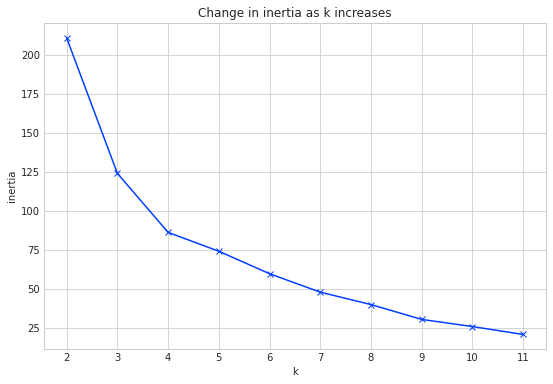

In [657]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

Judging by the graph above, it looks like inertia starts to drop off significantly around 4 clusters. Notice how steep the slope is from 3-4 compared to from 4-5.

### K Means

Now that we have determined that four is the optimum number of clusters, we can use K means to group or data into four clusters.

In [658]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

kmeans.predict(X)

kmeans.cluster_centers_

array([[0.10903866, 0.3       ],
       [0.13680202, 0.400161  ],
       [0.08324024, 0.18442921],
       [0.19467192, 0.51905449]])

We create a new column `cluster` that designates each points cluster.

In [659]:
X['cluster'] = kmeans.predict(X)

In [660]:
X.head()

,bathroomcnt,bedroomcnt,cluster
2269,0.102564,0.3,0
68766,0.102564,0.4,1
43833,0.153846,0.4,1
30161,0.102564,0.3,0
47670,0.051282,0.3,0


#### Visualization

The distribution of our clusters is visualized below.

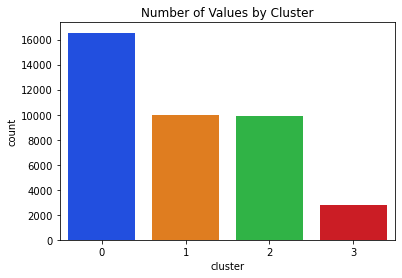

In [661]:
points_by_cluster = sns.countplot(x = X.cluster)
title = points_by_cluster.set(title= "Number of Values by Cluster")

#### Centroids

We also make centroids to mark the centerpoint of each of our clusters.

In [662]:
centroids = X.groupby('cluster')['bathroomcnt', 'bedroomcnt'].mean()
centroids

,bathroomcnt,bedroomcnt
cluster,,
0,0.109039,0.300000
1,0.136802,0.400161
2,0.083240,0.184429
3,0.194672,0.519054


#### Visualizing Clusters

We will now visualize our clusters along with the centroids which indicate the center of each cluster.

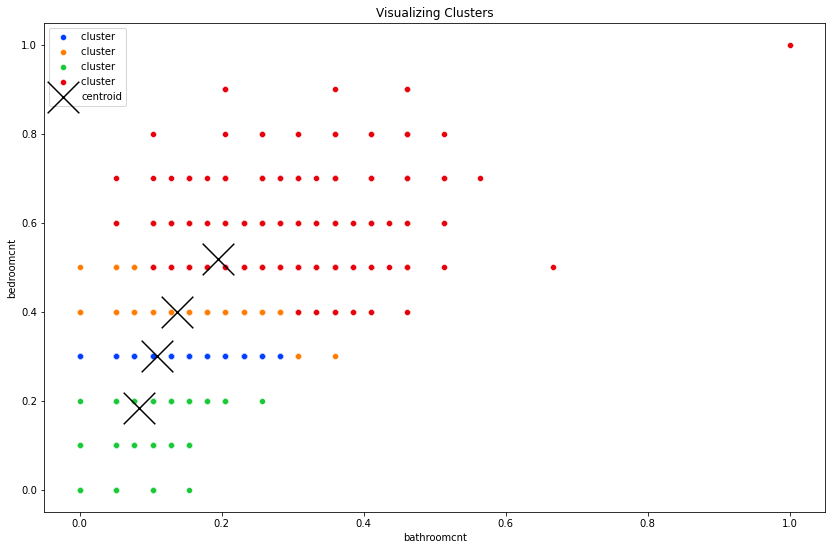

In [663]:
plt.figure(figsize=(14, 9))

for cluster, subset in X.groupby('cluster'):
    cluster_plot = sns.scatterplot(x = subset.bathroomcnt, y = subset.bedroomcnt, label='cluster ')

centroids.plot.scatter(y='bedroomcnt', x='bathroomcnt', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
labels = cluster_plot.set(title = "Visualizing Clusters", xlabel = "bathroomcnt", ylabel = "bedroomcnt")

### Statistical Testing

In [664]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(train[['bathroomcnt', 'bedroomcnt']])

kmeans.predict(train[['bathroomcnt', 'bedroomcnt']])

kmeans.cluster_centers_

array([[1.34176927, 2.07423621],
       [2.52856455, 4.15202312],
       [2.34906454, 2.91564705],
       [4.64540495, 4.70373479]])

In [665]:
train['cluster'] = kmeans.predict(train[['bathroomcnt', 'bedroomcnt']])

In [666]:
train.head()

,index,propertylandusetypeid,id,heatingorsystemtypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,heatingorsystemdesc,logerror,transactiondate,last_trans_date,propertylandusedesc,cluster
2269,2462,261.0,2462,2.0,11020724,2.0,3.0,6.0,2.0,1406.0,...,2016.0,360400.0,5727.60,6.037110e+13,Central,-0.009313,2017-01-12,2017-01-12,Single Family Residential,2
68766,74293,261.0,74293,2.0,11089877,2.0,4.0,6.0,2.0,1665.0,...,2016.0,94356.0,3163.81,6.037113e+13,Central,0.109348,2017-09-07,2017-09-07,Single Family Residential,1
43833,47347,261.0,47347,2.0,11075321,3.0,4.0,8.0,3.0,2365.0,...,2016.0,173410.0,4548.83,6.037111e+13,Central,0.006360,2017-06-16,2017-06-16,Single Family Residential,1
30161,32586,261.0,32586,2.0,11088659,2.0,3.0,6.0,2.0,1348.0,...,2016.0,134526.0,3412.71,6.037113e+13,Central,0.011047,2017-05-03,2017-05-03,Single Family Residential,2
47670,51749,261.0,51749,7.0,12342656,1.0,3.0,4.0,1.0,1062.0,...,2016.0,167237.0,2988.15,6.037554e+13,Floor/Wall,0.021502,2017-06-29,2017-06-29,Single Family Residential,0


**T test compared to cluster 0**

In [667]:
for number in train.cluster.unique():
    t, p = stats.ttest_ind(
    train[train.cluster == 0].logerror,
    train[train.cluster == number].logerror
    )
    print(number, t, p)

2 -0.4192534899548356 0.6750342935496011
1 -1.2021264280083075 0.22932788574144425
0 0.0 1.0
3 -2.6089183343239926 0.009093020017191237


**T test compared to cluster 1**

In [668]:
for number in train.cluster.unique():
    t, p = stats.ttest_ind(
    train[train.cluster == 1].logerror,
    train[train.cluster == number].logerror
    )
    print(number, t, p)

2 0.8561539284694314 0.3919205859580275
1 0.0 1.0
0 1.2021264280083075 0.22932788574144425
3 -1.8830420636784457 0.059717392881332106


**T test compared to cluster 2**

In [669]:
for number in train.cluster.unique():
    t, p = stats.ttest_ind(
    train[train.cluster == 2].logerror,
    train[train.cluster == number].logerror
    )
    print(number, t, p)

2 0.0 1.0
1 -0.8561539284694314 0.3919205859580275
0 0.4192534899548356 0.6750342935496011
3 -2.381186529818089 0.01726740657841287


**T test compared to cluster 3**

In [670]:
for number in train.cluster.unique():
    t, p = stats.ttest_ind(
    train[train.cluster == 3].logerror,
    train[train.cluster == number].logerror
    )
    print(number, t, p)

2 2.381186529818089 0.01726740657841287
1 1.8830420636784457 0.059717392881332106
0 2.6089183343239926 0.009093020017191237
3 0.0 1.0


#### Key Takeaway
Only the cluster 2 has a significantly different mean for log error than the rest of the data. I will reject this cluster because I don't believe its predictive of logerror.

## Clustering the data with Bathroom Count, Bedroom Count, Fips, and Assessment Year

We know that the clustering model with `bedroomcnt`, `bathroomcnt`, and `fips` performed better than  `bedroomcnt` and `bathroomcnt` alone. Now lets see what happens if we create clusters using: 
 - `bedroomcnt`, 
 - `bathroomcnt`, 
 - `fips`, and 
 - `assessmentyear`.

In [671]:
X = train[['bathroomcnt', 'bedroomcnt', 'fips', 'assessmentyear']]

### Scale the Data

In [672]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(X[['bathroomcnt', 'bedroomcnt']])

MinMaxScaler()

In [673]:
X[['bathroomcnt', 'bedroomcnt']] = scaler.transform(X[['bathroomcnt', 'bedroomcnt']])

In [674]:
X.head()

,bathroomcnt,bedroomcnt,fips,assessmentyear
2269,0.102564,0.3,6037.0,2016.0
68766,0.102564,0.4,6037.0,2016.0
43833,0.153846,0.4,6037.0,2016.0
30161,0.102564,0.3,6037.0,2016.0
47670,0.051282,0.3,6037.0,2016.0


### Elbow Method

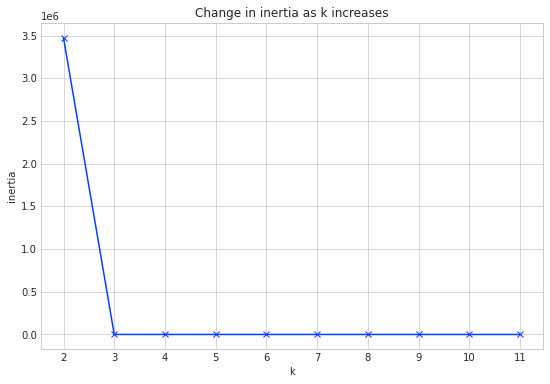

In [675]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

Again, three clusters is clearly the optimum amount.

### K Means

In [676]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

kmeans.predict(X)

kmeans.cluster_centers_

array([[   0.11279609,    0.30384763, 6037.        , 2015.99873282],
       [   0.11827419,    0.33501548, 6111.        , 2015.99907121],
       [   0.122136  ,    0.32454812, 6059.        , 2015.99939412]])

In [677]:
X['cluster'] = kmeans.predict(X)

In [678]:
X.head()

,bathroomcnt,bedroomcnt,fips,assessmentyear,cluster
2269,0.102564,0.3,6037.0,2016.0,0
68766,0.102564,0.4,6037.0,2016.0,0
43833,0.153846,0.4,6037.0,2016.0,0
30161,0.102564,0.3,6037.0,2016.0,0
47670,0.051282,0.3,6037.0,2016.0,0


#### Value Counts

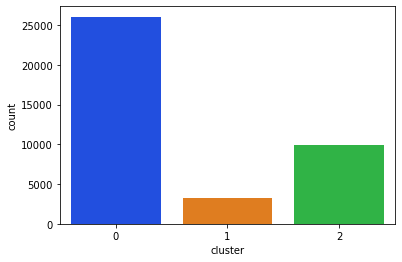

In [679]:
counts_by_cluster = sns.countplot( x = X.cluster)

#### Visualizing Clusters

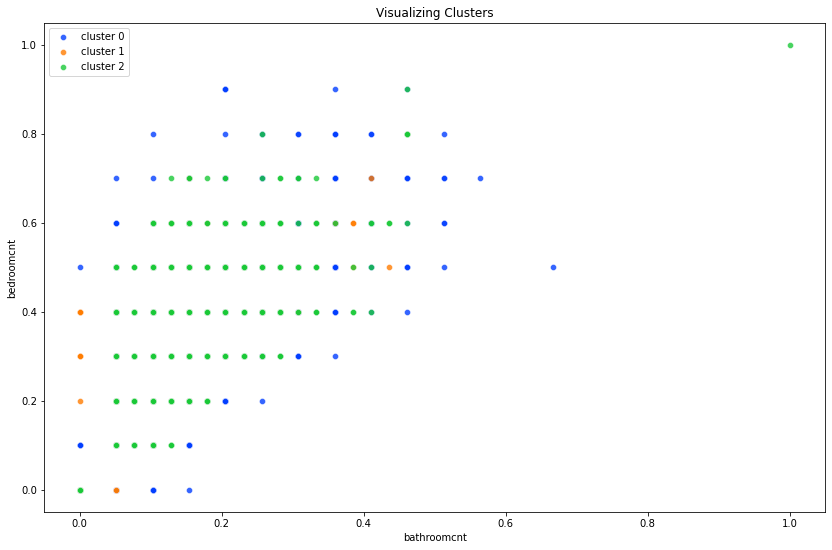

In [680]:
plt.figure(figsize=(14, 9))

for cluster, subset in X.groupby('cluster'):
    cluster_plot = sns.scatterplot(subset.bathroomcnt, subset.bedroomcnt, label='cluster ' + str(cluster), alpha=.8)

    
plt.legend()
labels = cluster_plot.set(title = "Visualizing Clusters", xlabel = "bathroomcnt", ylabel = "bedroomcnt")

### Stastical Testing

It is difficult to determine the usefulness of these clusters from the graph alone, so we will run some stastical tests on the data to see if our clusters are predictive of log error.

In [681]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(train[['bathroomcnt', 'bedroomcnt', 'fips', 'assessmentyear']])

kmeans.predict(train[['bathroomcnt', 'bedroomcnt', 'fips', 'assessmentyear']])

kmeans.cluster_centers_

array([[   2.38165202,    3.24548117, 6059.        , 2015.99939412],
       [   2.19952385,    3.03847631, 6037.        , 2015.99873282],
       [   2.30634675,    3.3501548 , 6111.        , 2015.99907121]])

In [682]:
train['cluster'] = kmeans.predict(train[['bathroomcnt', 'bedroomcnt', 'fips', 'assessmentyear']])

In [683]:
train.head()

,index,propertylandusetypeid,id,heatingorsystemtypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,heatingorsystemdesc,logerror,transactiondate,last_trans_date,propertylandusedesc,cluster
2269,2462,261.0,2462,2.0,11020724,2.0,3.0,6.0,2.0,1406.0,...,2016.0,360400.0,5727.60,6.037110e+13,Central,-0.009313,2017-01-12,2017-01-12,Single Family Residential,1
68766,74293,261.0,74293,2.0,11089877,2.0,4.0,6.0,2.0,1665.0,...,2016.0,94356.0,3163.81,6.037113e+13,Central,0.109348,2017-09-07,2017-09-07,Single Family Residential,1
43833,47347,261.0,47347,2.0,11075321,3.0,4.0,8.0,3.0,2365.0,...,2016.0,173410.0,4548.83,6.037111e+13,Central,0.006360,2017-06-16,2017-06-16,Single Family Residential,1
30161,32586,261.0,32586,2.0,11088659,2.0,3.0,6.0,2.0,1348.0,...,2016.0,134526.0,3412.71,6.037113e+13,Central,0.011047,2017-05-03,2017-05-03,Single Family Residential,1
47670,51749,261.0,51749,7.0,12342656,1.0,3.0,4.0,1.0,1062.0,...,2016.0,167237.0,2988.15,6.037554e+13,Floor/Wall,0.021502,2017-06-29,2017-06-29,Single Family Residential,1


In [684]:
stats.ttest_ind(
    train.query('cluster == 0').logerror,
    train.query('cluster == 1').logerror
)

Ttest_indResult(statistic=-0.3744968199332362, pvalue=0.7080369314010183)

In [685]:
stats.ttest_ind(
    train.query('cluster == 0').logerror,
    train.query('cluster == 2').logerror
)

Ttest_indResult(statistic=-2.658837258745088, pvalue=0.007850591636554086)

In [686]:
stats.ttest_ind(
    train.query('cluster == 1').logerror,
    train.query('cluster == 2').logerror
)

Ttest_indResult(statistic=-2.7295762208762, pvalue=0.006345368610063448)

#### Key Takeaways
The model with `bedroomcnt`, `bathroomcnt`, `assessmentyear`, and `fips` performed about equally as well as the model with just `bedroomcnt`, `bathroomcnt`, and `fips`. For this reason, I believe it is better to select the simpler model. Thus, the clustering model I will use is the one that includes three, rather than four, features:
 - `bedroomcnt`, 
 - `bathroomcnt`, and 
 - `fips`

# Modeling

In [6]:
train = data_no_outliers(train)

In [8]:
validate = data_no_outliers(validate)

In [9]:
test = data_no_outliers(test)

We will run four different models and compare their performance. We will also run each model separately on each of our three clusters. First, we will need to recreate the clusters that we made in the previous section. 

The first step is to scale the data.

In [10]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(train[['bathroomcnt', 'bedroomcnt']])
train[['bathroomcnt_scaled', 'bedroomcnt_scaled']] = scaler.transform(train[['bathroomcnt', 'bedroomcnt']])
train.head()

,index,propertylandusetypeid,id,heatingorsystemtypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,landtaxvaluedollarcnt,taxamount,censustractandblock,heatingorsystemdesc,logerror,transactiondate,last_trans_date,propertylandusedesc,bathroomcnt_scaled,bedroomcnt_scaled
2269,2462,261.0,2462,2.0,11020724,2.0,3.0,6.0,2.0,1406.0,...,360400.0,5727.60,6.037110e+13,Central,-0.009313,2017-01-12,2017-01-12,Single Family Residential,0.222222,0.333333
68766,74293,261.0,74293,2.0,11089877,2.0,4.0,6.0,2.0,1665.0,...,94356.0,3163.81,6.037113e+13,Central,0.109348,2017-09-07,2017-09-07,Single Family Residential,0.222222,0.444444
43833,47347,261.0,47347,2.0,11075321,3.0,4.0,8.0,3.0,2365.0,...,173410.0,4548.83,6.037111e+13,Central,0.006360,2017-06-16,2017-06-16,Single Family Residential,0.333333,0.444444
30161,32586,261.0,32586,2.0,11088659,2.0,3.0,6.0,2.0,1348.0,...,134526.0,3412.71,6.037113e+13,Central,0.011047,2017-05-03,2017-05-03,Single Family Residential,0.222222,0.333333
47670,51749,261.0,51749,7.0,12342656,1.0,3.0,4.0,1.0,1062.0,...,167237.0,2988.15,6.037554e+13,Floor/Wall,0.021502,2017-06-29,2017-06-29,Single Family Residential,0.111111,0.333333


In [11]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(validate[['bathroomcnt', 'bedroomcnt']])
validate[['bathroomcnt_scaled', 'bedroomcnt_scaled']] = scaler.transform(validate[['bathroomcnt', 'bedroomcnt']])
validate.head()

,index,propertylandusetypeid,id,heatingorsystemtypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,landtaxvaluedollarcnt,taxamount,censustractandblock,heatingorsystemdesc,logerror,transactiondate,last_trans_date,propertylandusedesc,bathroomcnt_scaled,bedroomcnt_scaled
14691,15932,261.0,15932,2.0,17252607,2.0,3.0,6.0,2.0,1502.0,...,326000.0,5744.14,6.111008e+13,None,0.049632,2017-03-09,2017-03-09,Single Family Residential,0.266667,0.428571
64671,70119,261.0,70119,2.0,13889846,3.5,3.0,6.0,3.5,2680.0,...,774271.0,13137.40,6.059063e+13,None,-0.088828,2017-08-25,2017-08-25,Single Family Residential,0.466667,0.428571
47047,50987,261.0,50987,7.0,12150974,1.0,1.0,5.0,1.0,765.0,...,277057.0,3937.10,6.037301e+13,Floor/Wall,0.234613,2017-06-27,2017-06-27,Single Family Residential,0.133333,0.142857
37872,41121,261.0,41121,2.0,14100091,2.0,3.0,6.0,2.0,1248.0,...,385440.0,5519.82,6.059110e+13,None,-0.008904,2017-05-30,2017-05-30,Single Family Residential,0.266667,0.428571
28712,31092,261.0,31092,2.0,10718326,2.0,3.0,7.0,2.0,2059.0,...,225409.0,5419.54,6.037134e+13,Central,-0.005055,2017-04-28,2017-04-28,Single Family Residential,0.266667,0.428571


In [12]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(test[['bathroomcnt', 'bedroomcnt']])
test[['bathroomcnt_scaled', 'bedroomcnt_scaled']] = scaler.transform(test[['bathroomcnt', 'bedroomcnt']])
test.head()

,index,propertylandusetypeid,id,heatingorsystemtypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,landtaxvaluedollarcnt,taxamount,censustractandblock,heatingorsystemdesc,logerror,transactiondate,last_trans_date,propertylandusedesc,bathroomcnt_scaled,bedroomcnt_scaled
35512,38671,261.0,38671,7.0,12781693,1.0,2.0,4.0,1.0,1129.0,...,132043.0,2882.80,6.037501e+13,Floor/Wall,0.009587,2017-05-23,2017-05-23,Single Family Residential,0.166667,0.222222
12209,13273,266.0,13273,2.0,14699705,2.0,2.0,6.0,2.0,920.0,...,331249.0,4530.96,6.059064e+13,None,0.166976,2017-02-28,2017-02-28,Condominium,0.333333,0.222222
47684,51765,261.0,51765,2.0,12345535,1.0,2.0,6.0,1.0,1477.0,...,144452.0,3206.72,6.037554e+13,Central,-0.014360,2017-06-29,2017-06-29,Single Family Residential,0.166667,0.222222
70559,76225,261.0,76225,7.0,10849547,1.0,3.0,4.0,1.0,1202.0,...,85750.0,4138.65,6.037129e+13,Floor/Wall,0.010911,2017-09-13,2017-09-13,Single Family Residential,0.166667,0.333333
27882,30175,261.0,30175,2.0,17070573,1.0,2.0,6.0,1.0,656.0,...,228849.0,3830.64,6.111001e+13,None,0.047554,2017-04-27,2017-04-27,Single Family Residential,0.166667,0.222222


## Adding Clusters

In [13]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(train[['bathroomcnt_scaled', 'bedroomcnt_scaled', 'fips']])

kmeans.predict(train[['bathroomcnt_scaled', 'bedroomcnt_scaled', 'fips']])

kmeans.cluster_centers_

array([[   0.24763514,    0.36771772, 6111.        ],
       [   0.22881247,    0.34246897, 6037.        ],
       [   0.25212842,    0.35415387, 6059.        ]])

In [14]:
train['cluster'] = kmeans.predict(train[['bathroomcnt', 'bedroomcnt', 'fips']])
validate['cluster'] = kmeans.predict(validate[['bathroomcnt', 'bedroomcnt', 'fips']])
test['cluster'] = kmeans.predict(test[['bathroomcnt', 'bedroomcnt', 'fips']])

## Evaluate Imports

We use the following imports from our `evaluate.py` to assess our different models. For more information about these functions, please see the `evaluate.py` file in this repositiory. 

In [15]:
from evaluate import plot_residuals
from evaluate import regression_errors
from evaluate import baseline_mean_errors
from evaluate import better_than_baseline

## Split the Data into X and Y

We will now split our data into X, the predictive features, and, y the target variable.

In [16]:
y_train= pd.DataFrame(train.logerror)

In [17]:
y_validate = pd.DataFrame(validate.logerror)

In [18]:
y_test = pd.DataFrame(test.logerror)

For our X values, we will use the features that we found to be most predictive of logerror to construct our model. These features are:
 - `bathroomcnt`, 
 - `bedroomcnt`, and 
 - `fips`. 

In [19]:
X_train_model = train[['bathroomcnt_scaled', 'bedroomcnt_scaled', 'fips', 'cluster']]

In [20]:
X_validate_model = validate[['bathroomcnt_scaled', 'bedroomcnt_scaled', 'fips', 'cluster']]

In [21]:
X_test_model = test[['bathroomcnt_scaled', 'bedroomcnt_scaled', 'fips', 'cluster']]

## Establish Baseline

The next step in our modeling process is to establish a baseline for comparison with our models. We will establish our baseline using the mean. 

In [22]:
# Predict logerror_pred_mean
logerror_pred_mean = y_train.logerror.mean()

In [23]:
y_train['logerror_pred_mean'] = logerror_pred_mean

In [24]:
y_validate['logerror_pred_mean'] = logerror_pred_mean

Now we will establish our baseline using the median.

In [25]:
# Predict logerror_pred_median
logerror_pred_median = y_train.logerror.median()

In [26]:
y_train['logerror_pred_median'] = logerror_pred_median


In [27]:
y_validate['logerror_pred_median'] = logerror_pred_median


In [28]:
y_train.head()

,logerror,logerror_pred_mean,logerror_pred_median
2269,-0.009313,0.017222,0.006699
68766,0.109348,0.017222,0.006699
43833,0.006360,0.017222,0.006699
30161,0.011047,0.017222,0.006699
47670,0.021502,0.017222,0.006699


### Evaluate Baseline

In [29]:
# RMSE of taxvaluedollarcnt_pred_mean
rmse_train_mean = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean) ** .5
rmse_validate_mean = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean) ** (1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train_mean, 3), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_mean, 3))

# RMSE of taxvaluedollarcnt_pred_median
rmse_train_median= mean_squared_error(y_train.logerror, y_train.logerror_pred_median) ** .5
rmse_validate_median = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train_median, 3), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_median, 3))

RMSE using Mean
Train/In-Sample:  0.174 
Validate/Out-of-Sample:  0.18
RMSE using Median
Train/In-Sample:  0.174 
Validate/Out-of-Sample:  0.18


### Build DataFrame

We will build a DataFrame so that we can easily compare the metrics of different models in this section.

In [30]:
from sklearn.metrics import explained_variance_score

In [31]:
def make_metric_df(y, y_pred, model_name, metric_df):
    if metric_df.size ==0:
        metric_df = pd.DataFrame(data=[
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }])
        return metric_df
    else:
        return metric_df.append(
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }, ignore_index=True)

In [32]:
metric_df = pd.DataFrame()
metric_df = make_metric_df(y_validate.logerror,
                           y_validate.logerror_pred_median,
                           'median_baseline',
                          metric_df)

In [33]:
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,0.179861,0.0


## Linear Regression

The first model we will try on our dataset is the Linear Regression model.

In [34]:
#Create the model object
lm_1= LinearRegression(normalize=True)

# fit the model to training data
lm_1.fit(X_train_model, y_train.logerror)

y_train['logerror_pred_lm_1'] = lm_1.predict(X_train_model)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm_1) ** (1/2)

# predict validate
y_validate['logerror_pred_lm_1'] = lm_1.predict(X_validate_model)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm_1) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.17372460132217668 
Validation/Out-of-Sample:  0.17960251603223454


#### Evaluate Linear Regression

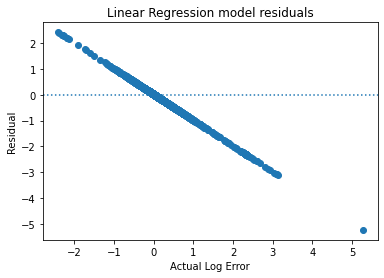

In [37]:
plot_residuals(y_train.logerror, y_train.logerror_pred_lm_1)

In [38]:
regression_errors(y_train.logerror, y_train.logerror_pred_lm_1)

ESS 0.35631310466185645
MSE 0.030180237104549236
SSE 996.2194465840657
TSS 996.5757596887275
RMSE 0.17372460132217668


In [39]:
baseline_mean_errors(y_train.logerror)

MSE baseline 0.03019103152742366
SSE baseline 996.5757596887277
RMSE baseline 0.17375566617357738


#### Append to DataFrame

In [41]:
metric_df= metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm_1)}, ignore_index=True)

In [42]:
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,0.179861,0.000000
1,OLS Regressor,0.179603,-0.000658


## Lasso Lars

Now we will use the Lassor Lars model to evaluate.

In [43]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data.
lars.fit(X_train_model, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train_model)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars) ** (1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate_model)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.17375566617357738 
Validation/Out-of-Sample:  0.17954213108267478


#### Evaluate LassoLars

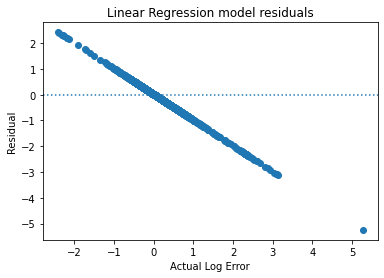

In [44]:
plot_residuals(y_train.logerror, y_train.logerror_pred_lars)

In [45]:
regression_errors(y_train.logerror, y_train.logerror_pred_lars)

ESS 3.973313845892392e-29
MSE 0.03019103152742366
SSE 996.5757596887277
TSS 996.5757596887277
RMSE 0.17375566617357738


In [46]:
baseline_mean_errors(y_train.logerror)

MSE baseline 0.03019103152742366
SSE baseline 996.5757596887277
RMSE baseline 0.17375566617357738


#### Append to DataFrame

In [47]:
metric_df_cluster_0 = make_metric_df(y_validate_cluster_0.logerror, y_validate_cluster_0.logerror_pred_lars,
               'lasso_alpha_1',
               metric_df_cluster_0)

NameError: name 'y_validate_cluster_0' is not defined

In [48]:
metric_df_cluster_0

NameError: name 'metric_df_cluster_0' is not defined

## Linear Regression, Second Degree

In [49]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train
X_train_degree2 = pf.fit_transform(X_train_model)


# transform X_validate
X_validate_degree2 = pf.transform(X_validate_model)

#transform X_test
X_test_degree2=  pf.transform(X_test_model)


In [50]:
# create the model object
lm2= LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2) ** (1/2)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.1736993960506218 
Validation/Out-of-Sample:  0.032306842480741255


#### Evaluate Second Degree Linear Regression

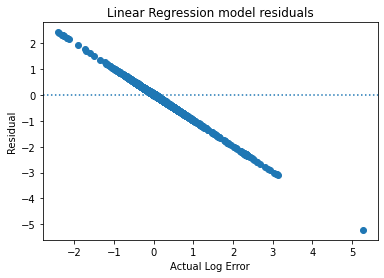

In [51]:
plot_residuals(y_train.logerror, y_train.logerror_pred_lm2)

In [52]:
regression_errors(y_train.logerror, y_train.logerror_pred_lm2)

ESS 0.6477587911779212
MSE 0.030171480188350766
SSE 995.9303895372705
TSS 996.5781483284484
RMSE 0.1736993960506218


In [53]:
baseline_mean_errors(y_train.logerror)

MSE baseline 0.03019103152742366
SSE baseline 996.5757596887277
RMSE baseline 0.17375566617357738


#### Add to DataFrame

In [54]:
metric_df = make_metric_df(y_validate.logerror, y_validate.logerror_pred_lm2,
               'quadratic',
               metric_df)

In [55]:
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,0.179861,0.000000
1,OLS Regressor,0.179603,-0.000658
2,quadratic,0.179741,-0.002101


## Linear Regression Third Degree

In [56]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train
X_train_degree3 = pf.fit_transform(X_train_model)


# transform X_validate
X_validate_degree3 = pf.transform(X_validate_model)

# transform X_test
X_test_degree3 =  pf.transform(X_test_model)


In [57]:

# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.logerror)

# predict train
y_train['logerror_pred_lm3'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm3) ** (1/2)

# predict validate
y_validate['logerror_pred_lm3'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm3)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.17369646367259683 
Validation/Out-of-Sample:  0.03231413232933191


# Comparing Models

In [58]:
y_validate

,logerror,logerror_pred_mean,logerror_pred_median,logerror_pred_lm_1,logerror_pred_lars,logerror_pred_lm2,logerror_pred_lm3
14691,0.049632,0.017222,0.006699,0.026642,0.017222,0.024460,0.024414
64671,-0.088828,0.017222,0.006699,0.018668,0.017222,0.018280,0.028320
47047,0.234613,0.017222,0.006699,0.014975,0.017222,0.019150,0.020508
37872,-0.008904,0.017222,0.006699,0.015502,0.017222,0.016296,0.013672
28712,-0.005055,0.017222,0.006699,0.017634,0.017222,0.017136,0.014648
...,...,...,...,...,...,...,...
33673,0.109993,0.017222,0.006699,0.015523,0.017222,0.014664,0.012695
39435,-0.056114,0.017222,0.006699,0.014172,0.017222,0.012985,0.011719
51652,0.130991,0.017222,0.006699,0.017613,0.017222,0.018066,0.024414
42969,0.176848,0.017222,0.006699,0.022404,0.017222,0.031723,0.036133


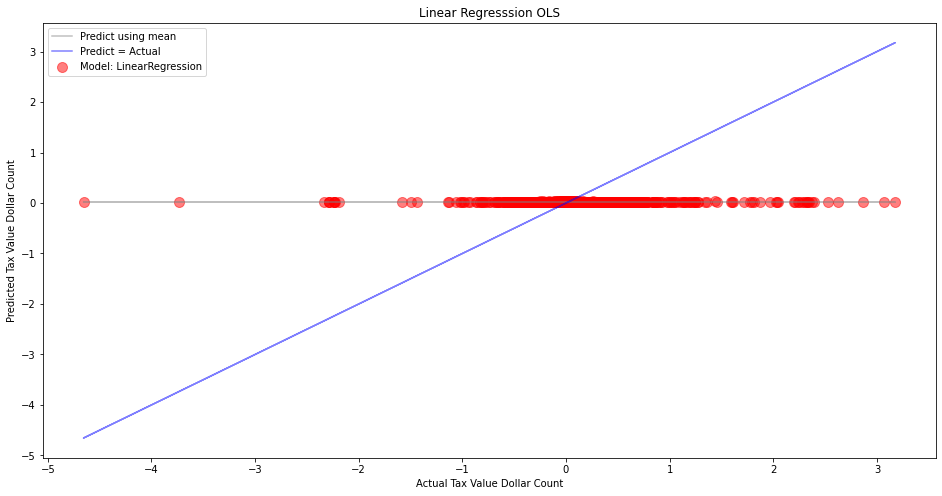

In [59]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.logerror, y_validate.logerror_pred_mean, alpha=.5, color="gray", label='Predict using mean')
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="blue", label='Predict = Actual')
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm_1, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.legend()
plt.xlabel("Actual Tax Value Dollar Count")
plt.ylabel("Predicted Tax Value Dollar Count")
plt.title("Linear Regresssion OLS")
plt.show()

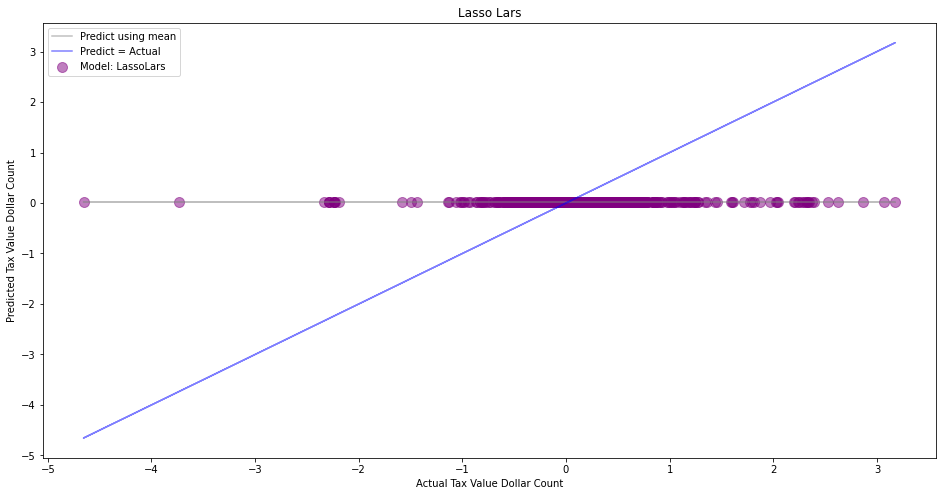

In [60]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.logerror, y_validate.logerror_pred_mean, alpha=.5, color="gray", label='Predict using mean')
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="blue", label='Predict = Actual')
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lars, 
            alpha=.5, color="purple", s=100, label="Model: LassoLars")
plt.legend()
plt.xlabel("Actual Tax Value Dollar Count")
plt.ylabel("Predicted Tax Value Dollar Count")
plt.title("Lasso Lars")
plt.show()

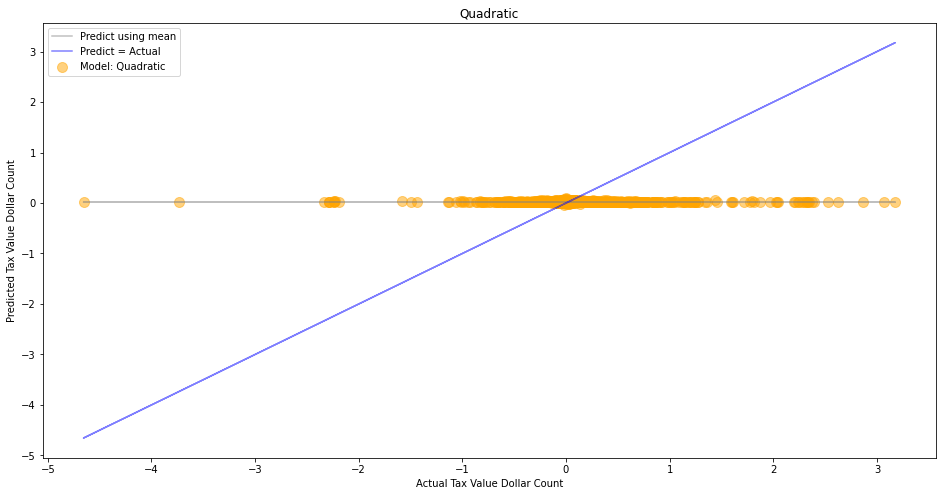

In [61]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.logerror, y_validate.logerror_pred_mean, alpha=.5, color="gray", label='Predict using mean')
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="blue", label='Predict = Actual')
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm2, 
            alpha=.5, color="orange", s=100, label="Model: Quadratic")
plt.legend()
plt.xlabel("Actual Tax Value Dollar Count")
plt.ylabel("Predicted Tax Value Dollar Count")
plt.title("Quadratic")
plt.show()

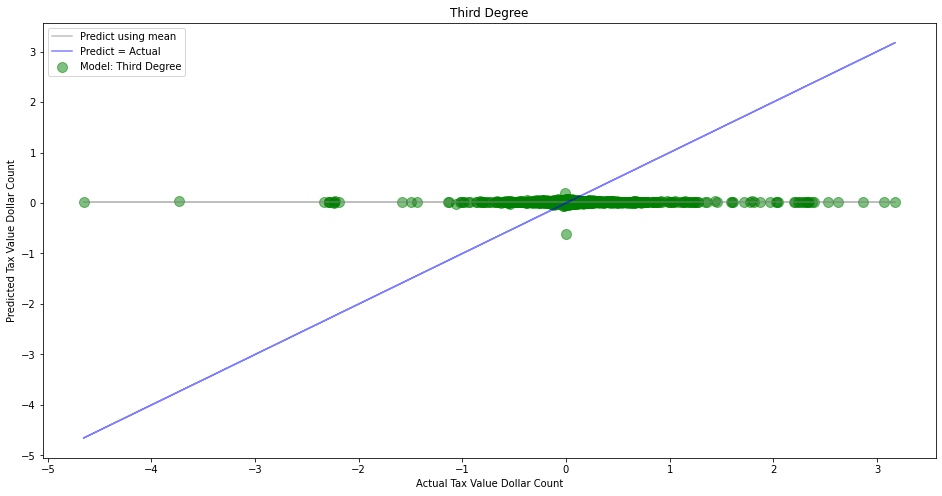

In [62]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.logerror, y_validate.logerror_pred_mean, alpha=.5, color="gray", label='Predict using mean')
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="blue", label='Predict = Actual')
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm3, 
            alpha=.5, color="green", s=100, label="Model: Third Degree")
plt.legend()
plt.xlabel("Actual Tax Value Dollar Count")
plt.ylabel("Predicted Tax Value Dollar Count")
plt.title("Third Degree")
plt.show()